<ol type=1>
<li><b>Name:- Ankush Dey,</b>   Roll No:- MDS202108 </li> 
<li><b>Name:- Anjali Pugalia,</b> Roll No:- MDS202107</li> 
<li><b>Name:- Ritirupa Dey,</b>    Roll No:- MDS202136 </li>
</ol>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import time
from tqdm.notebook import tqdm_notebook
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


##Loading the MNIST Data

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=10, shuffle=True)

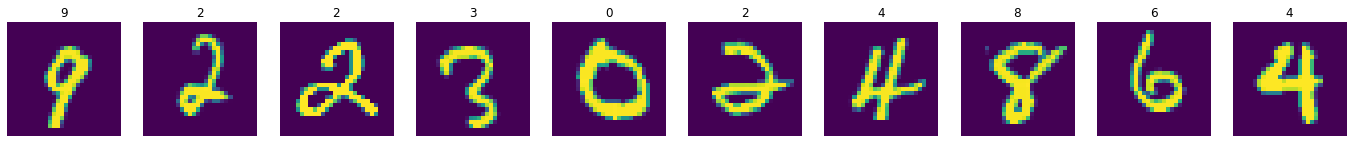

In [ ]:
# show some training images
plt.figure(figsize=(24, 24))

# fetch a batch of train images; RANDOM
train_image_batch, train_label_batch = next(iter(train_loader))

for i in range(10):
    image = train_image_batch[i]
    label = train_label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

##Generating two digit MNIST training data

In [ ]:
training_data=[]
for batch_idx, (data, target) in enumerate(train_loader):  
    double_digit_train,labels_train=[],[]   
    for i in range(0,10):
        for j in range(0,10):
            double_digit_train.append(torch.cat((data[i],data[j]),-1))
            labels_train.append(target[i]*10 + target[j])
            #time.sleep(0.01)
    l=torch.stack(double_digit_train)        
    l1=torch.stack(labels_train)
    training_data.append((l,l1))       

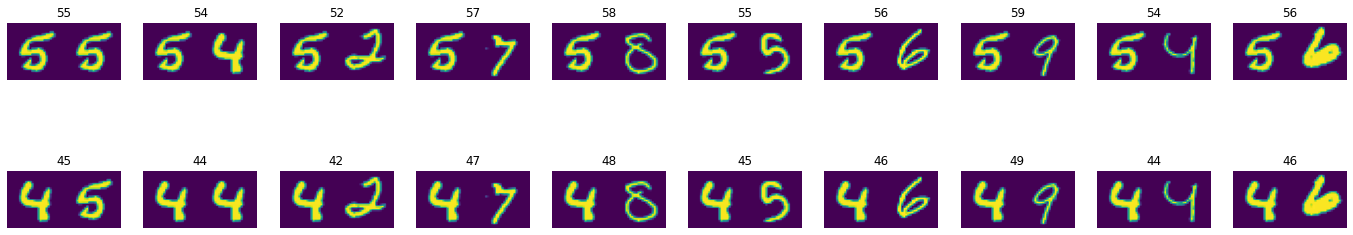

In [ ]:
plt.figure(figsize=(24, 5))
photo = training_data[0][0]
value = training_data[0][1]
for i in range(20):
    image = photo[i]
    label = value[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)


In [ ]:
training_data[0][0][0].shape

torch.Size([1, 28, 56])

##Generating two digit MNIST test data

In [ ]:
test_data=[]
for batch_idx, (data, target) in enumerate(test_loader):  
    double_digit_test,labels_test=[],[]   
    for i in range(0,10):
        for j in range(0,10):
            double_digit_test.append(torch.cat((data[i],data[j]),-1))
            labels_test.append(target[i]*10 + target[j])
    l2=torch.stack(double_digit_test)        
    l3=torch.stack(labels_test)
    test_data.append((l2,l3)) 

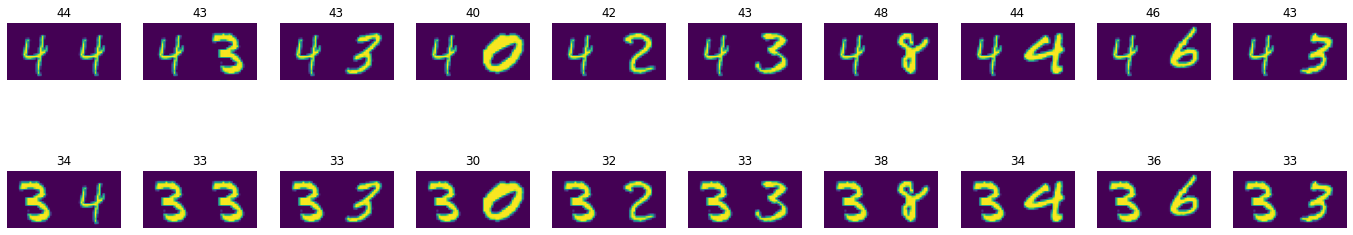

In [ ]:
plt.figure(figsize=(24, 5))
photo = test_data[0][0]
value = test_data[0][1]
for i in range(20):
    image = photo[i]
    label = value[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

#2 layer fully connected neural network


## helper function for training and testing

In [ ]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
train_loss=[]
test_loss_list=[]
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(training_data):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            train_loss.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(training_data*100),
                10000. * batch_idx / len(training_data*100), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_data:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_data*100)
    test_loss_list.append(test_loss)
    accuracy = 100. * correct / len(test_data*100)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_data*100),
        accuracy))

##Creating the 2-layer fully connected neural network

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 500), 
            nn.LeakyReLU(), 
            nn.Linear(500,300),
            nn.LeakyReLU(),
            nn.Linear(300,200), 
            nn.LeakyReLU(), 
            nn.Linear(200, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

##Traning the network

In [ ]:
import time
input_size  = 28*56  
output_size = 100 
start = time.time()
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01,momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in tqdm_notebook(range(0, 25)):
    train(epoch, model_fnn)
    test(model_fnn)
end = time.time()
print("time taken = {} sec".format(end-start))    

Training on  cuda:0
Number of parameters: 1015100


  0%|          | 0/25 [00:00<?, ?it/s]

Train Epoch: 1 [0/600000 (0%)]	Loss: 4.594874
Train Epoch: 1 [100000/600000 (17%)]	Loss: 0.737311
Train Epoch: 1 [200000/600000 (33%)]	Loss: 0.339092
Train Epoch: 1 [300000/600000 (50%)]	Loss: 1.602064
Train Epoch: 1 [400000/600000 (67%)]	Loss: 0.266341
Train Epoch: 1 [500000/600000 (83%)]	Loss: 0.979231

Test set: Average loss: 0.4451, Accuracy: 86884/100000 (87%)

Train Epoch: 2 [0/600000 (0%)]	Loss: 0.693614
Train Epoch: 2 [100000/600000 (17%)]	Loss: 0.146250
Train Epoch: 2 [200000/600000 (33%)]	Loss: 0.090631
Train Epoch: 2 [300000/600000 (50%)]	Loss: 0.765101
Train Epoch: 2 [400000/600000 (67%)]	Loss: 0.038134
Train Epoch: 2 [500000/600000 (83%)]	Loss: 0.721065

Test set: Average loss: 0.2977, Accuracy: 91204/100000 (91%)

Train Epoch: 3 [0/600000 (0%)]	Loss: 0.495883
Train Epoch: 3 [100000/600000 (17%)]	Loss: 0.138083
Train Epoch: 3 [200000/600000 (33%)]	Loss: 0.054532
Train Epoch: 3 [300000/600000 (50%)]	Loss: 0.433971
Train Epoch: 3 [400000/600000 (67%)]	Loss: 0.013556
Train Ep

##Showing Some prediction on network

In [ ]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,24), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(100), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(100))
    ax2.set_yticklabels(numpy.arange(100))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()


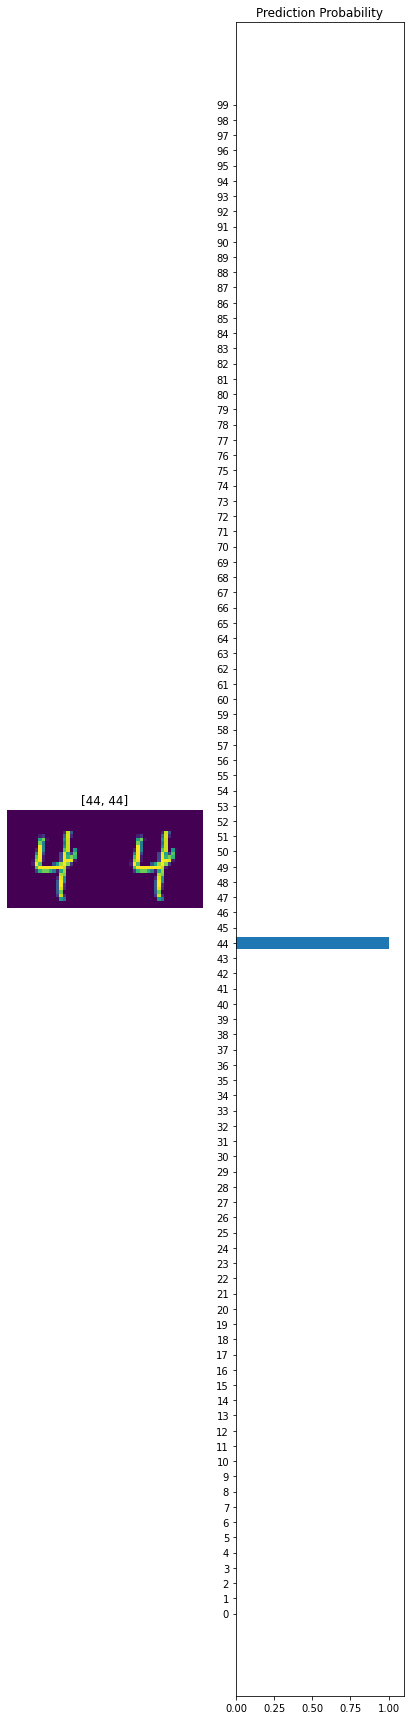

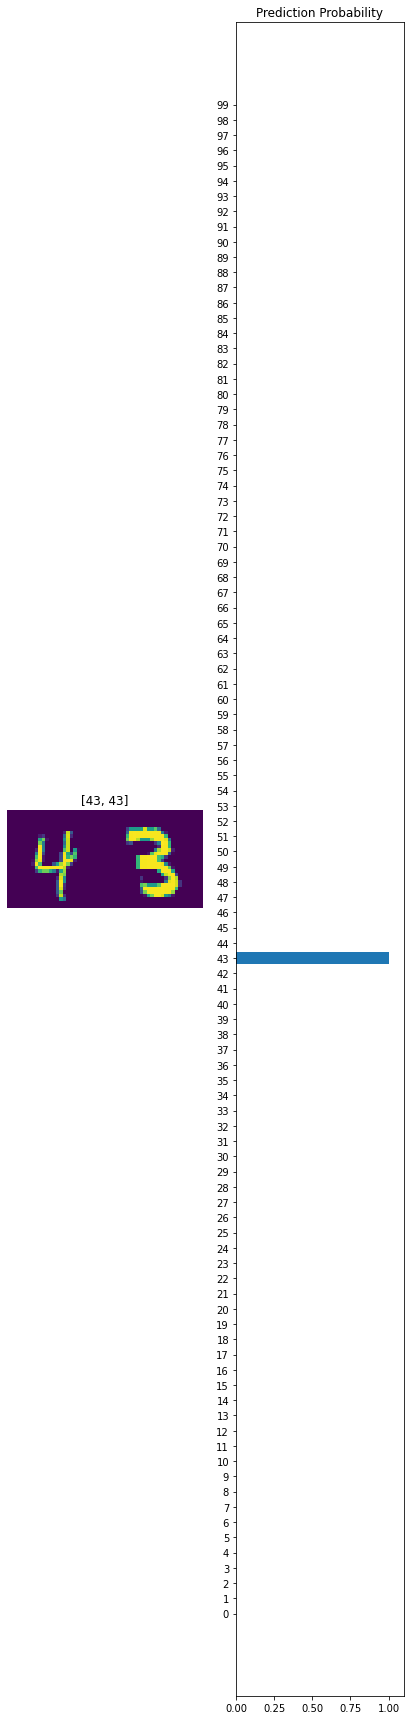

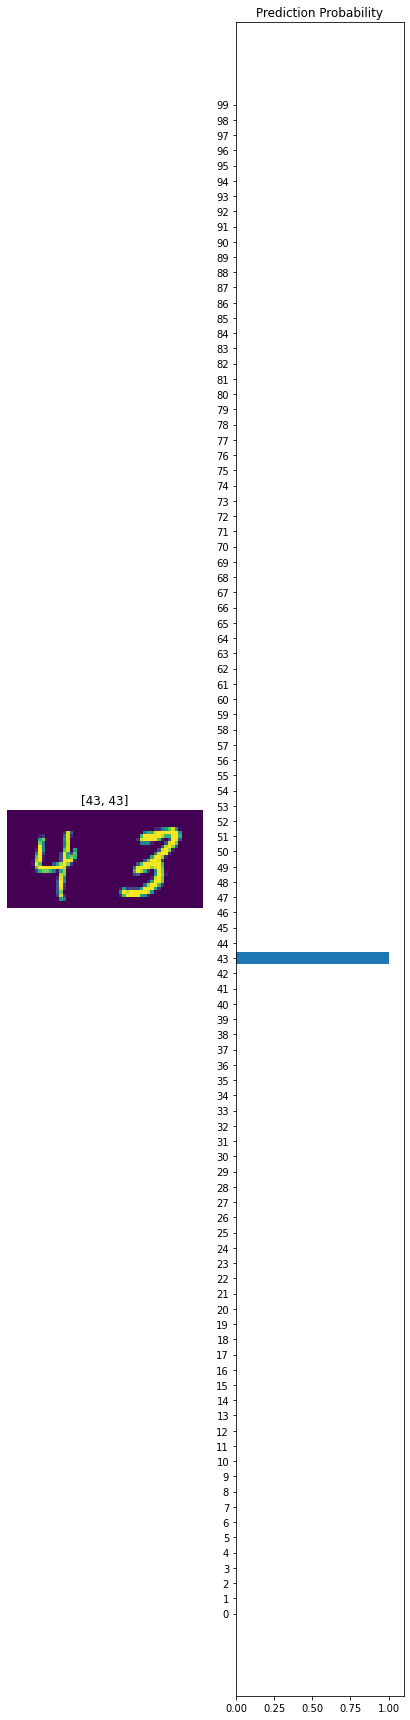

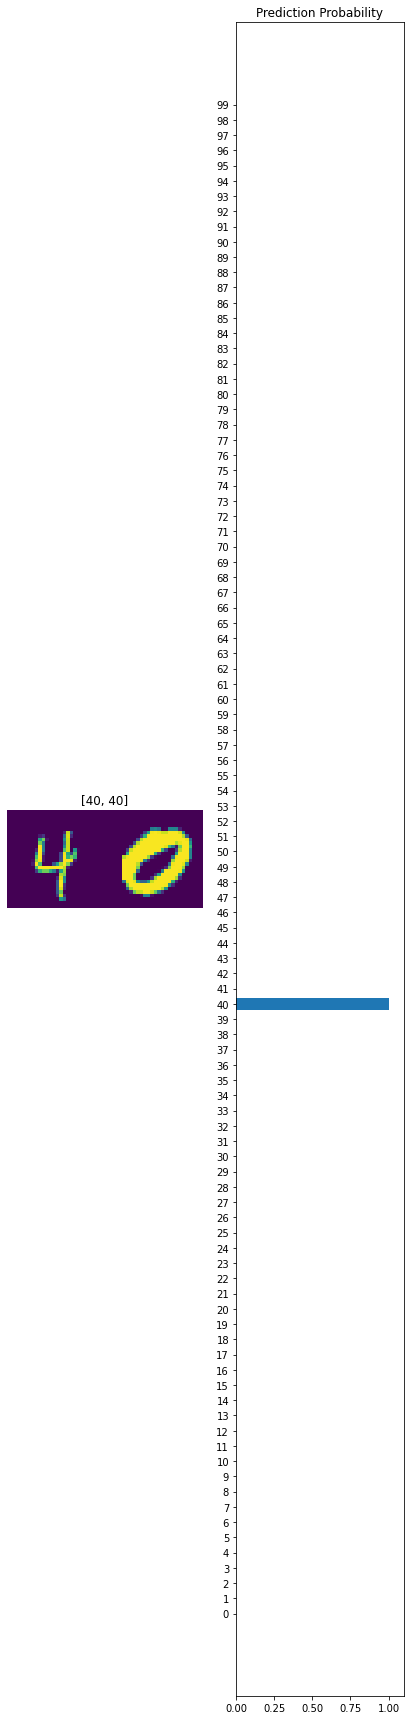

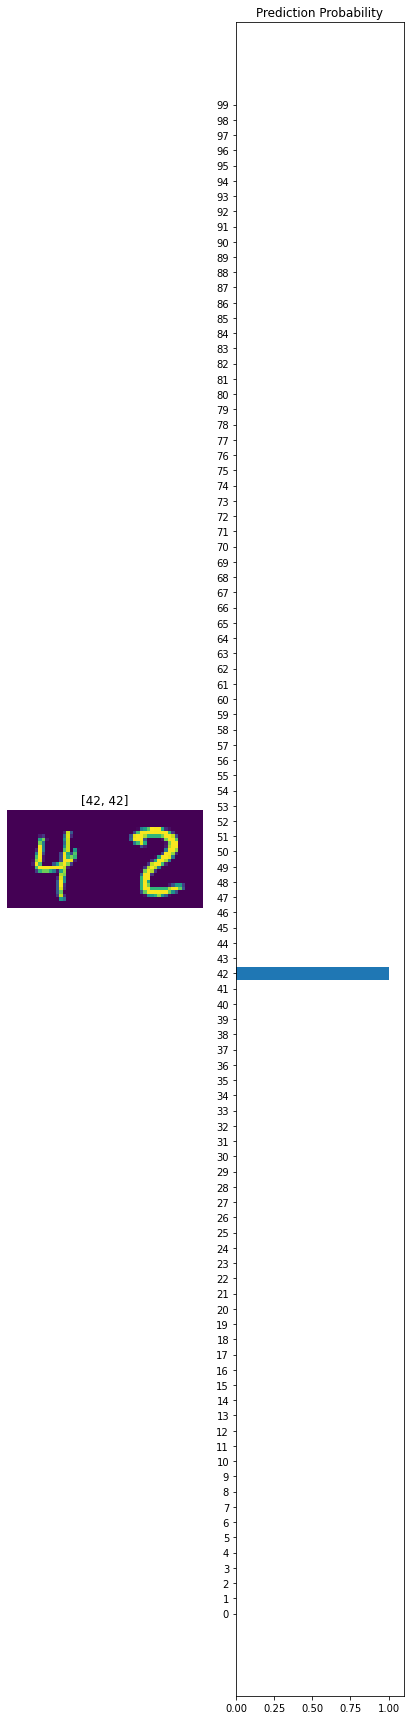

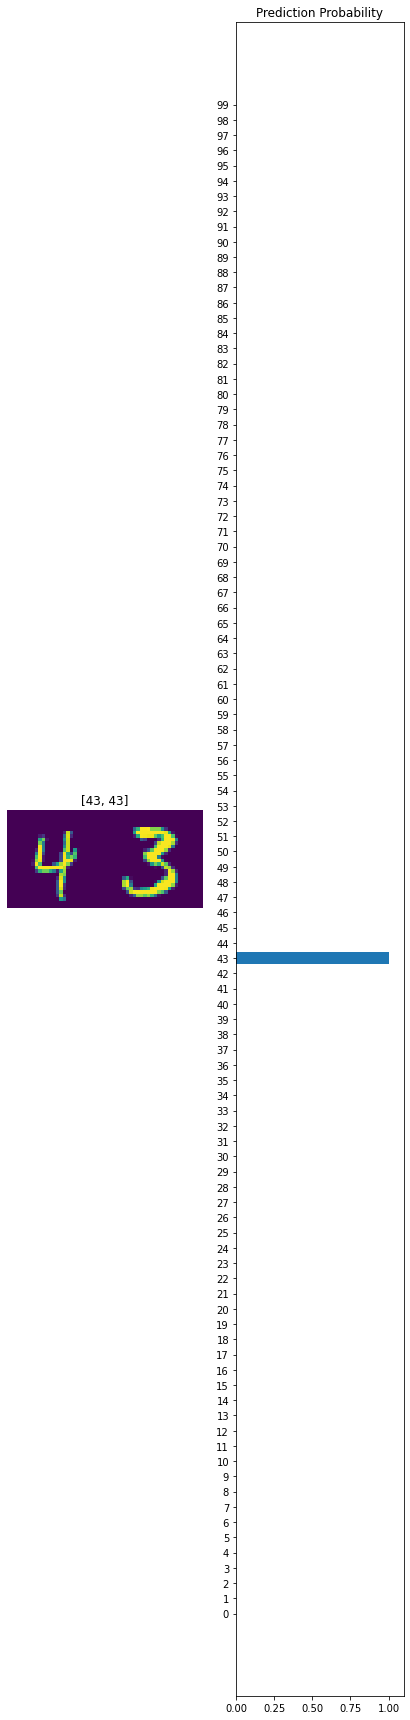

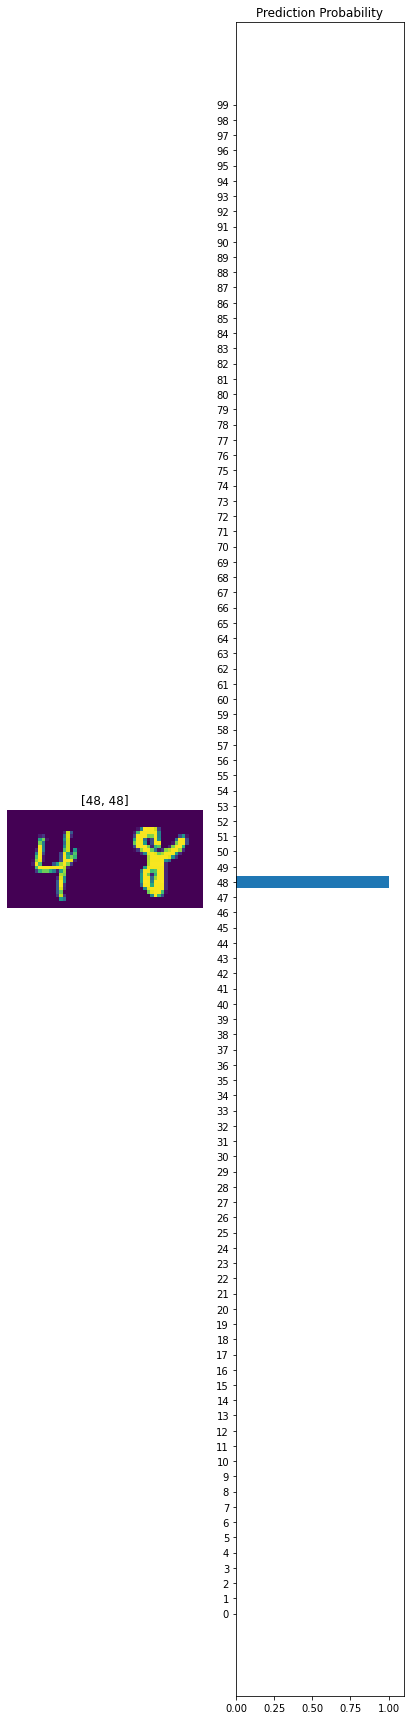

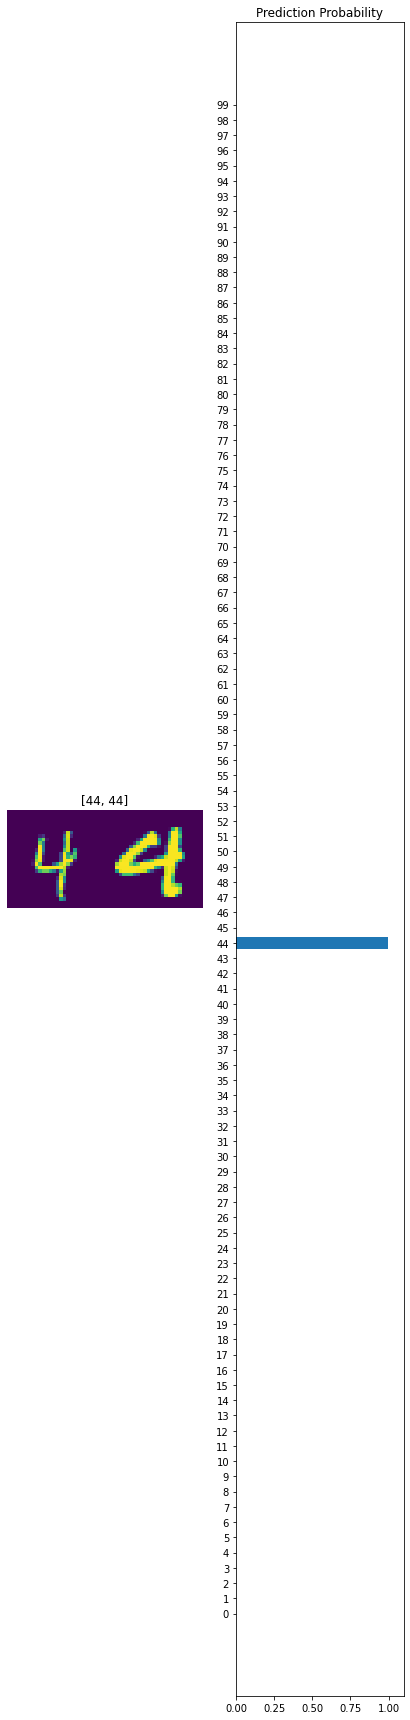

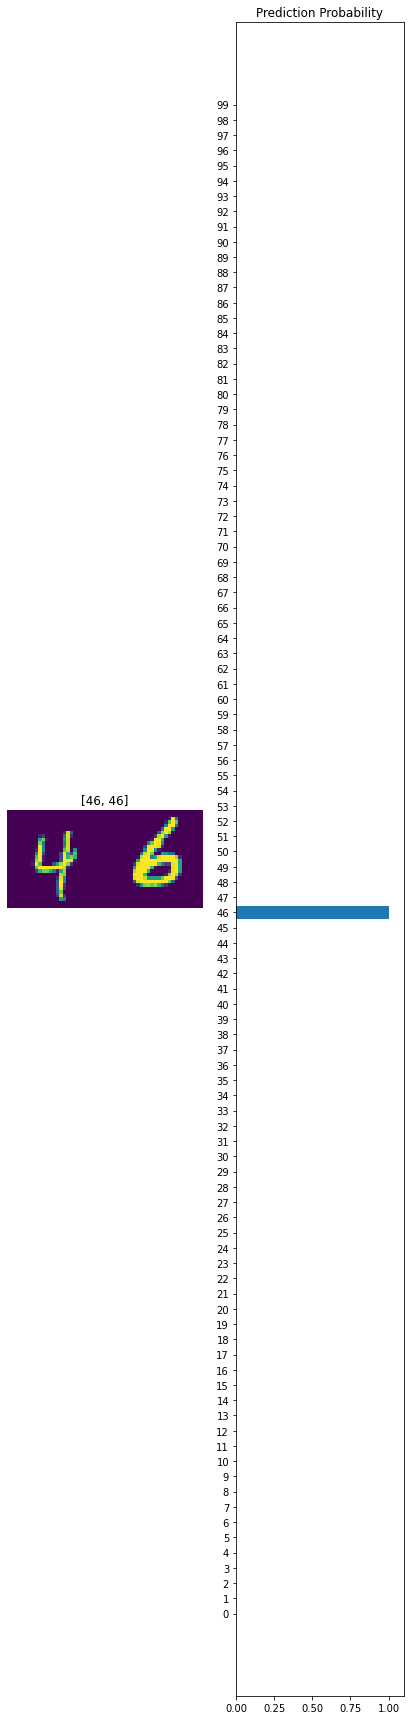

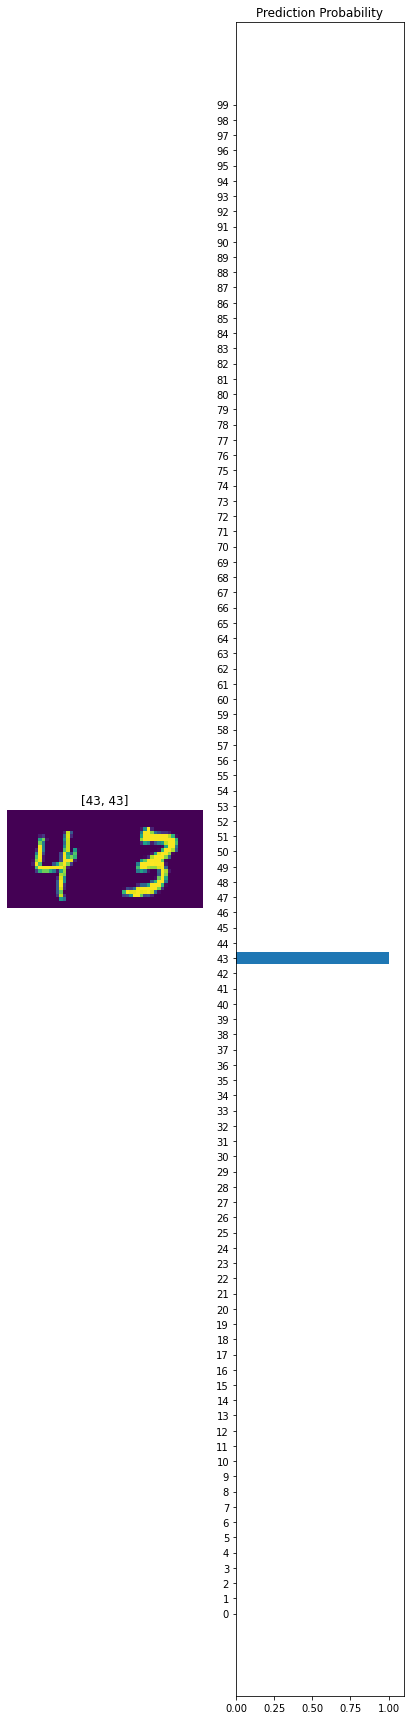

In [ ]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_data))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

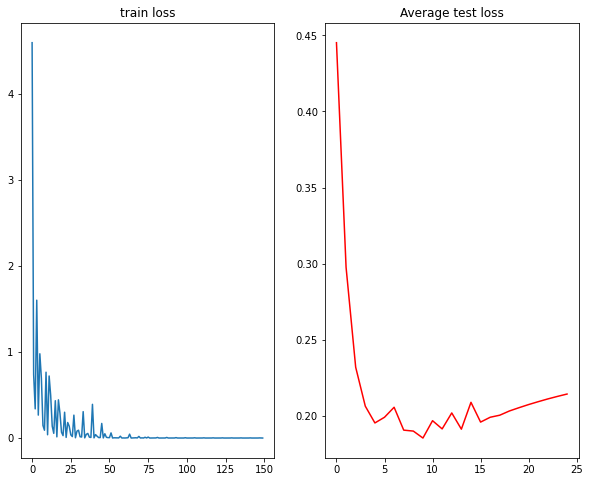

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
#plt.figure(figsize=(10, 5))
plt.plot(train_loss)
plt.title("train loss")
plt.subplot(1,2,2)
#plt.figure(figsize=(10, 5))
plt.plot(test_loss_list,color='red')
plt.title("Average test loss")
#plt.legend()
plt.show()

#Creating 3 layer neural network with dropout 

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 1000), 
            nn.Dropout(0.2),
            nn.LeakyReLU(), 
            nn.Linear(1000,800),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(800,600), 
            nn.Dropout(0.2),
            nn.LeakyReLU(), 
            nn.Linear(600,400), 
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(400, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

#Training the network

In [ ]:
import time
input_size  = 28*56  
output_size = 100 
start = time.time()
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in tqdm_notebook(range(0, 25)):
    train(epoch, model_fnn)
    test(model_fnn)
end = time.time()
print("time taken = {} sec".format(end-start))    

Training on  cuda:0
Number of parameters: 3130900


  0%|          | 0/25 [00:00<?, ?it/s]

Train Epoch: 1 [0/600000 (0%)]	Loss: 4.597141
Train Epoch: 1 [100000/600000 (17%)]	Loss: 4.476403
Train Epoch: 1 [200000/600000 (33%)]	Loss: 3.006742
Train Epoch: 1 [300000/600000 (50%)]	Loss: 1.978328
Train Epoch: 1 [400000/600000 (67%)]	Loss: 0.812002
Train Epoch: 1 [500000/600000 (83%)]	Loss: 0.883285

Test set: Average loss: 0.6887, Accuracy: 80512/100000 (81%)

Train Epoch: 2 [0/600000 (0%)]	Loss: 1.101226
Train Epoch: 2 [100000/600000 (17%)]	Loss: 0.193196
Train Epoch: 2 [200000/600000 (33%)]	Loss: 0.238683
Train Epoch: 2 [300000/600000 (50%)]	Loss: 1.150348
Train Epoch: 2 [400000/600000 (67%)]	Loss: 0.166746
Train Epoch: 2 [500000/600000 (83%)]	Loss: 0.888810

Test set: Average loss: 0.3637, Accuracy: 89365/100000 (89%)

Train Epoch: 3 [0/600000 (0%)]	Loss: 0.633719
Train Epoch: 3 [100000/600000 (17%)]	Loss: 0.143596
Train Epoch: 3 [200000/600000 (33%)]	Loss: 0.164419
Train Epoch: 3 [300000/600000 (50%)]	Loss: 0.796403
Train Epoch: 3 [400000/600000 (67%)]	Loss: 0.069897
Train Ep

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


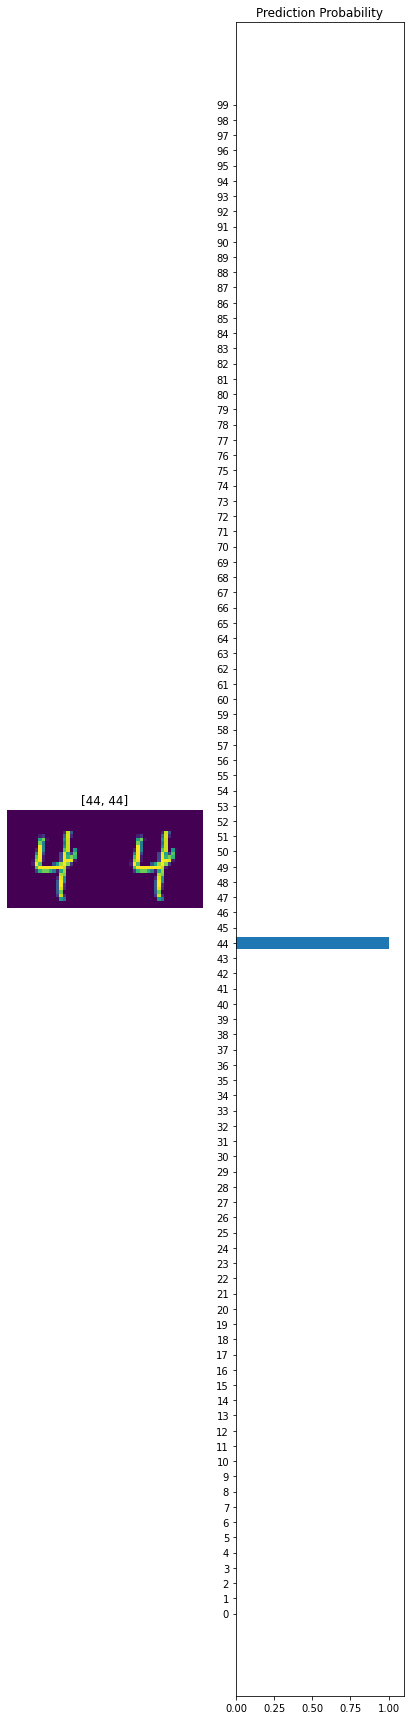

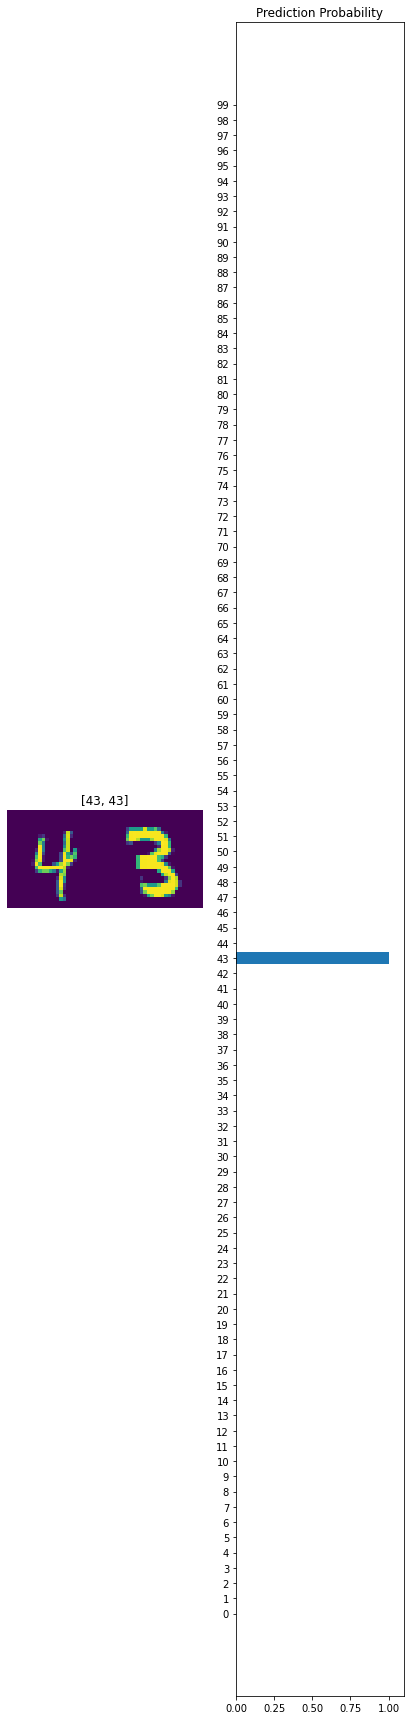

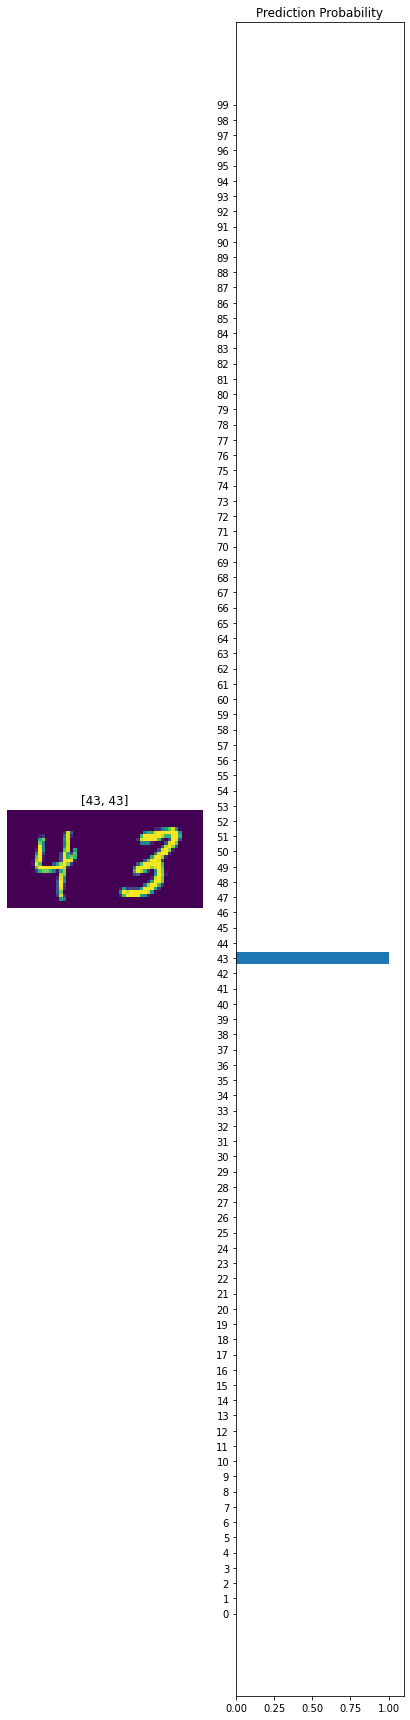

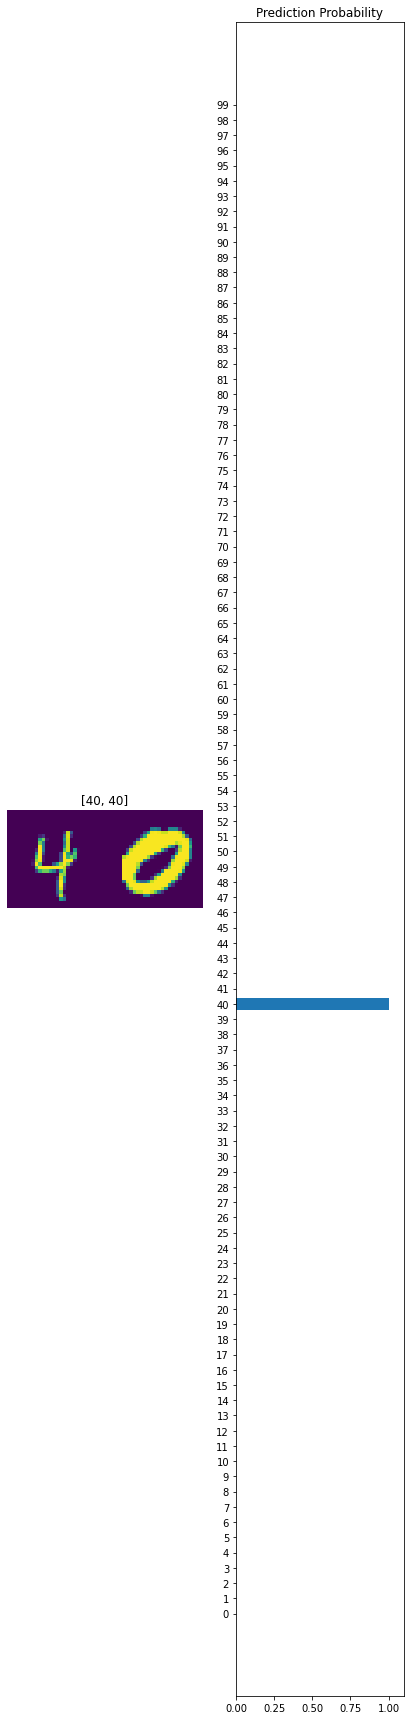

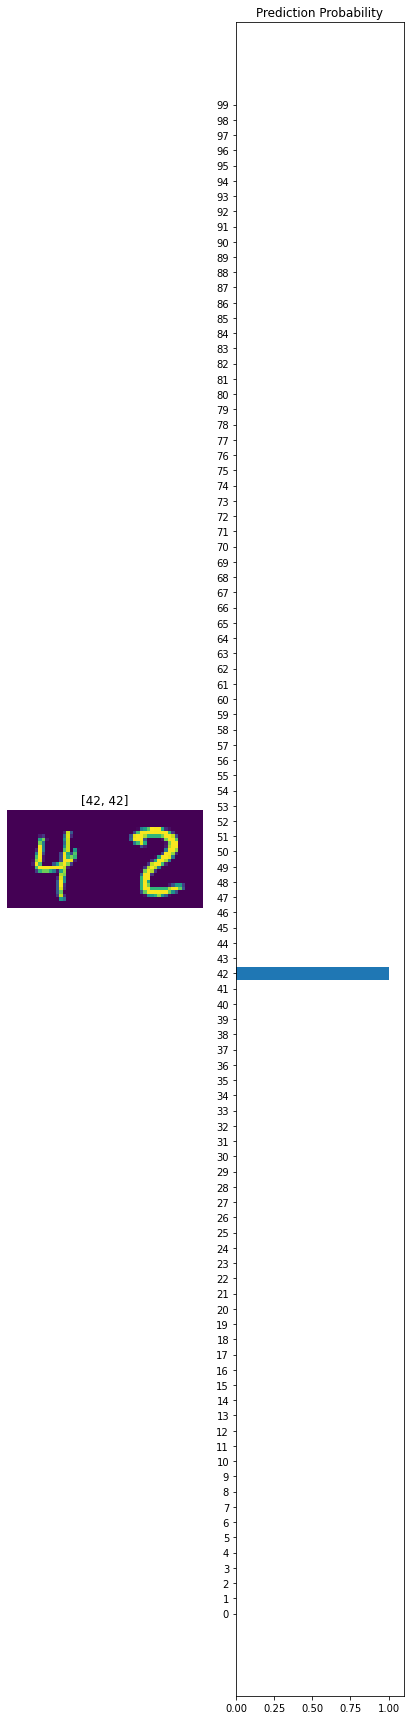

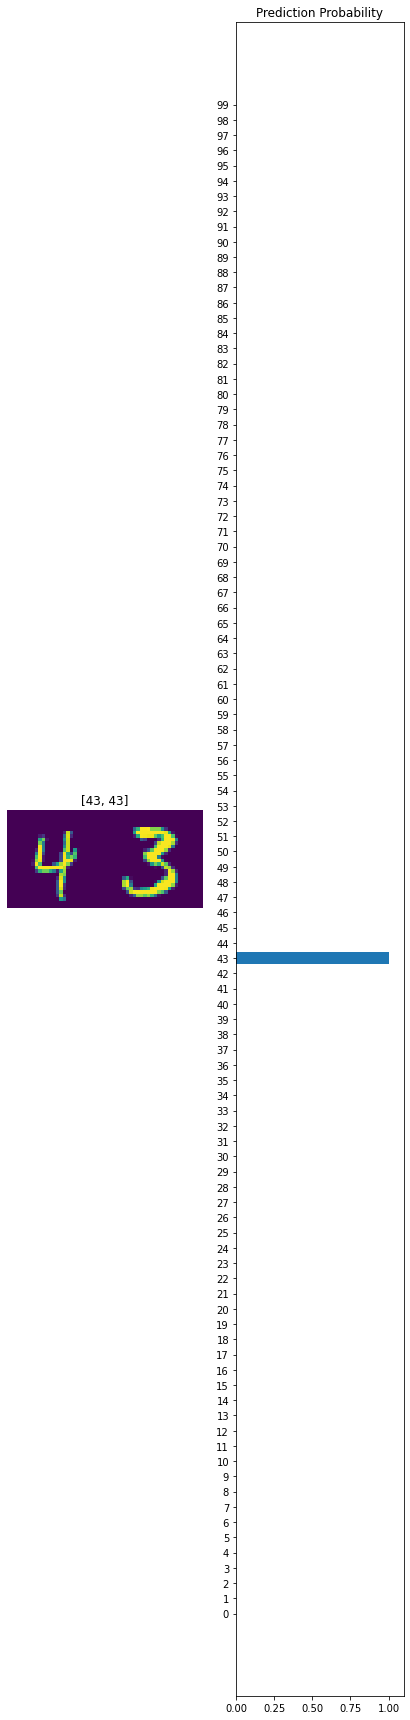

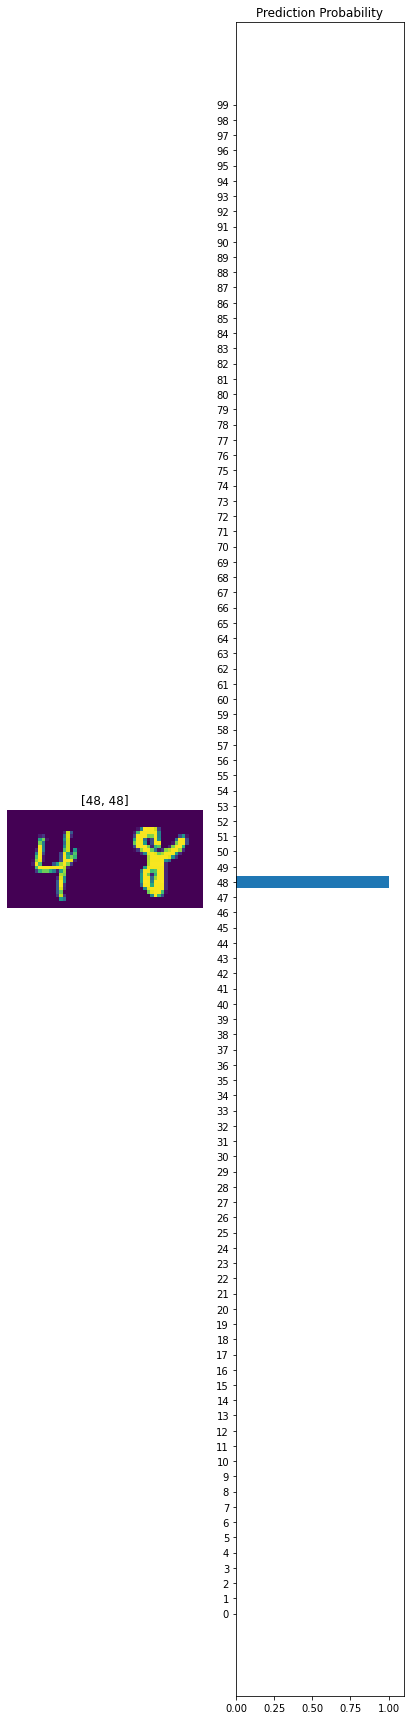

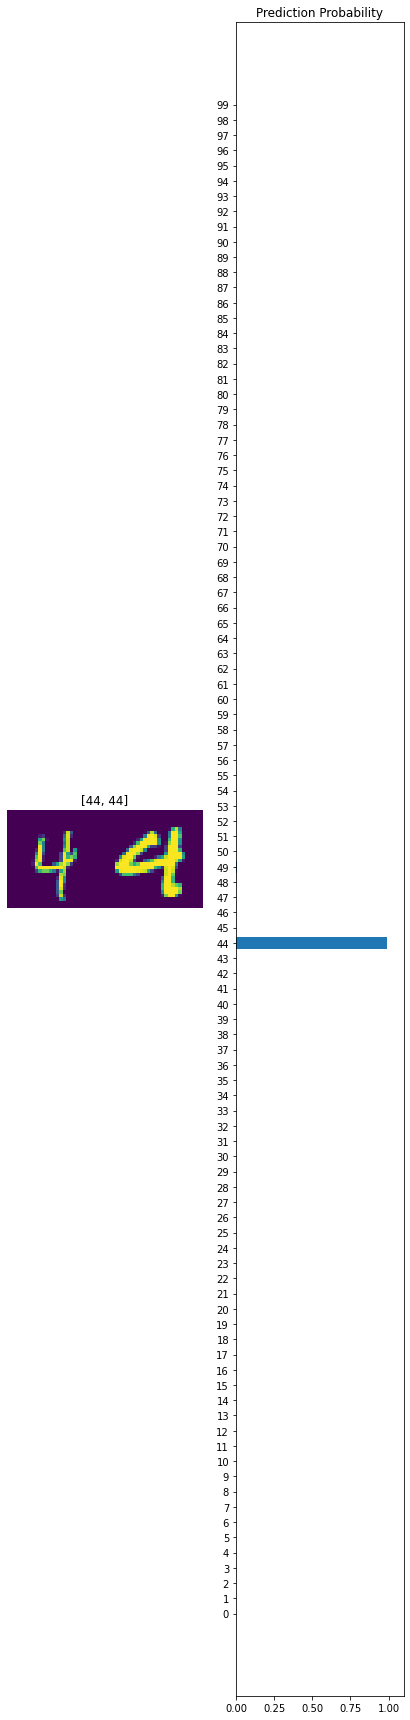

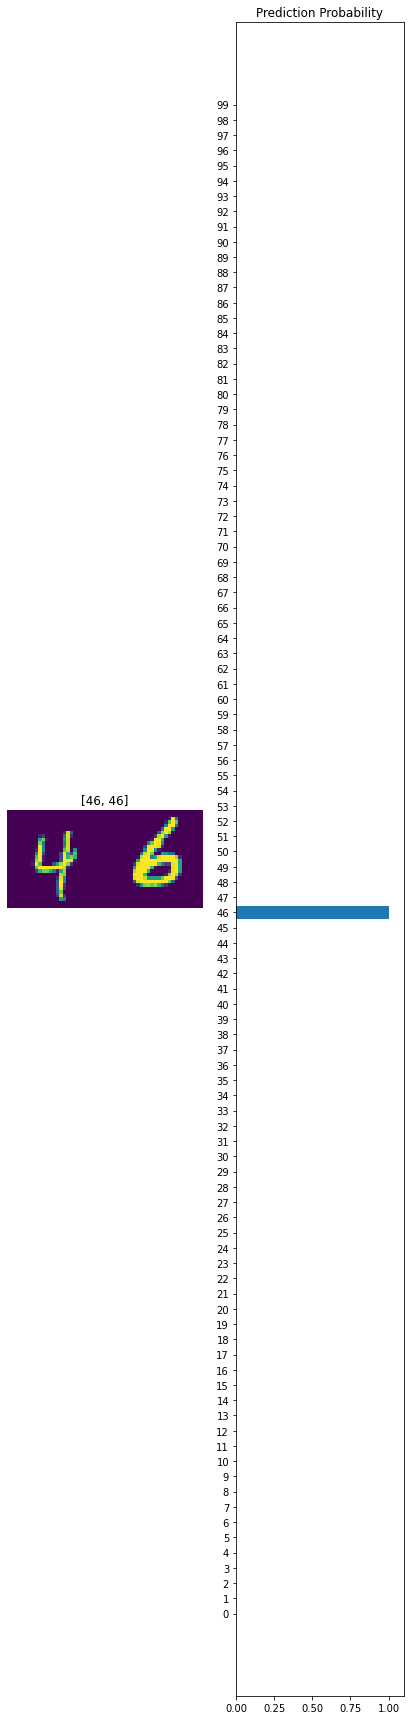

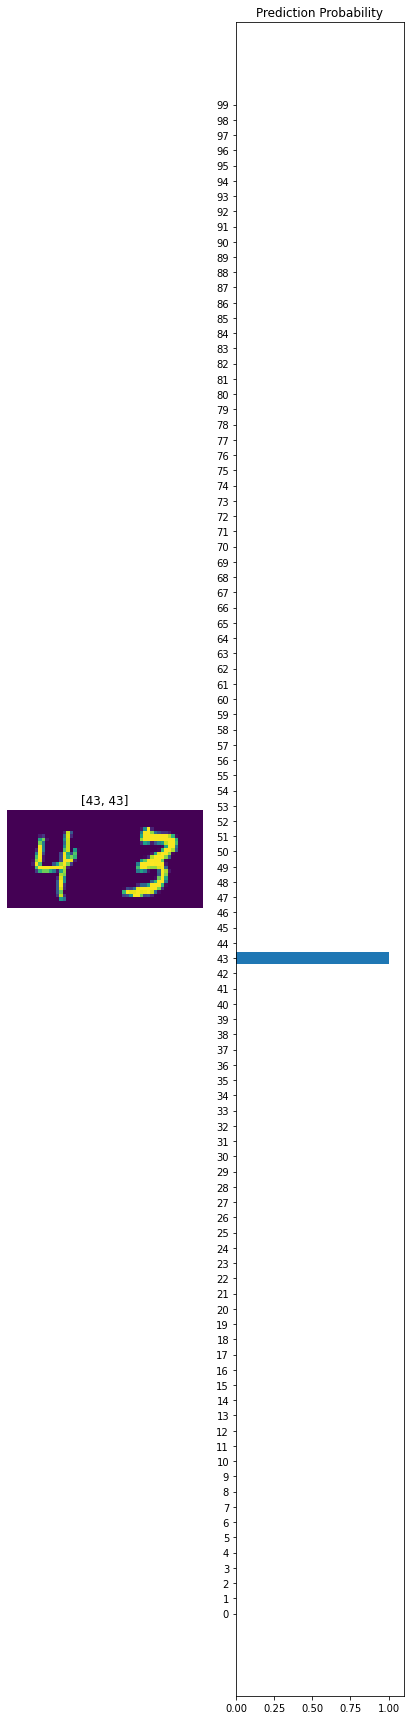

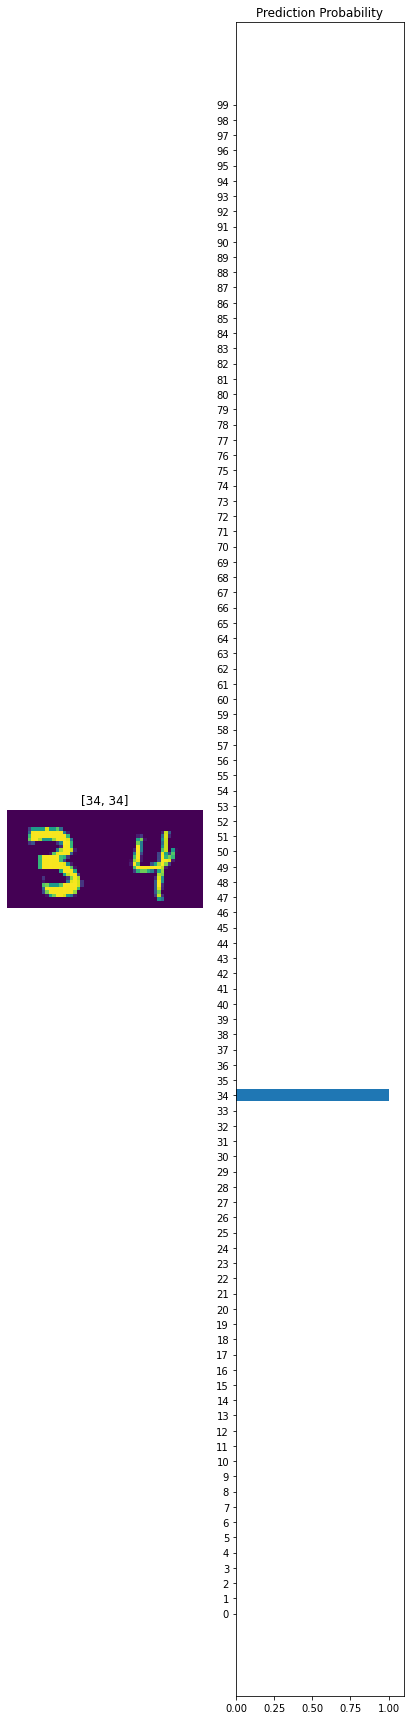

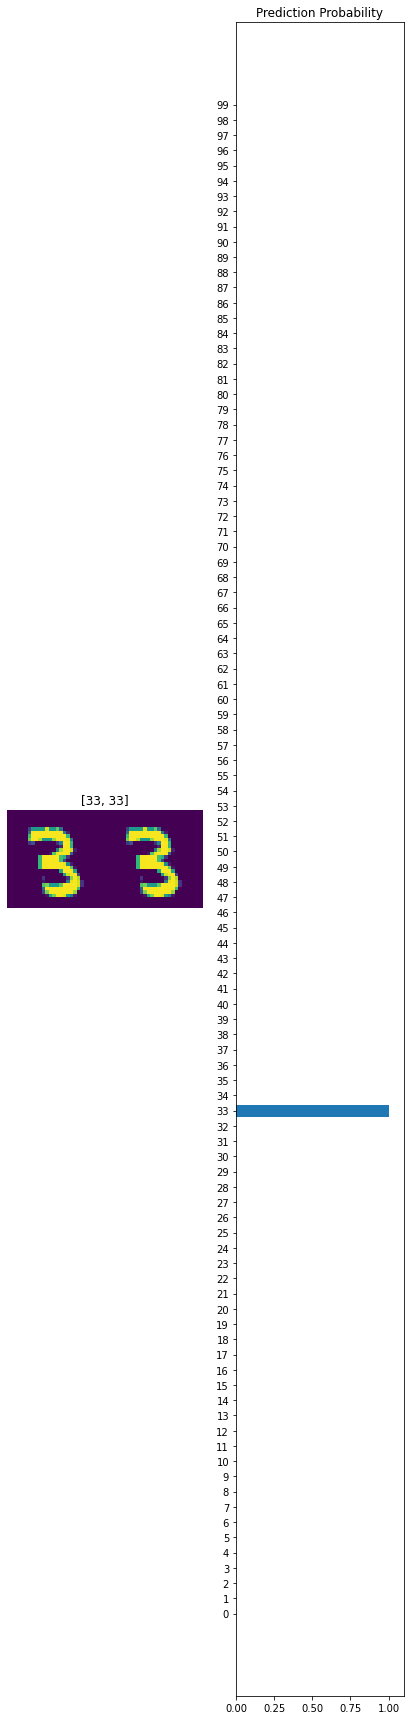

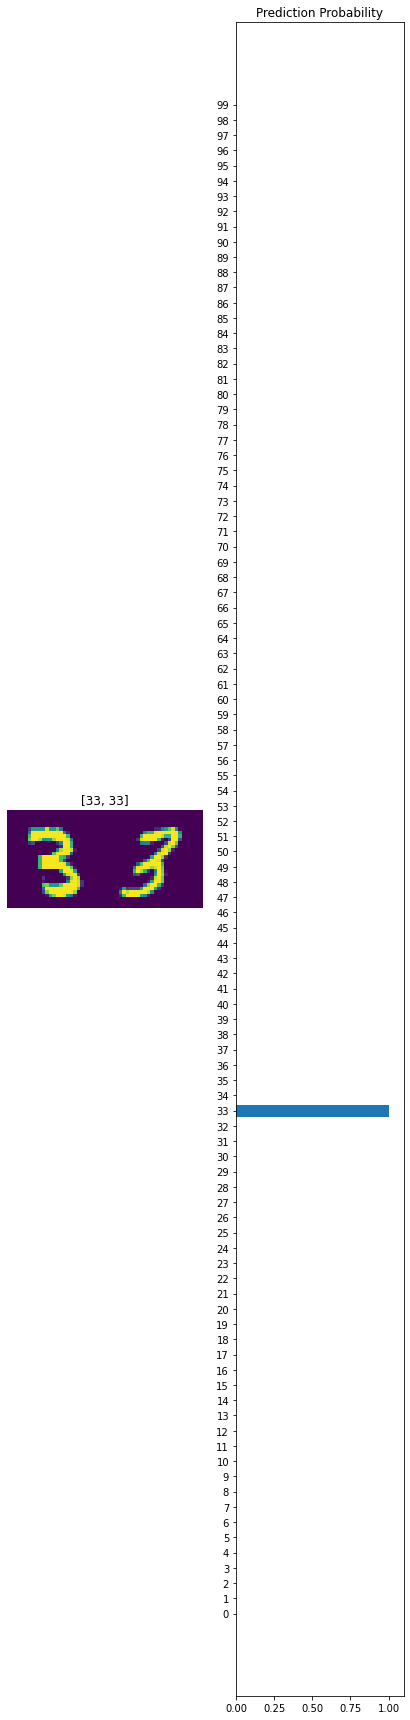

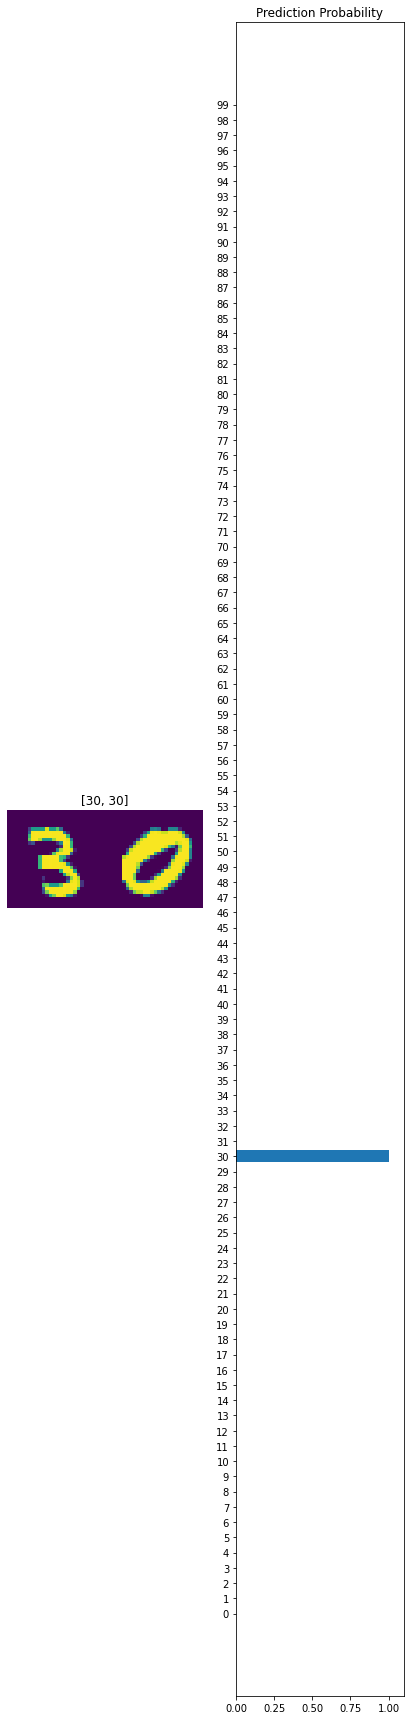

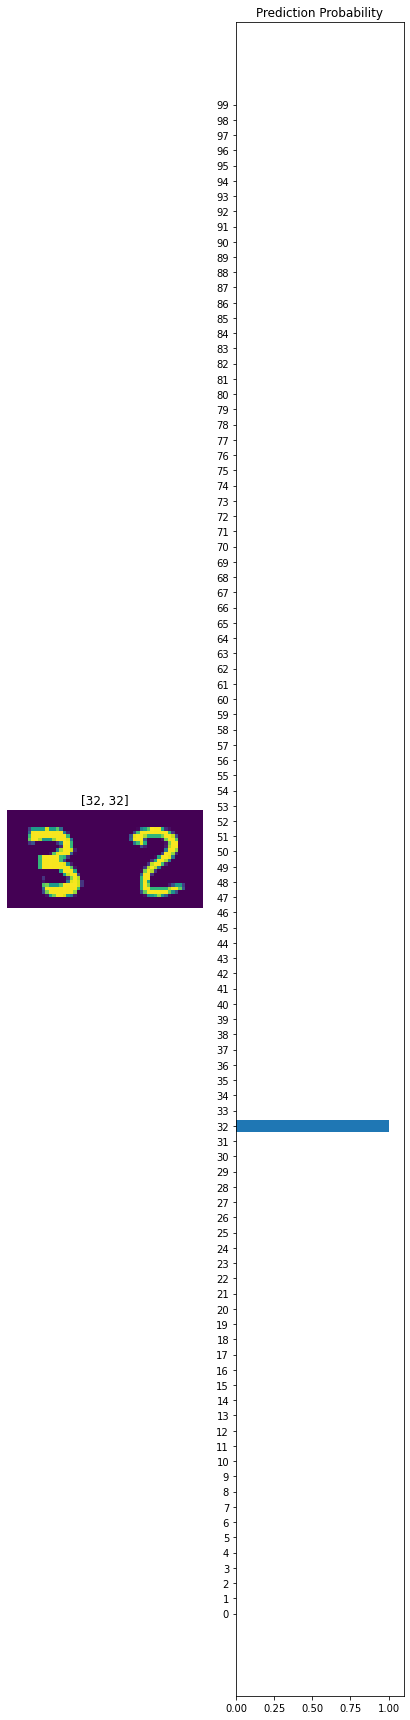

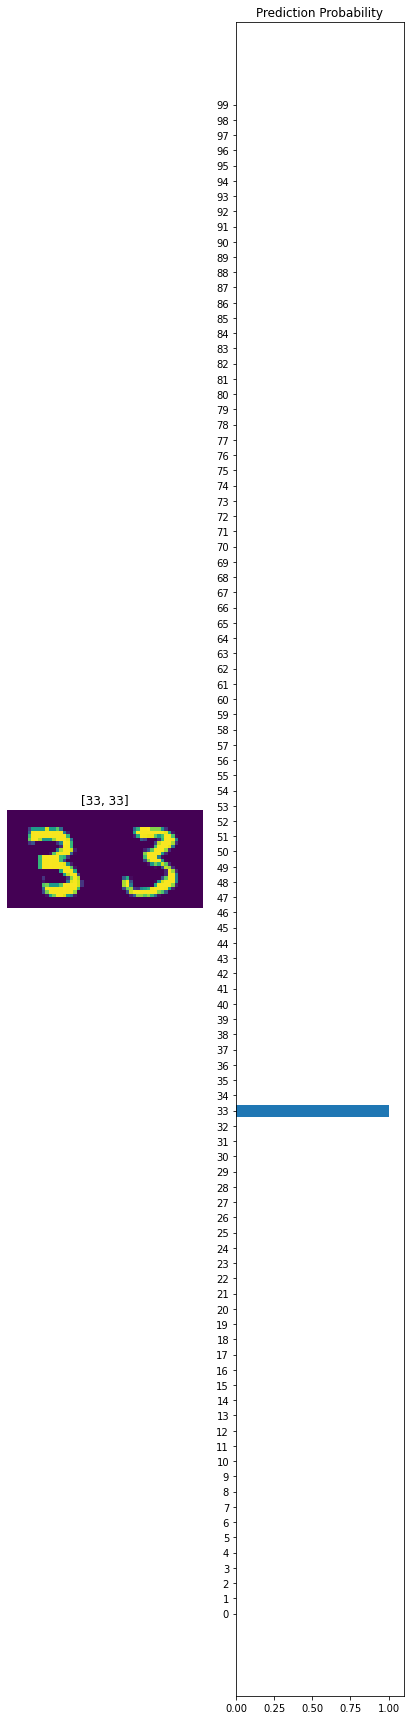

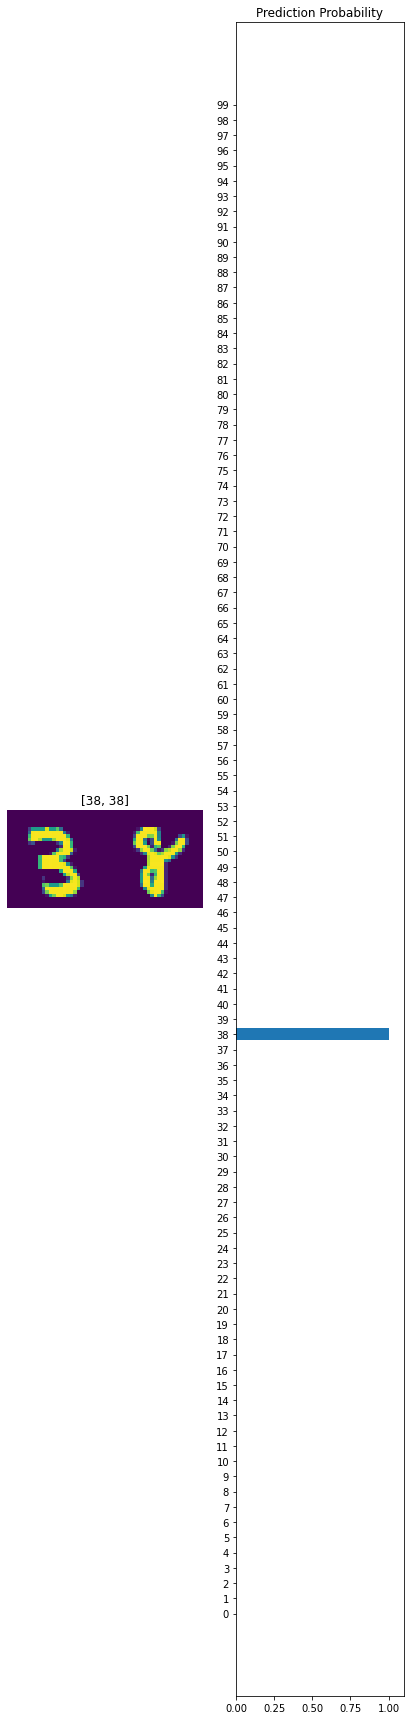

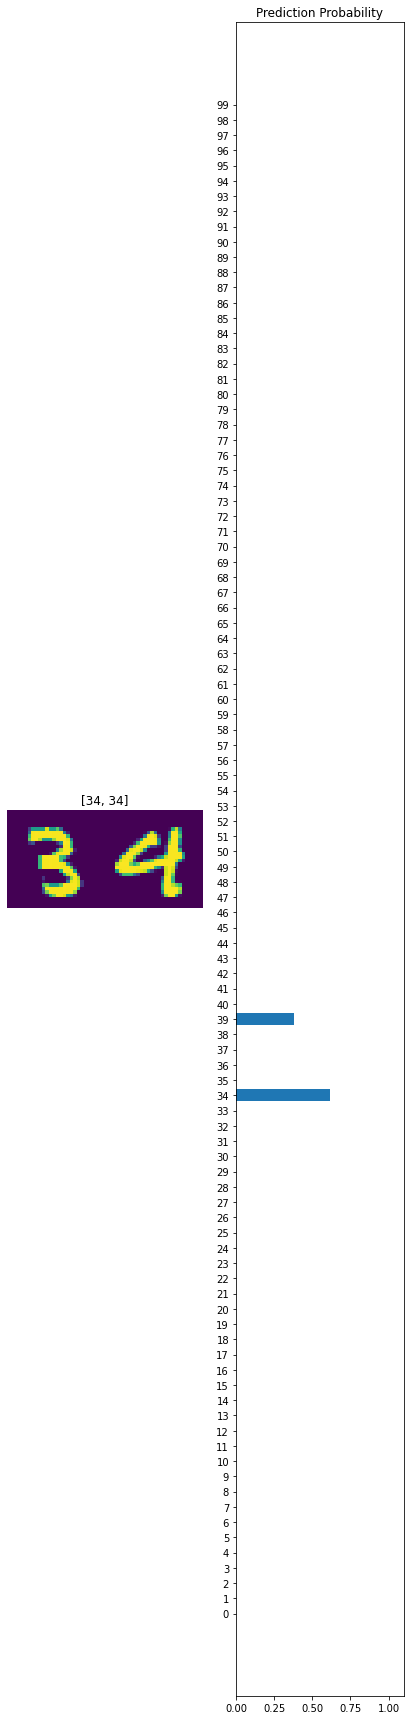

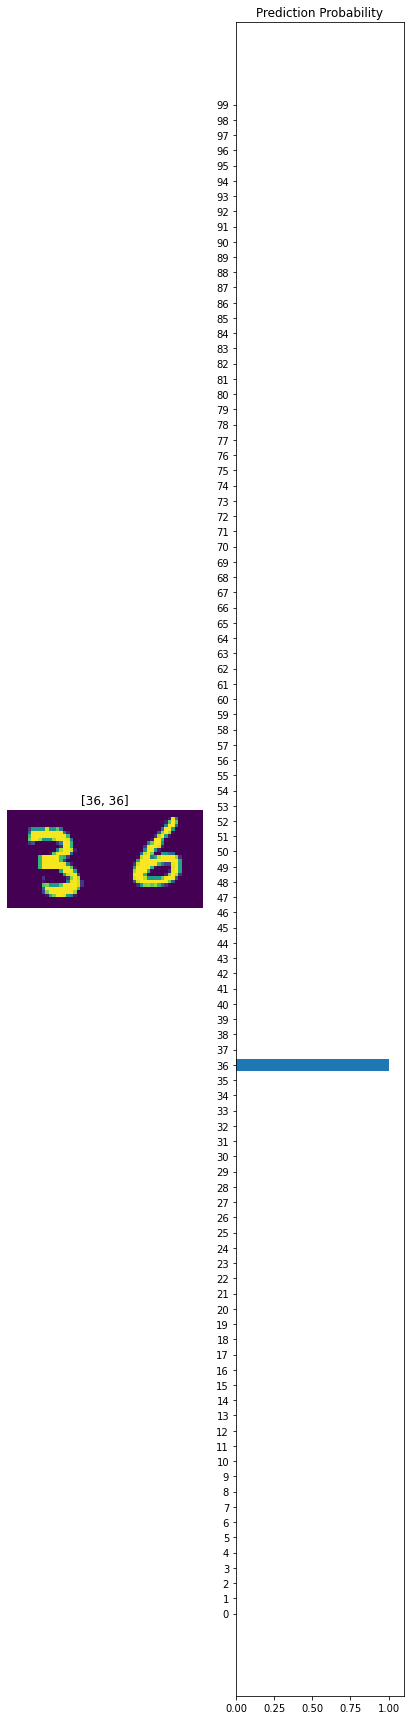

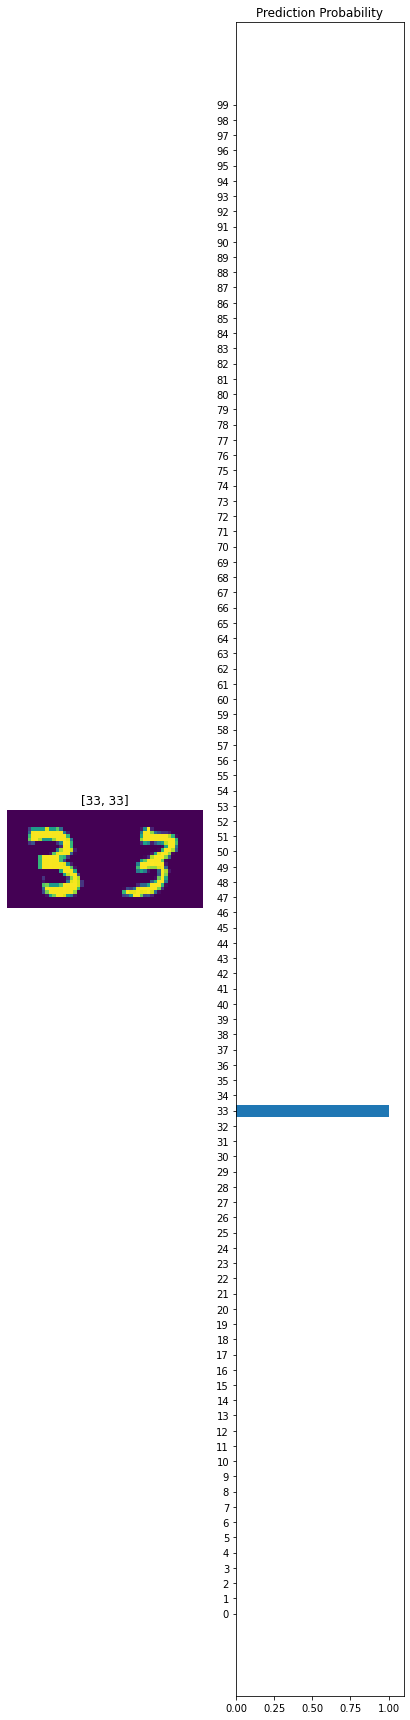

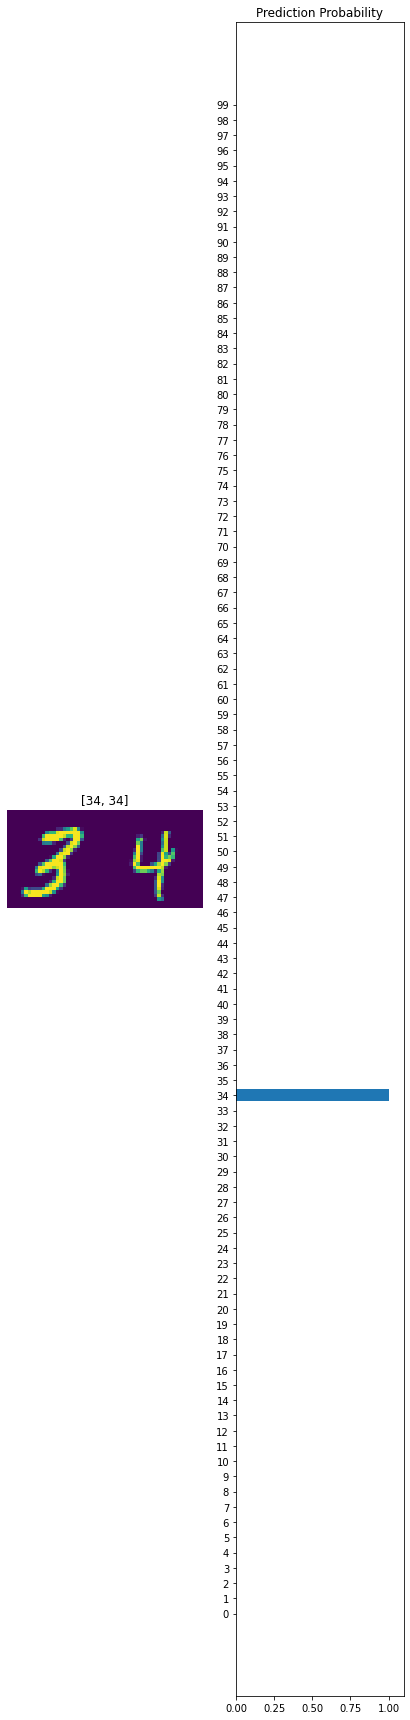

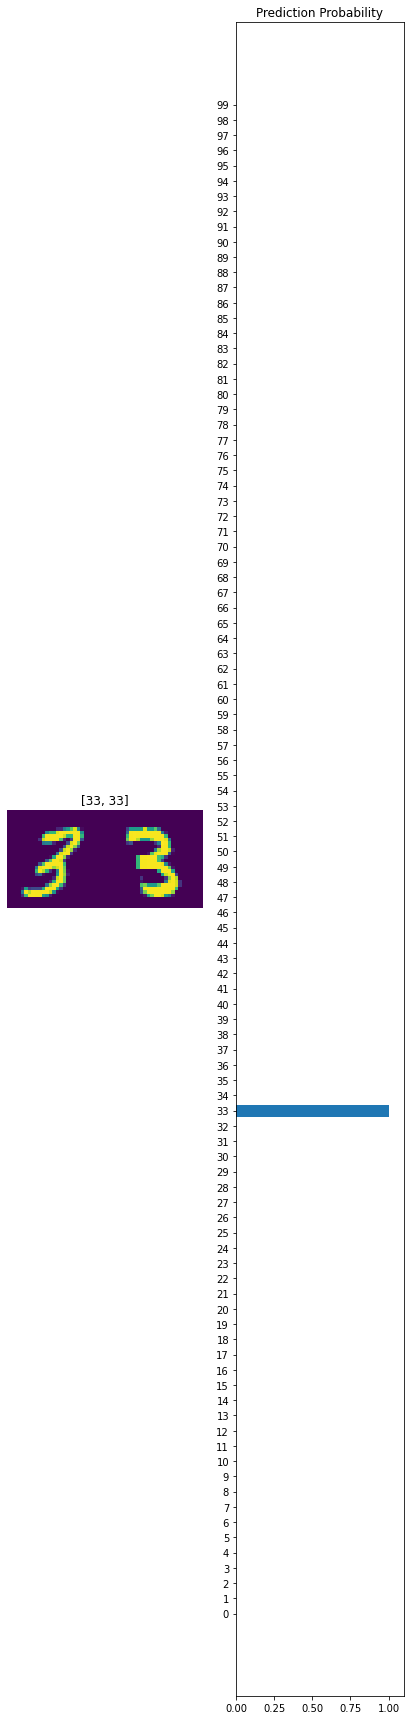

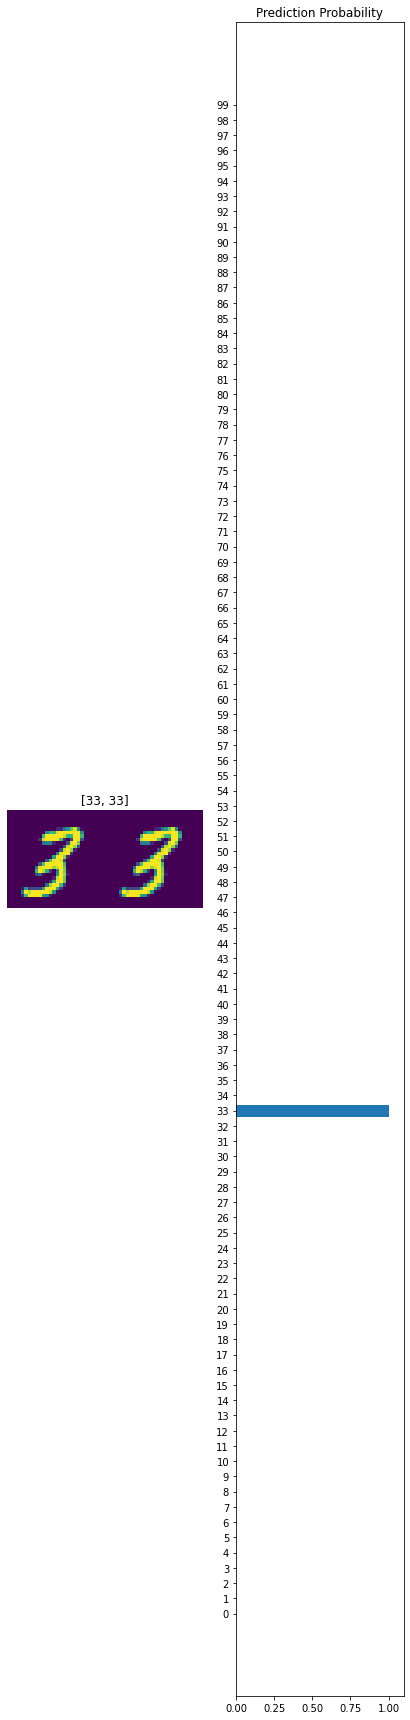

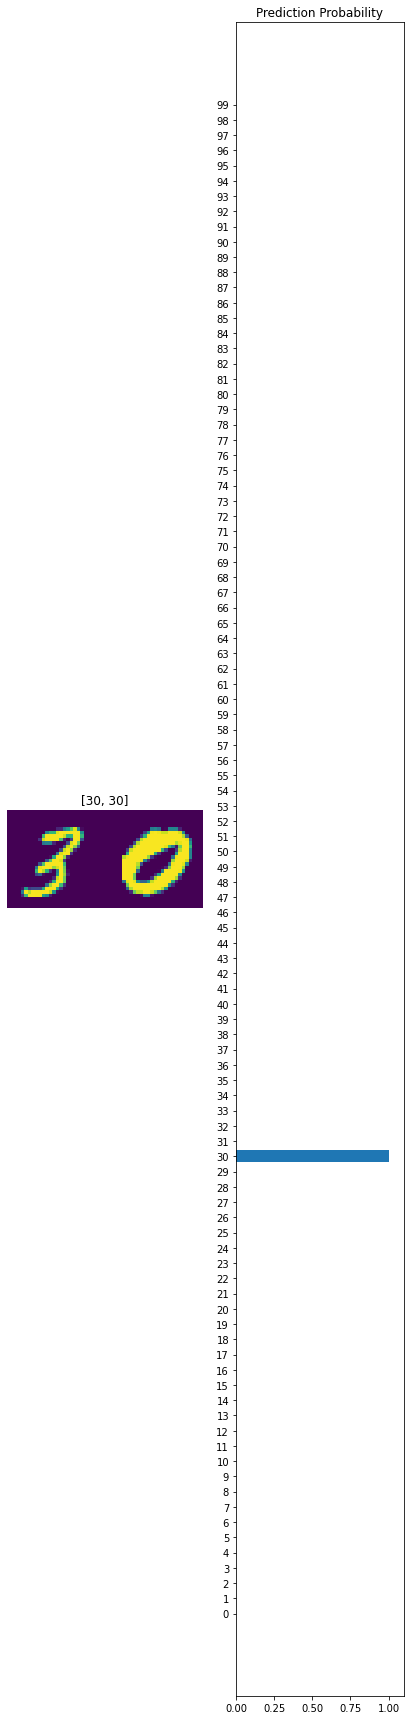

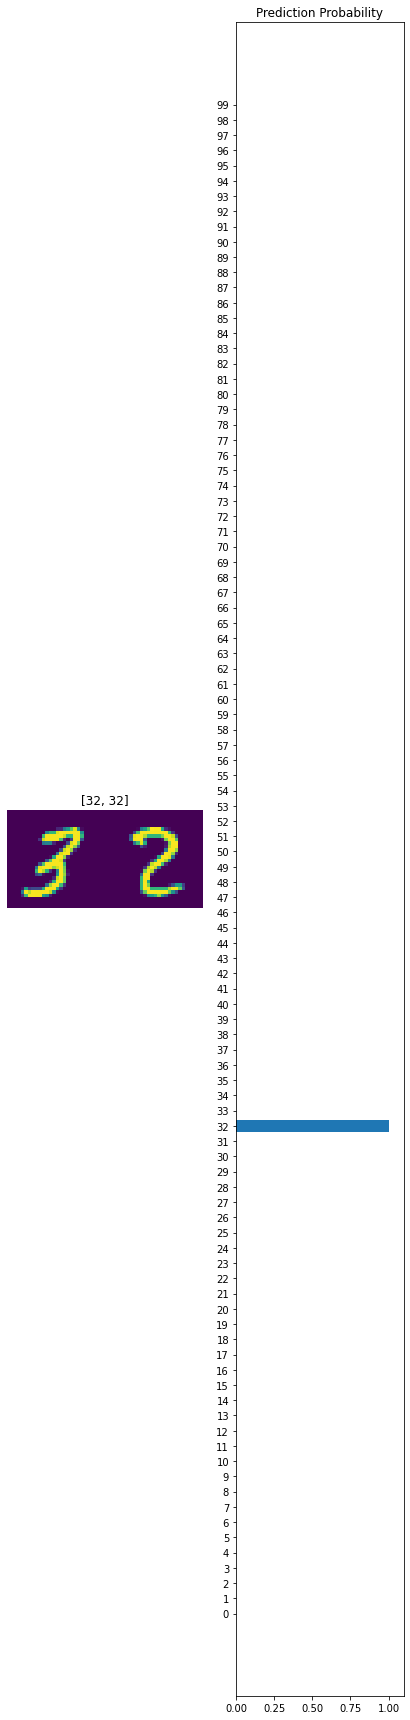

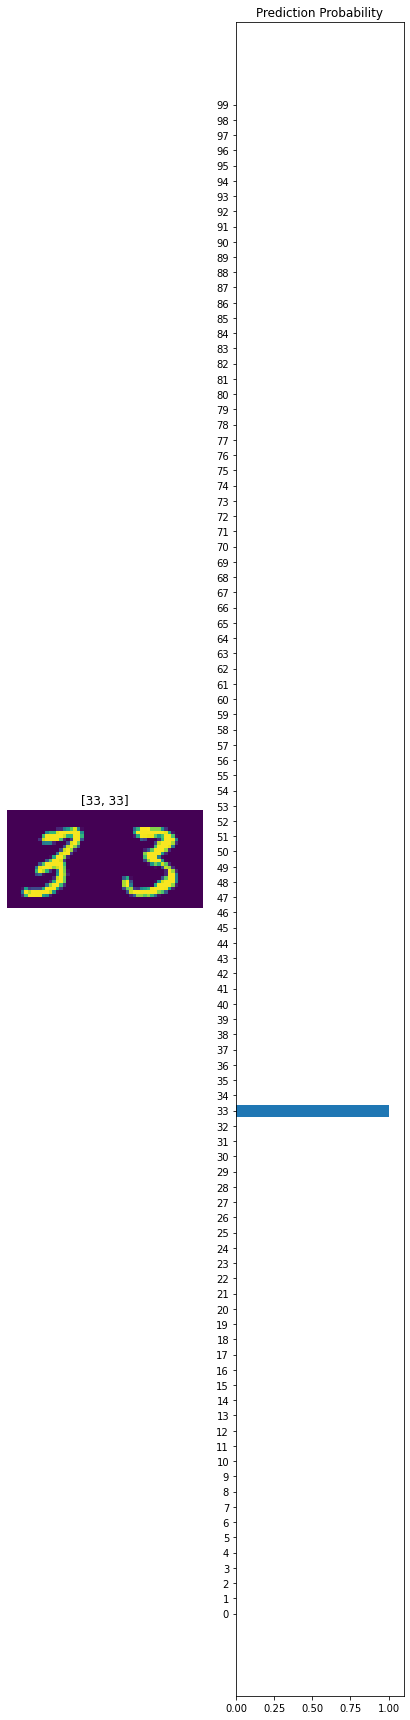

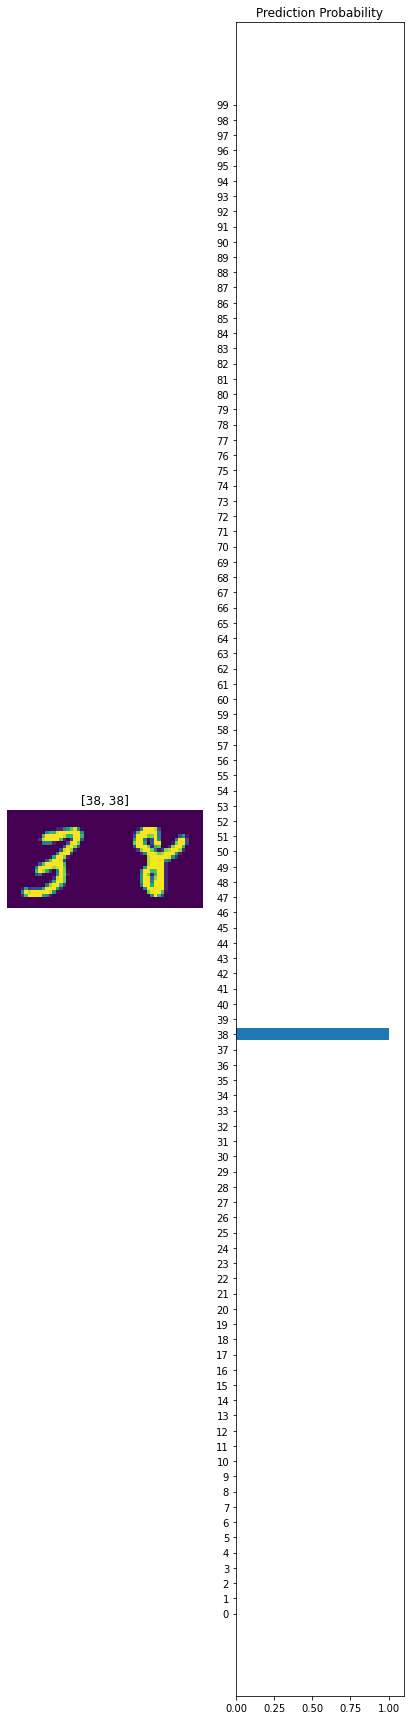

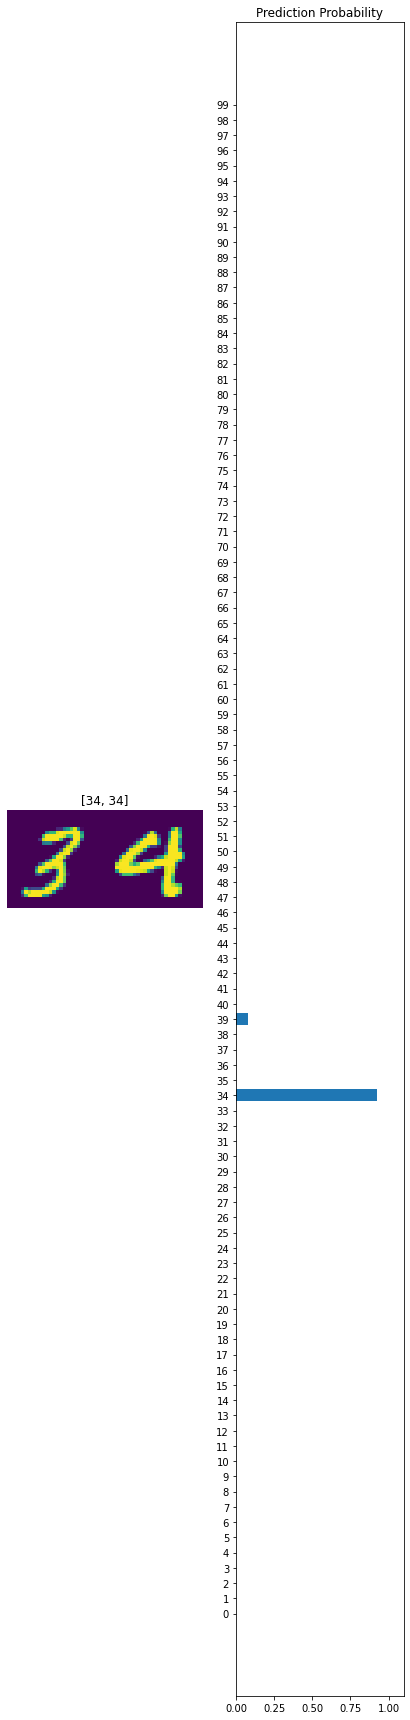

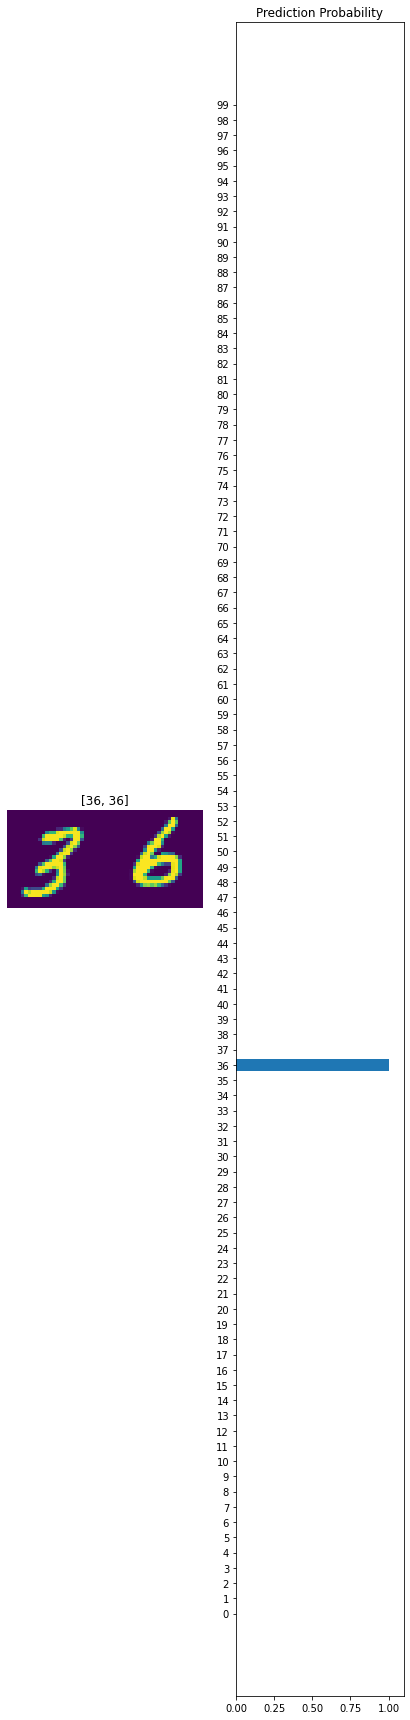

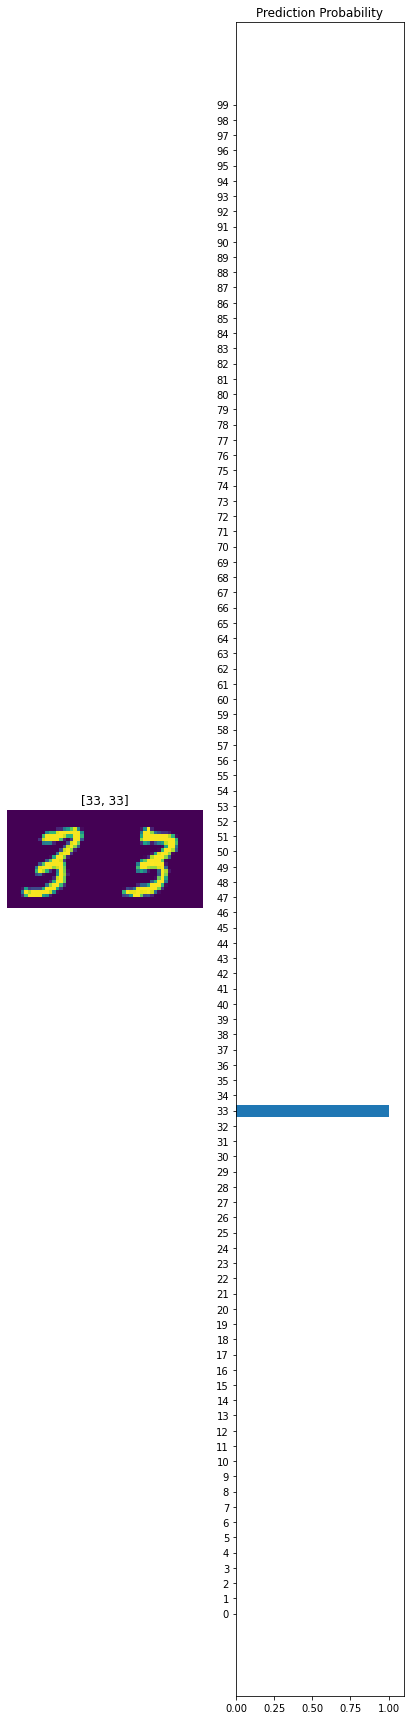

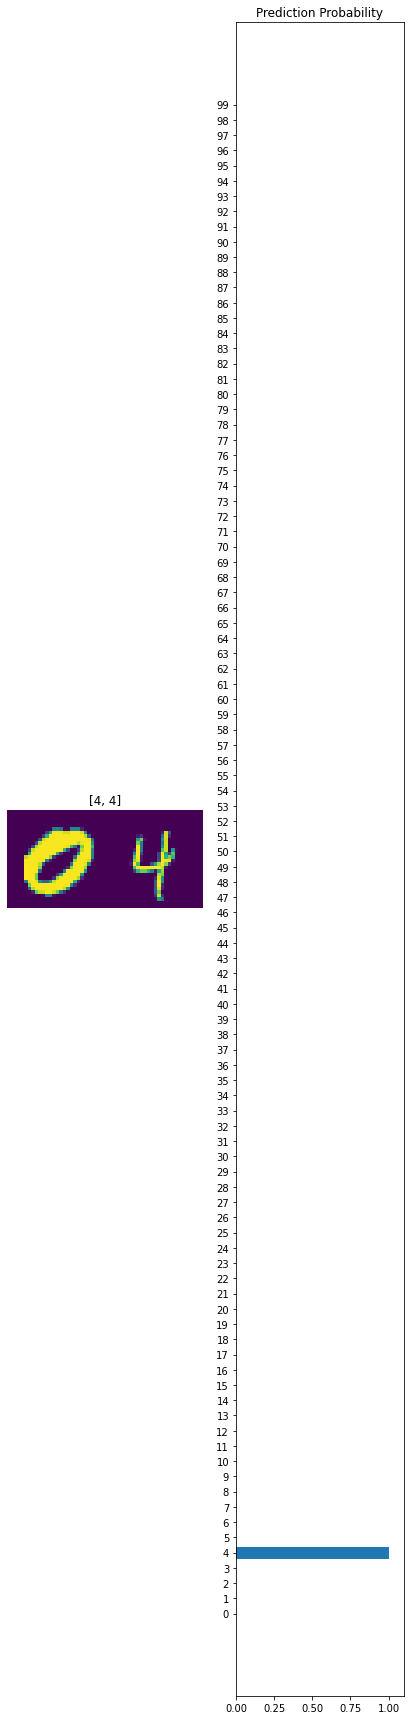

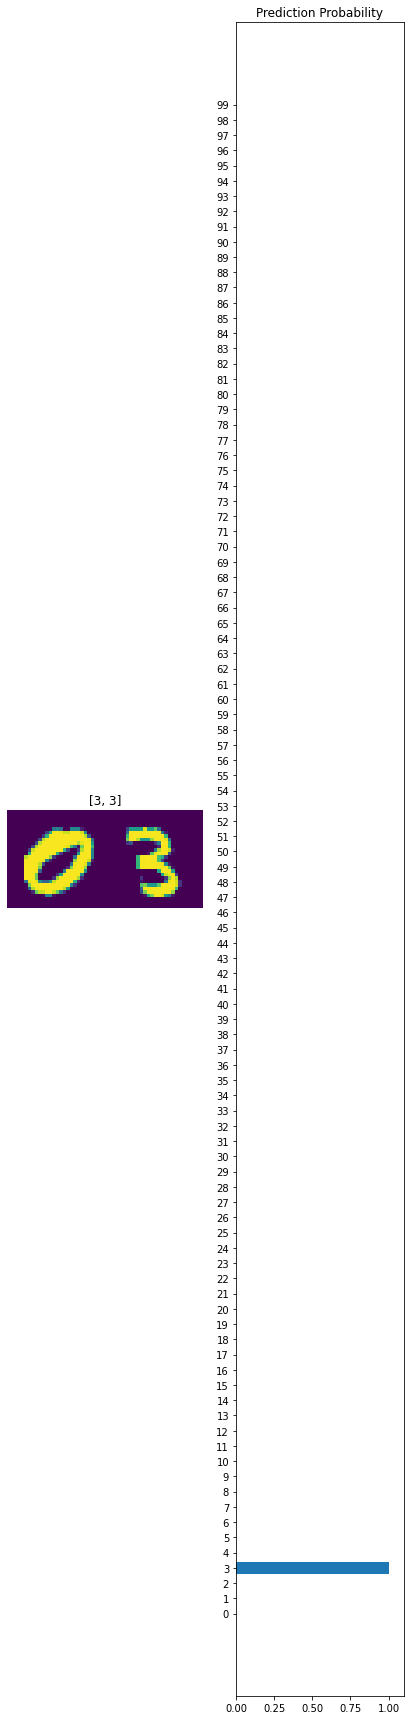

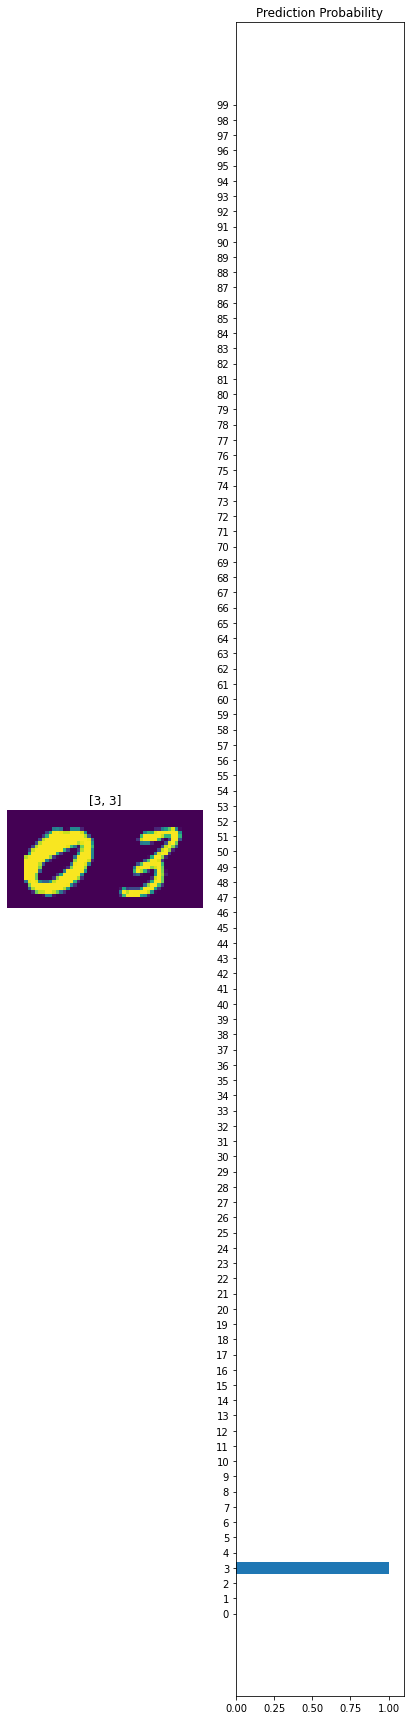

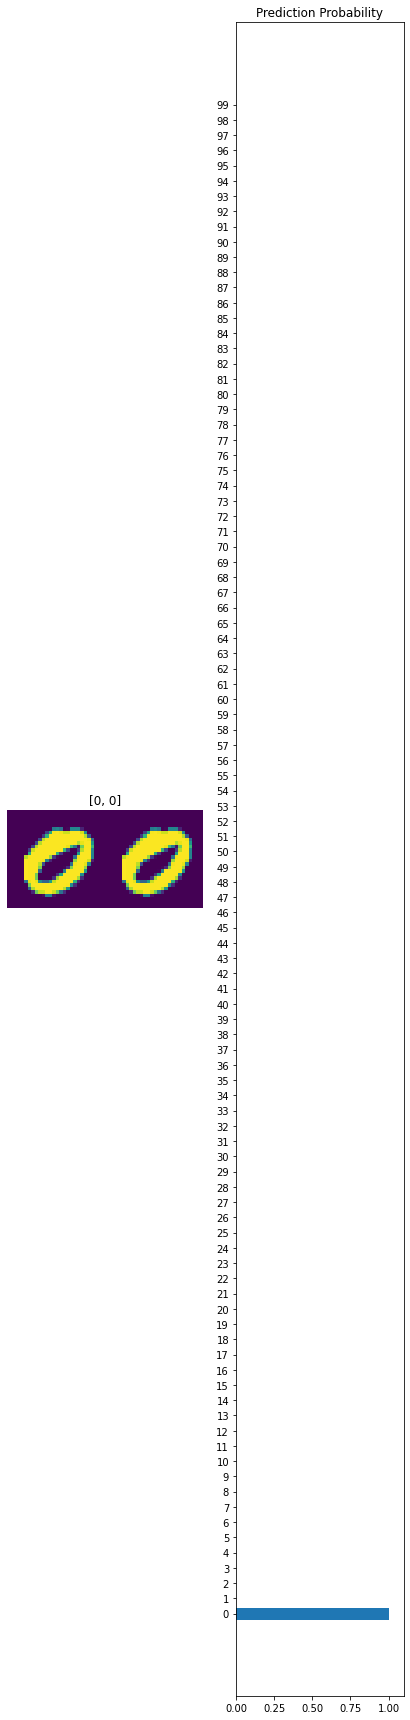

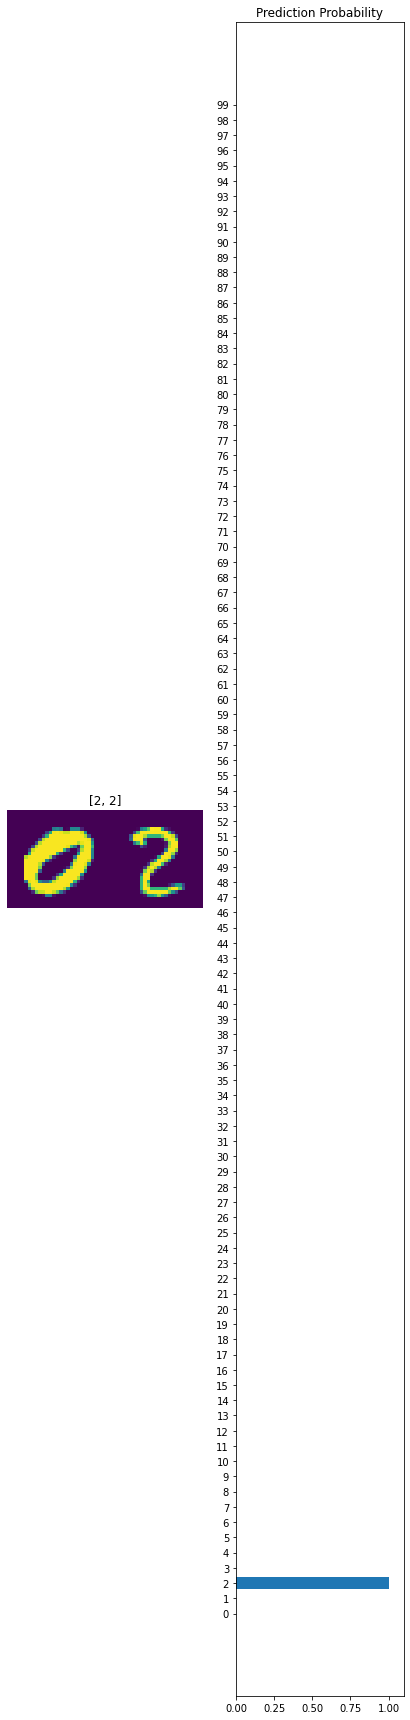

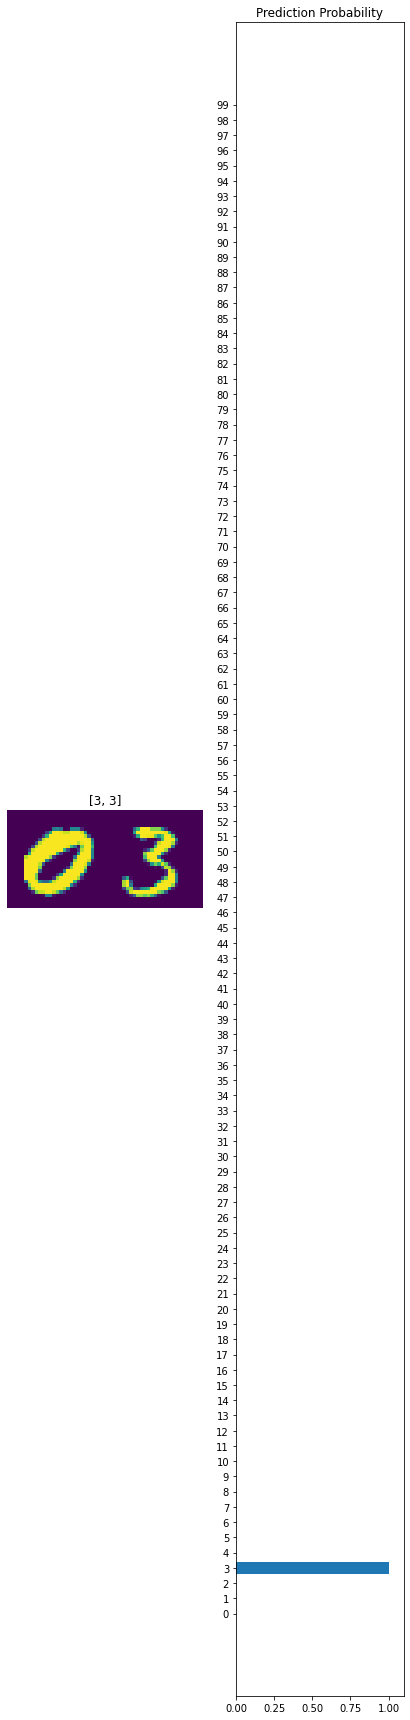

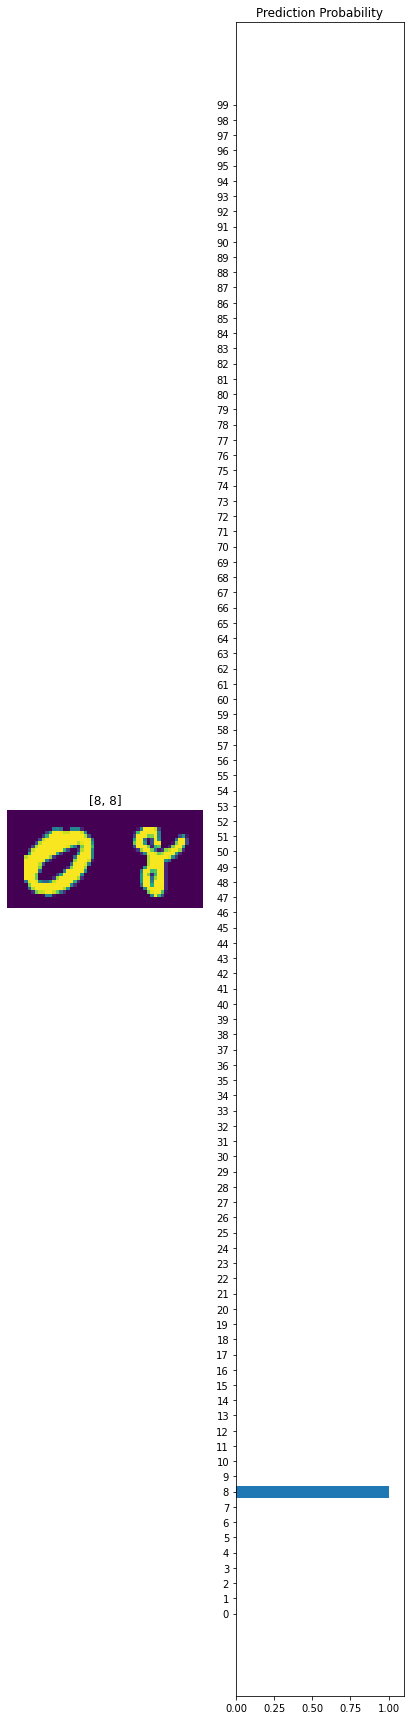

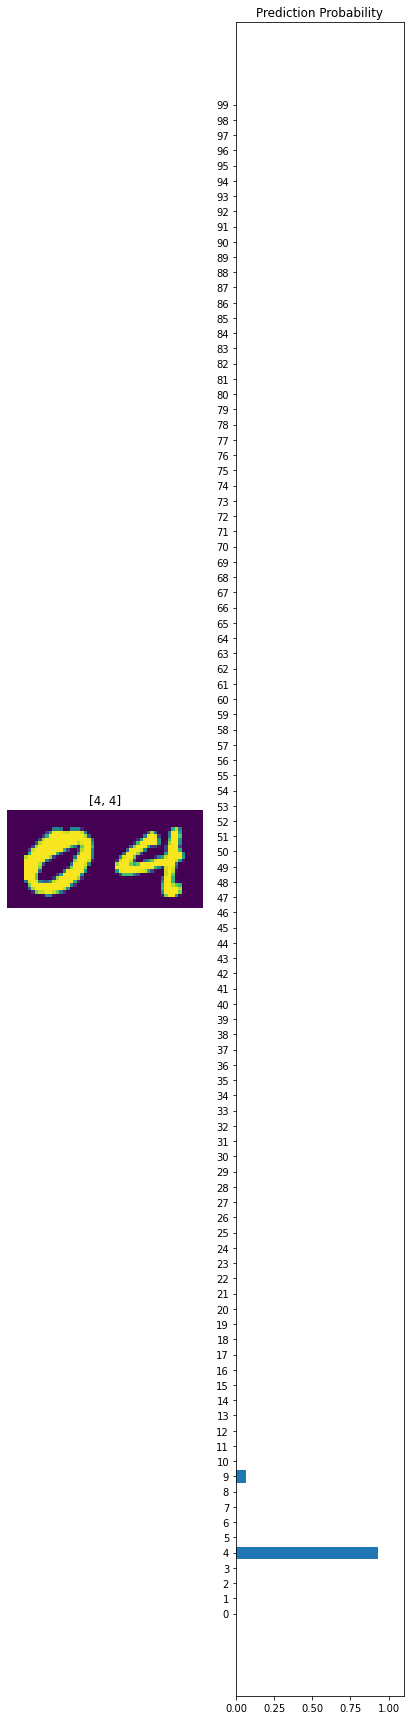

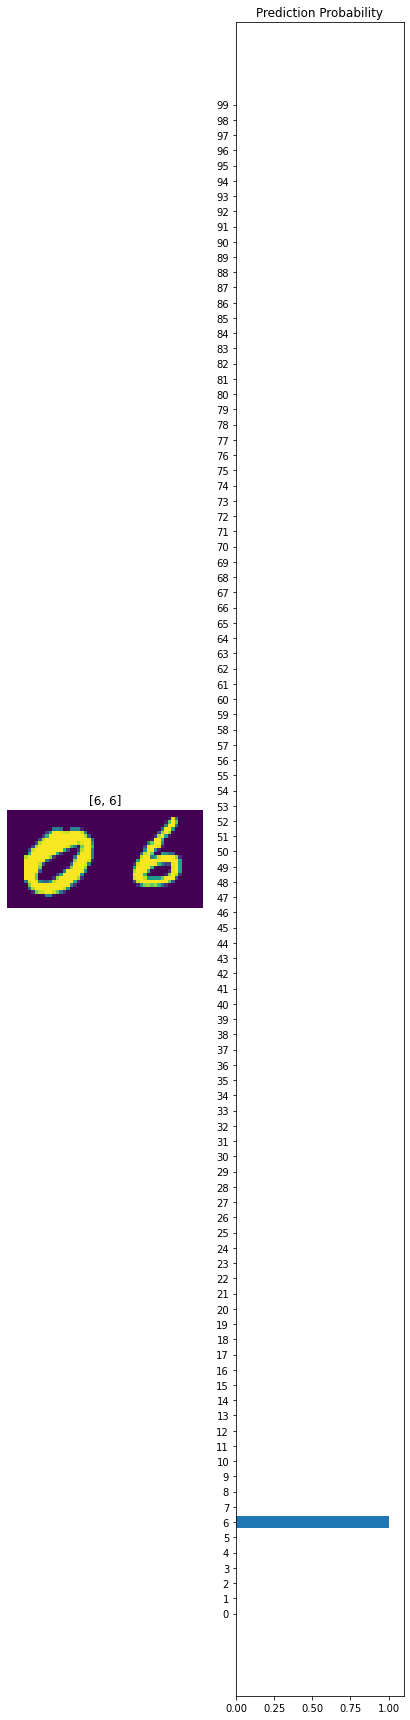

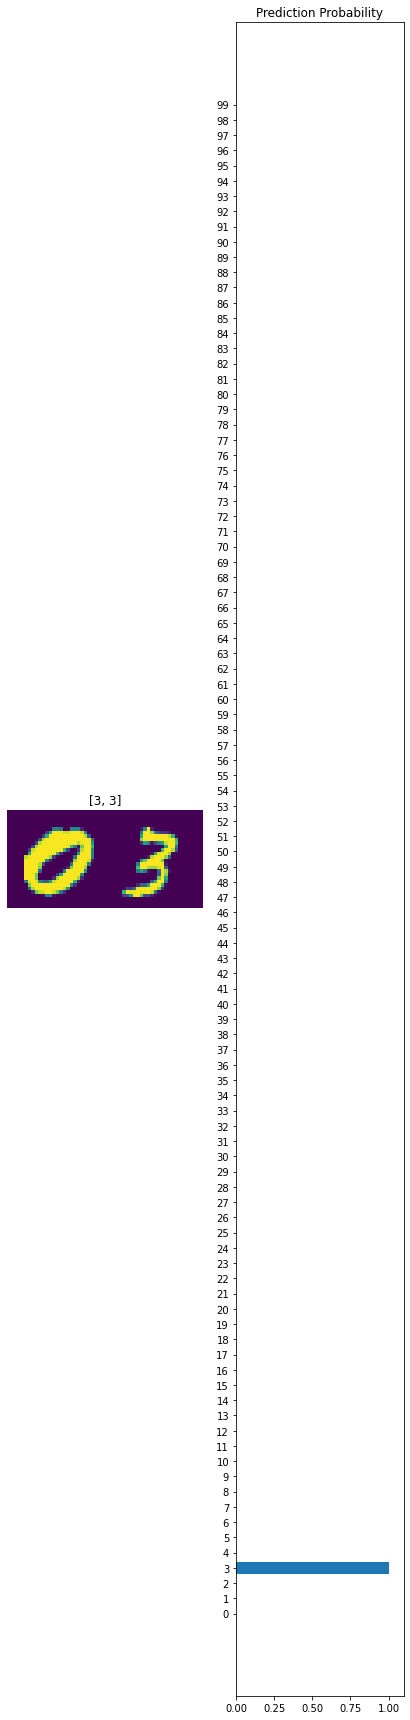

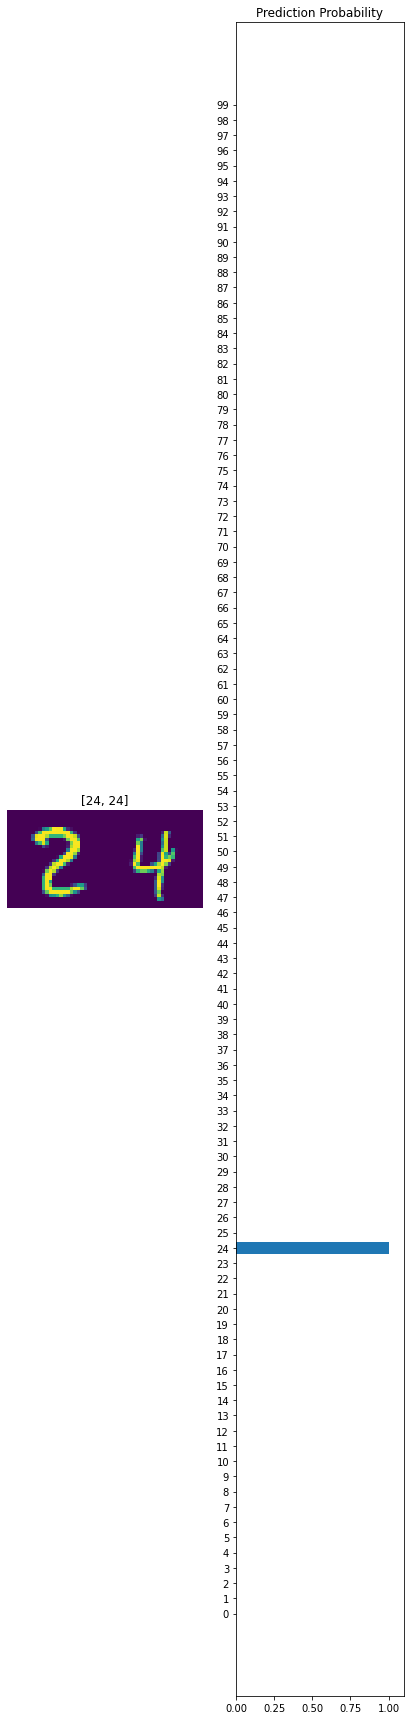

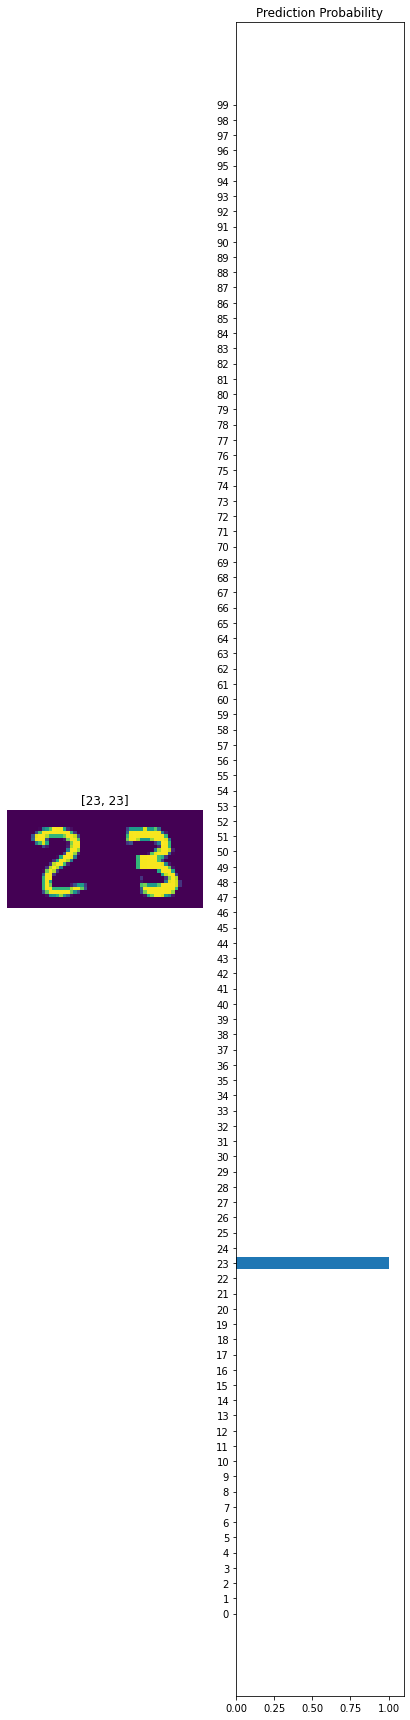

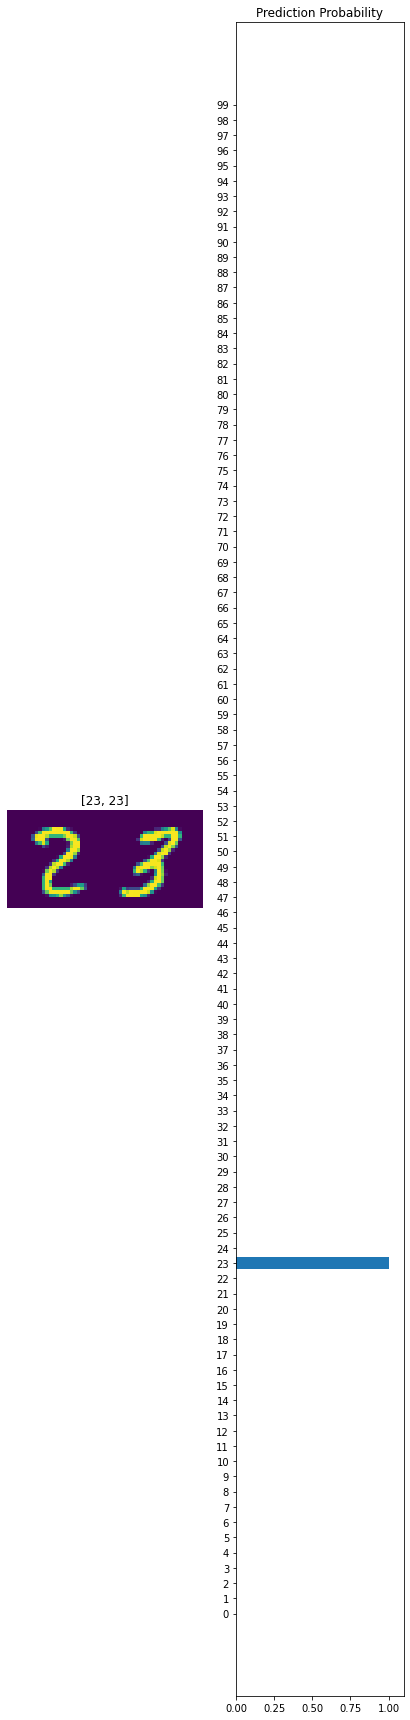

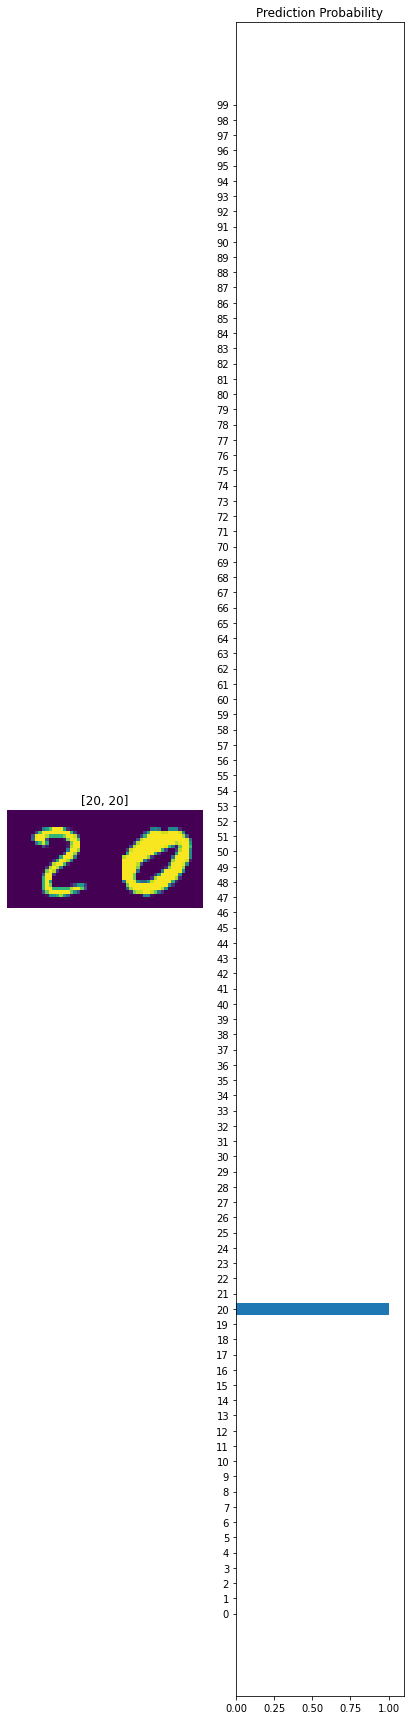

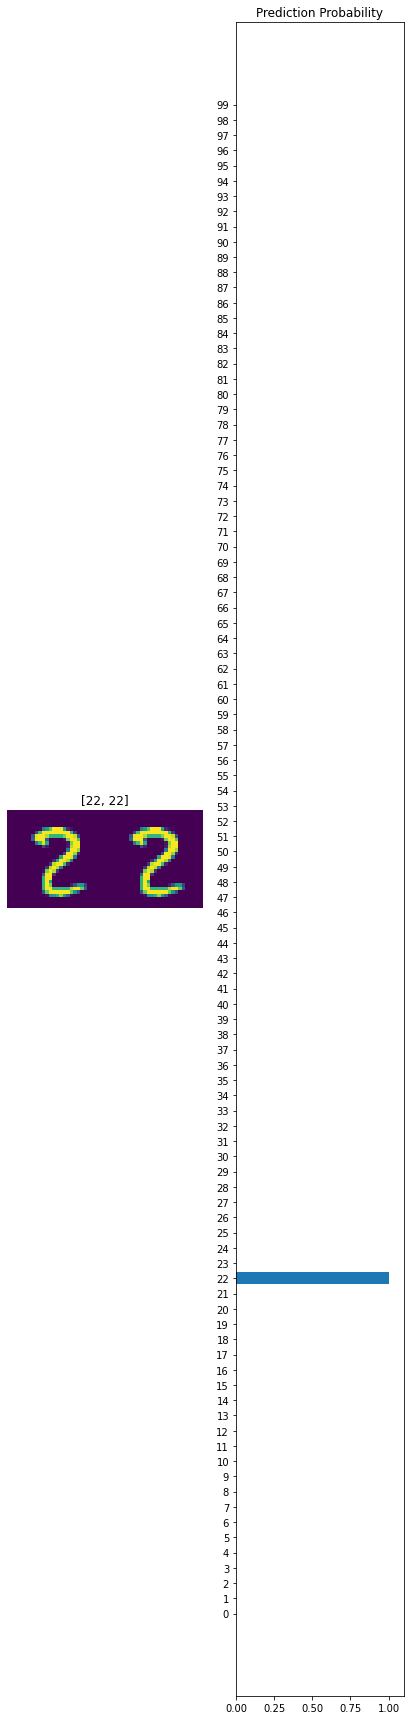

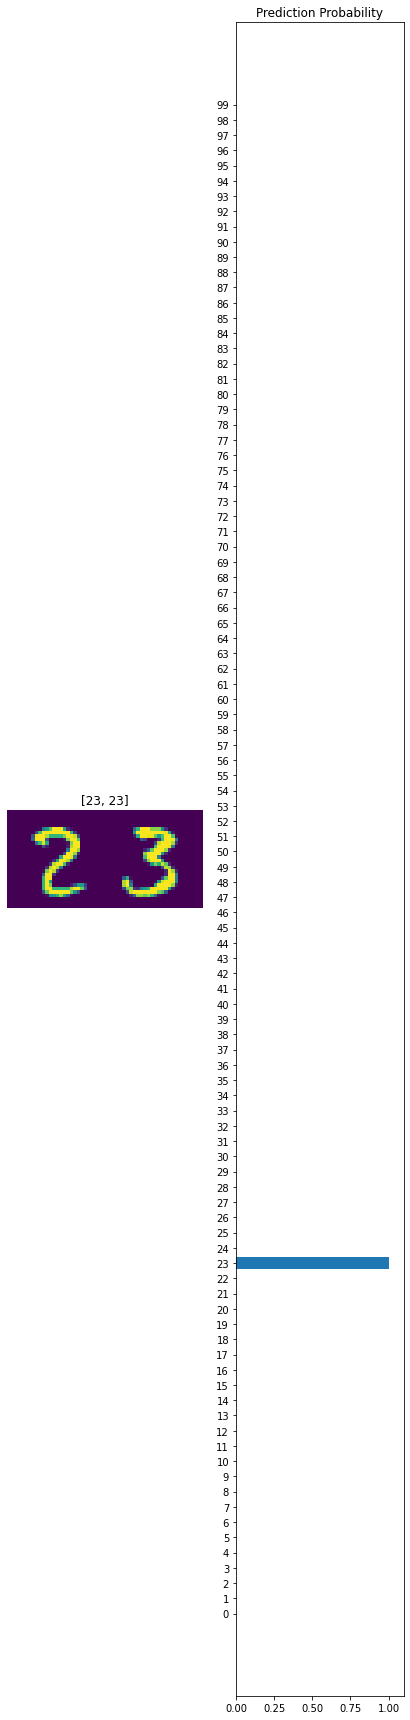

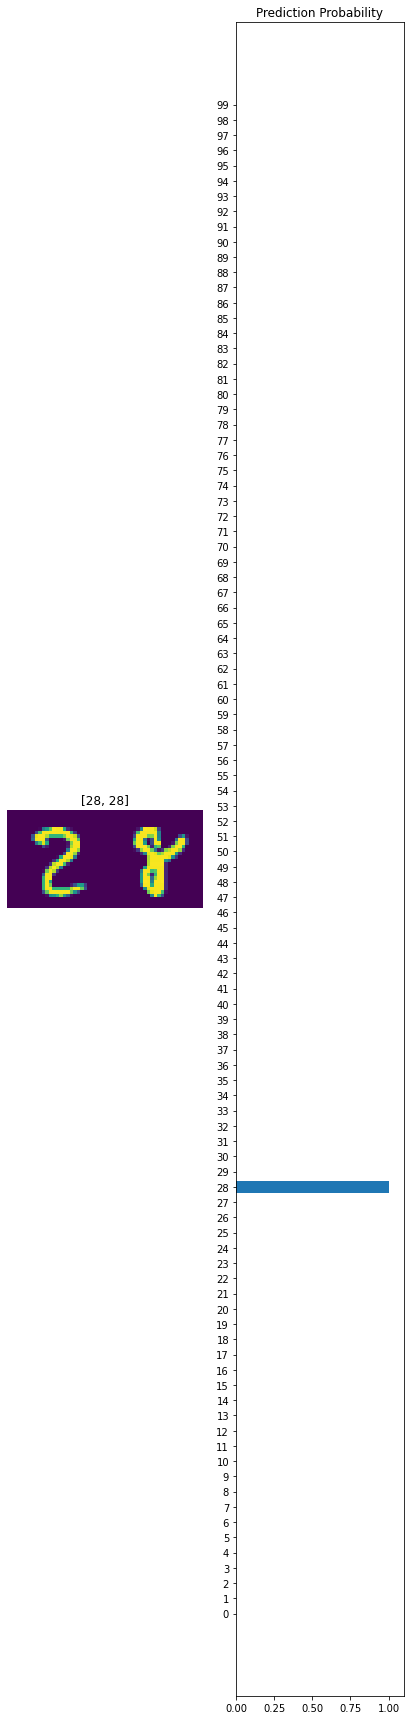

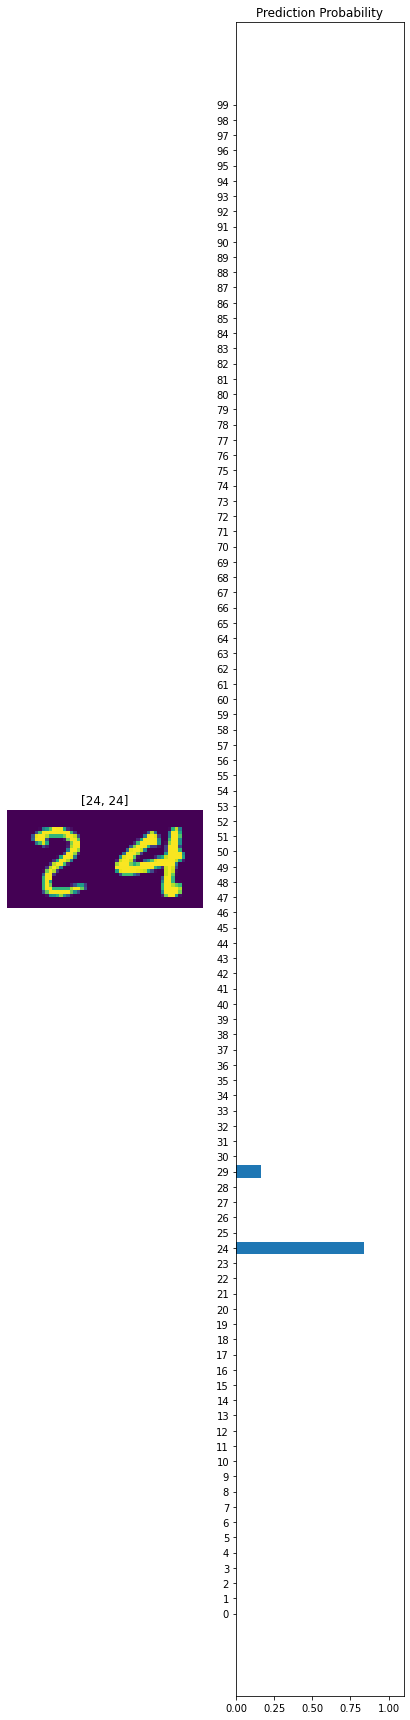

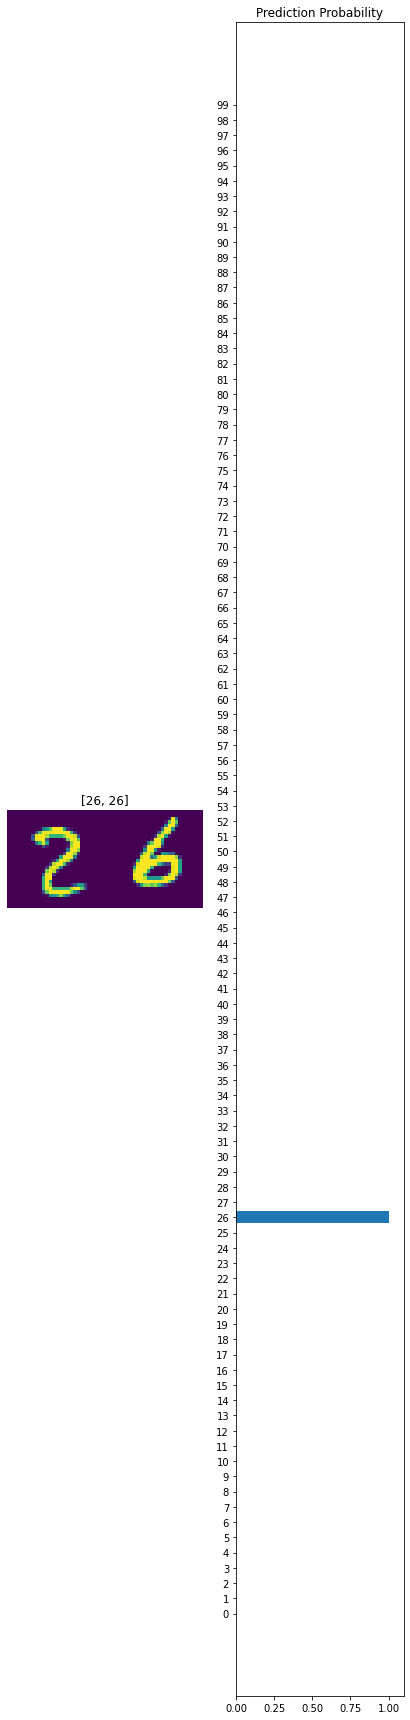

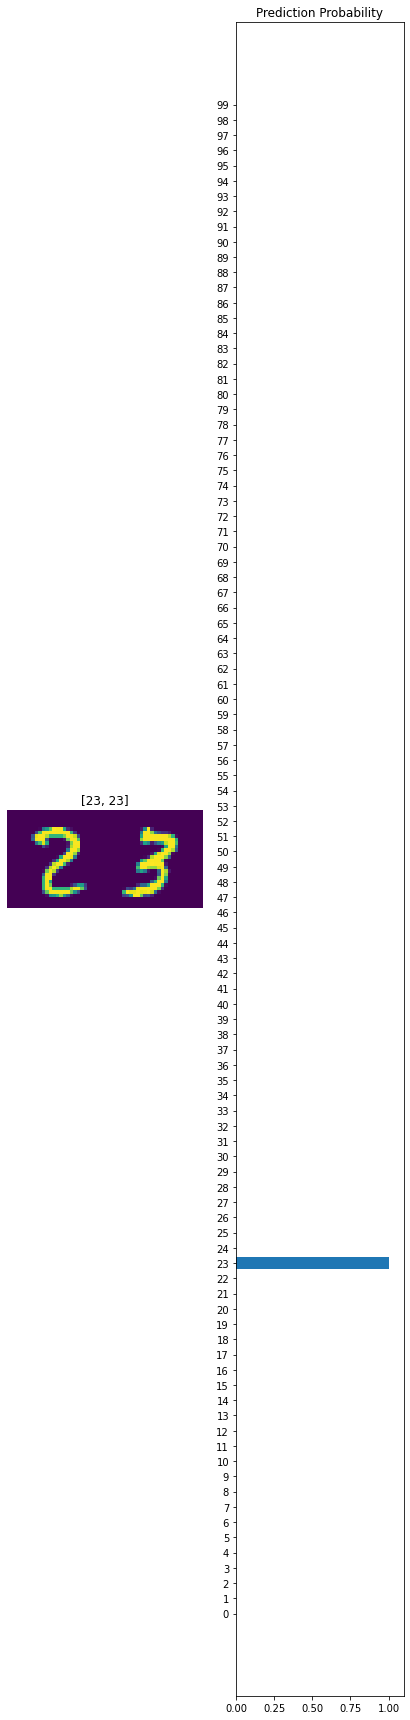

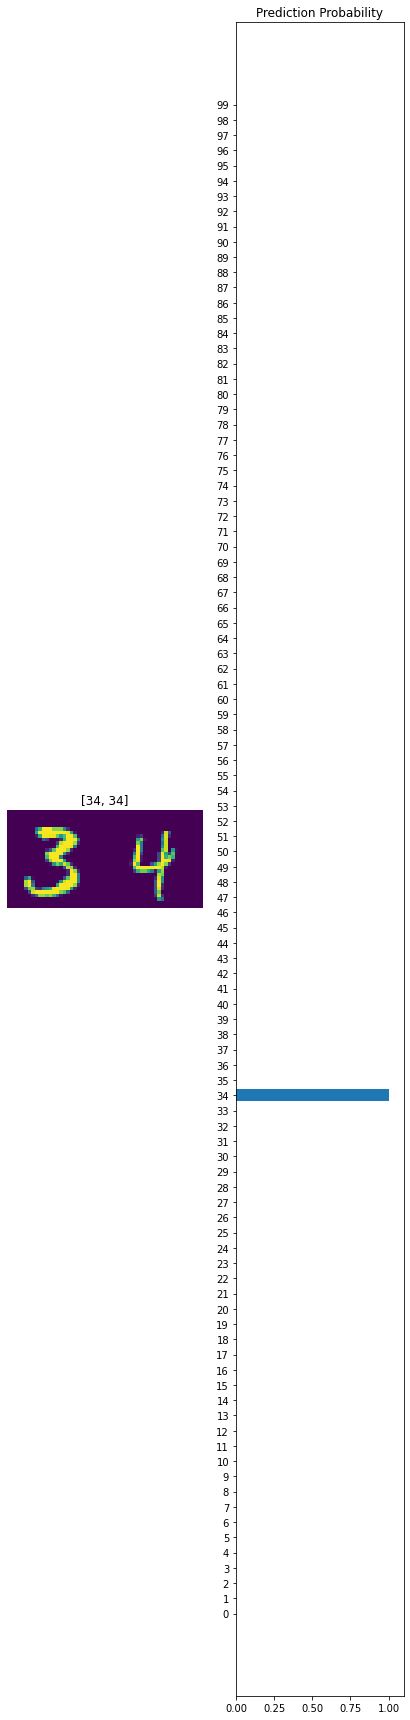

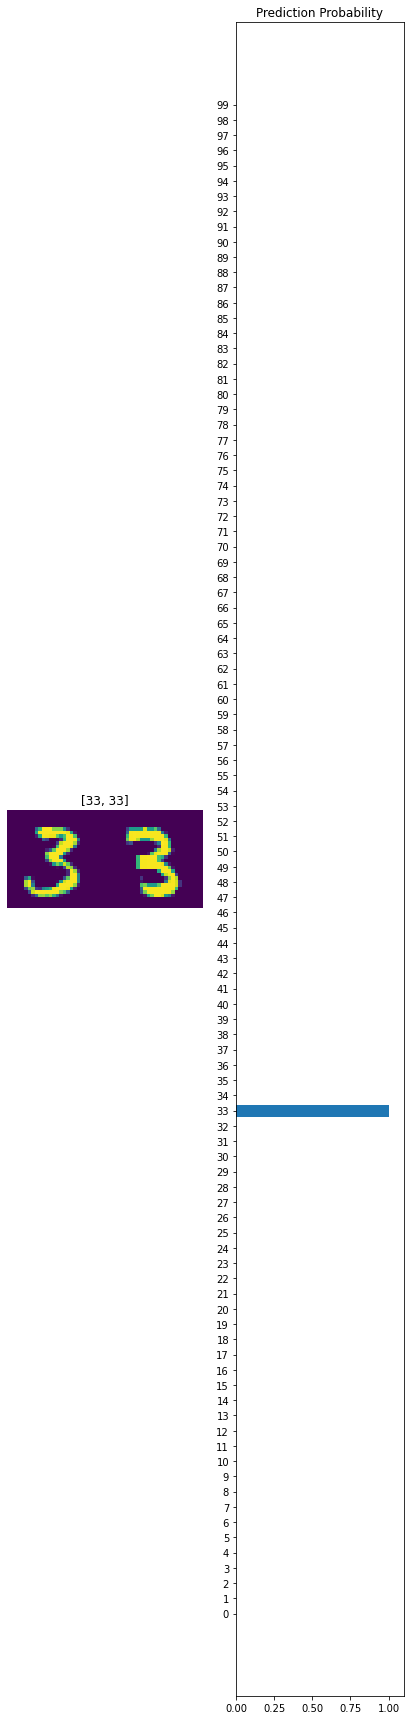

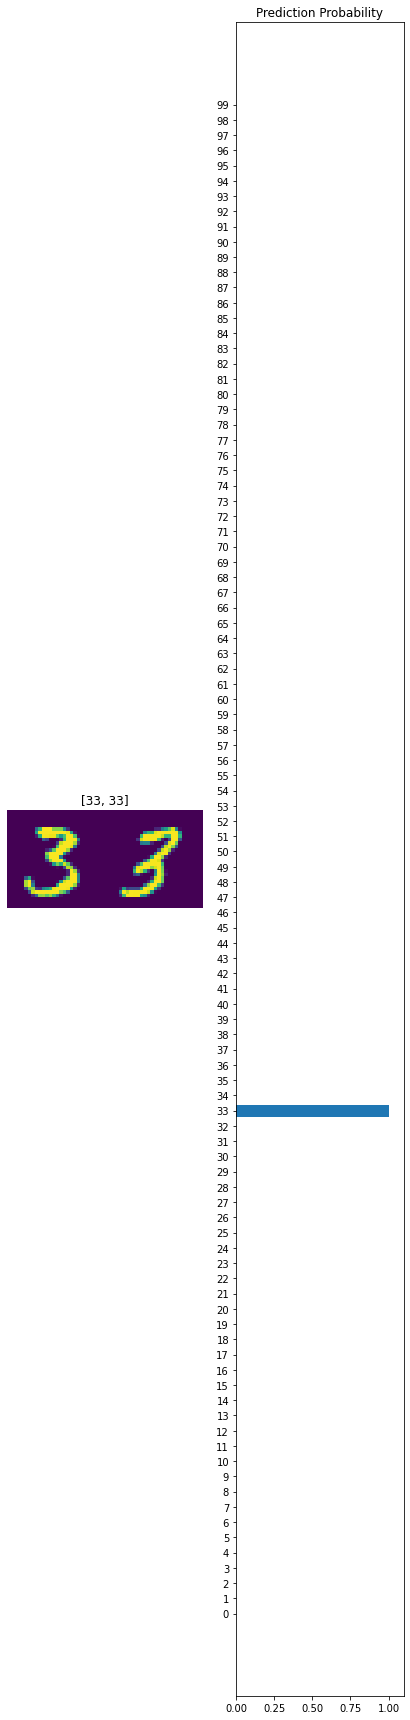

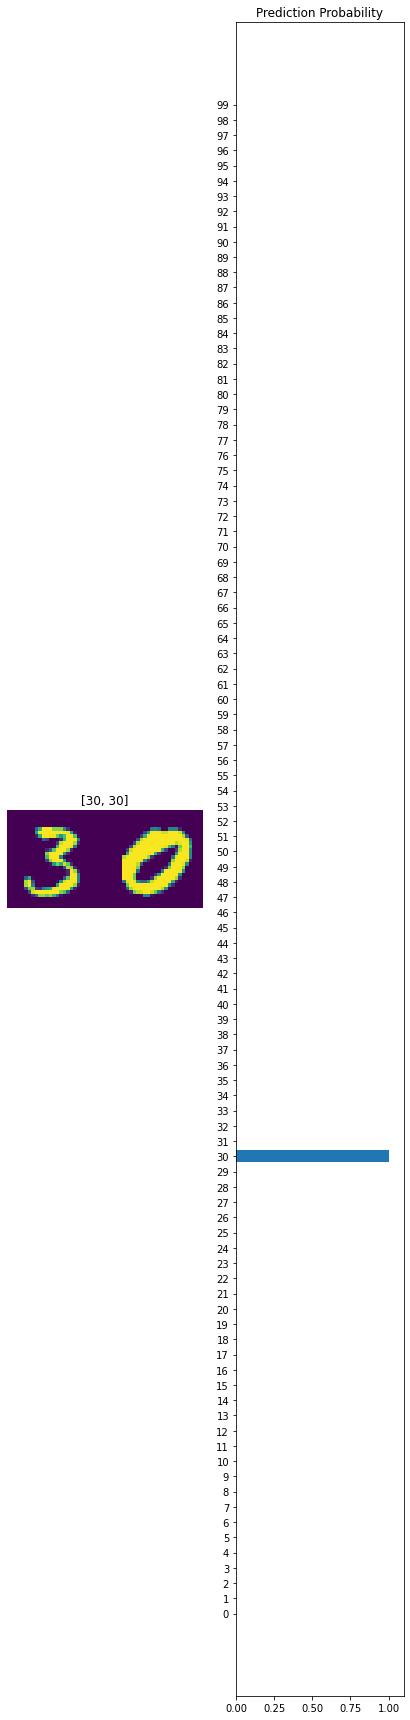

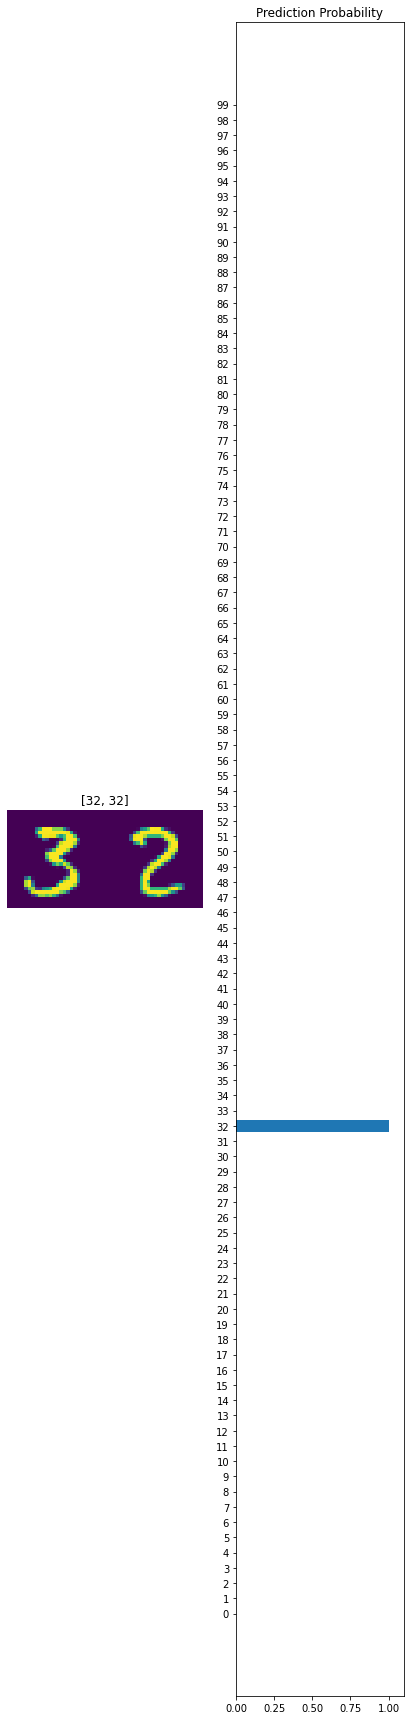

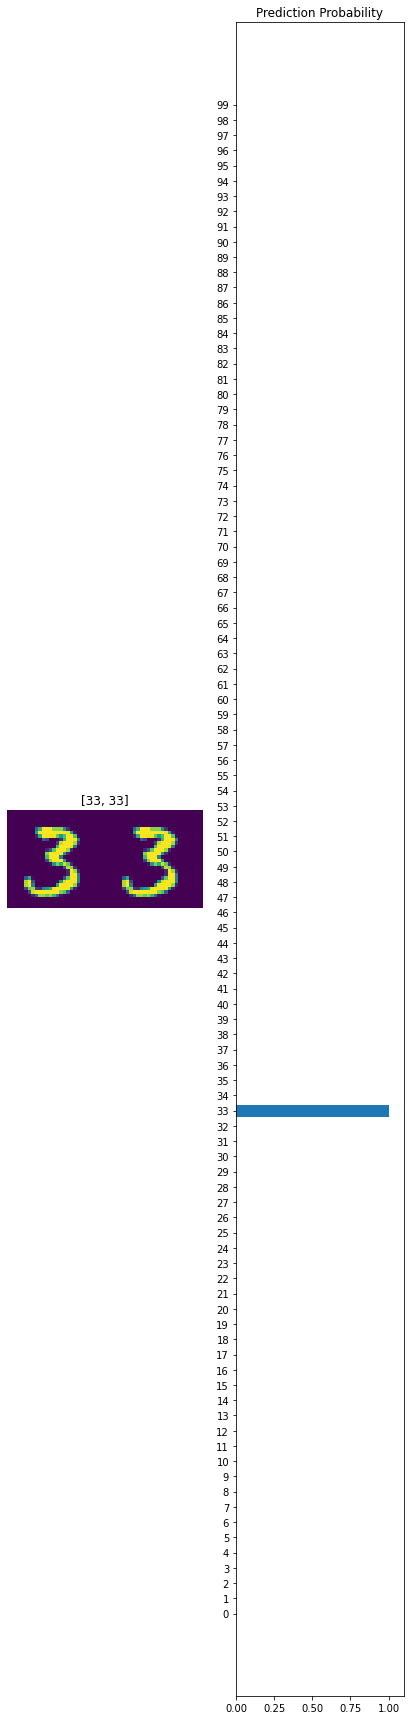

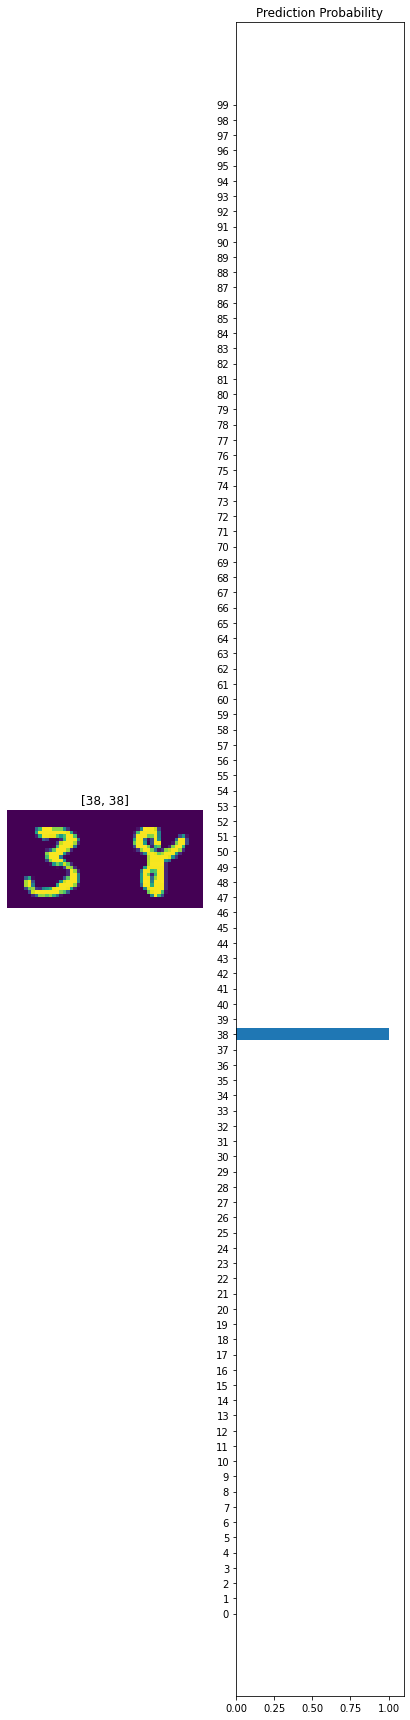

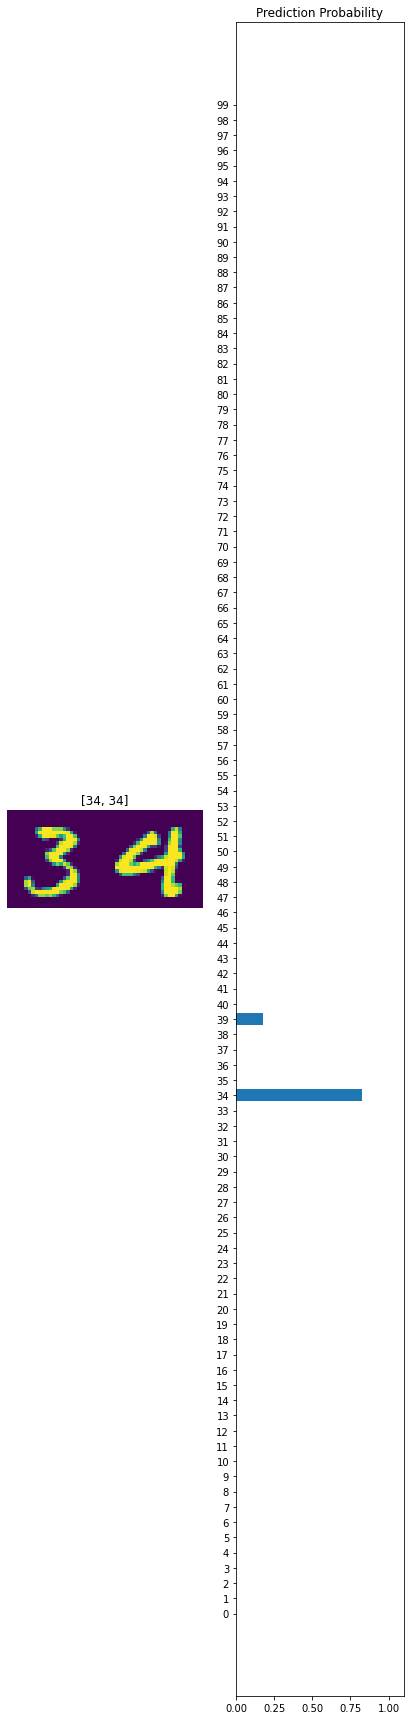

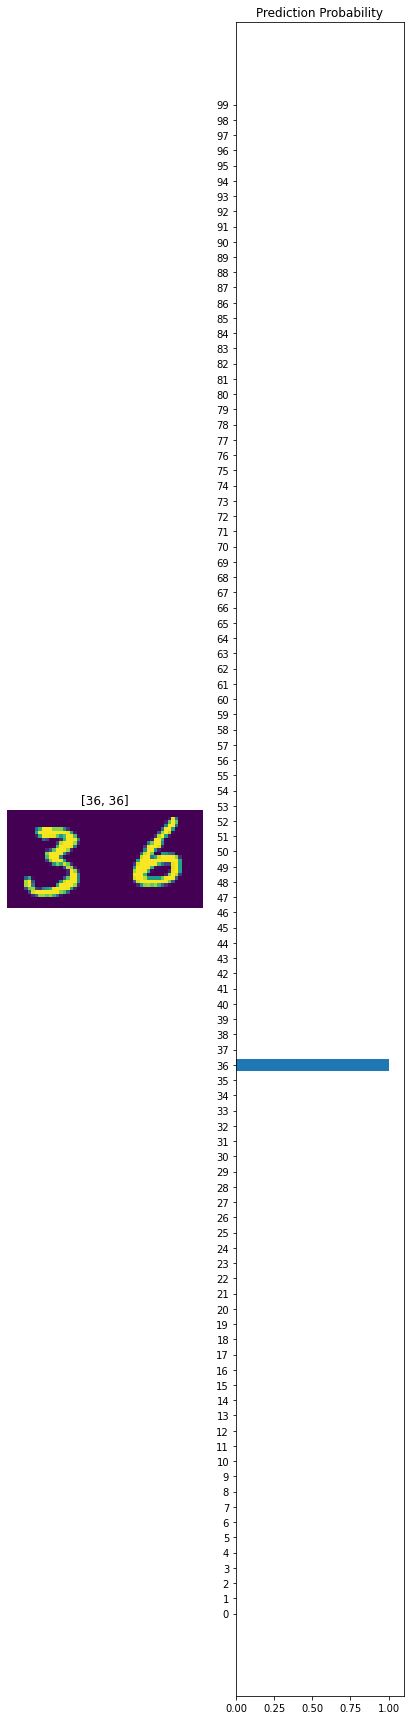

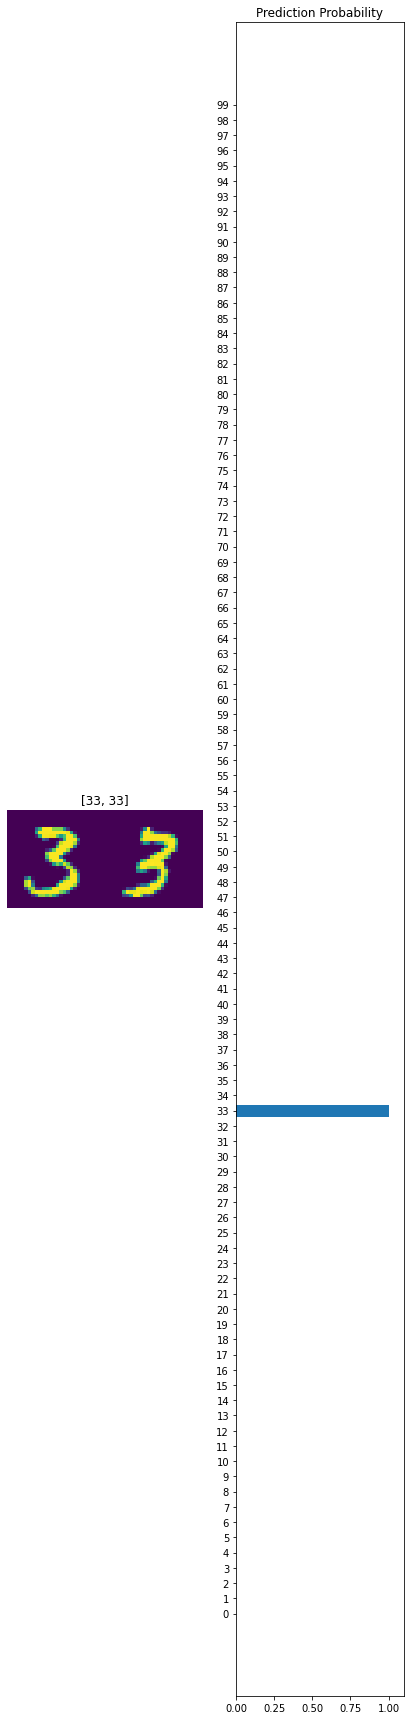

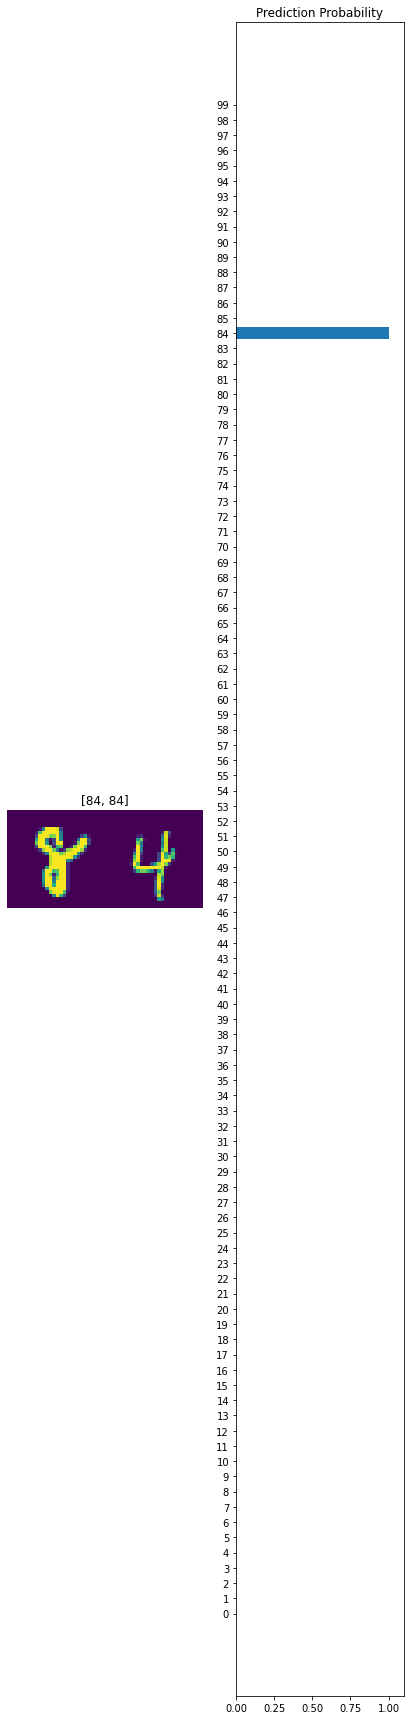

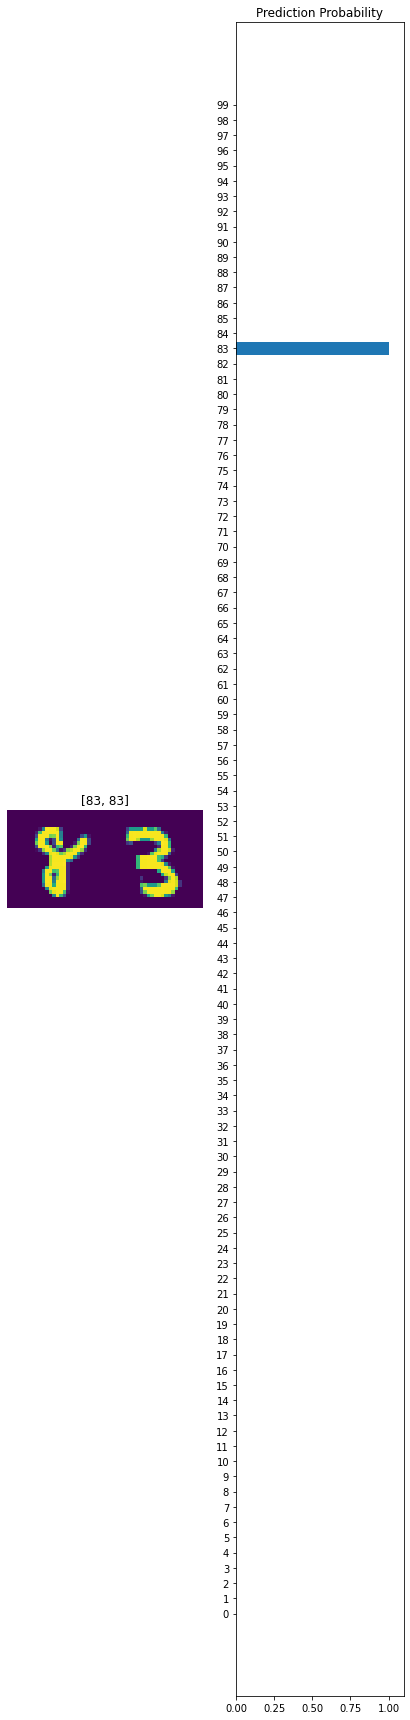

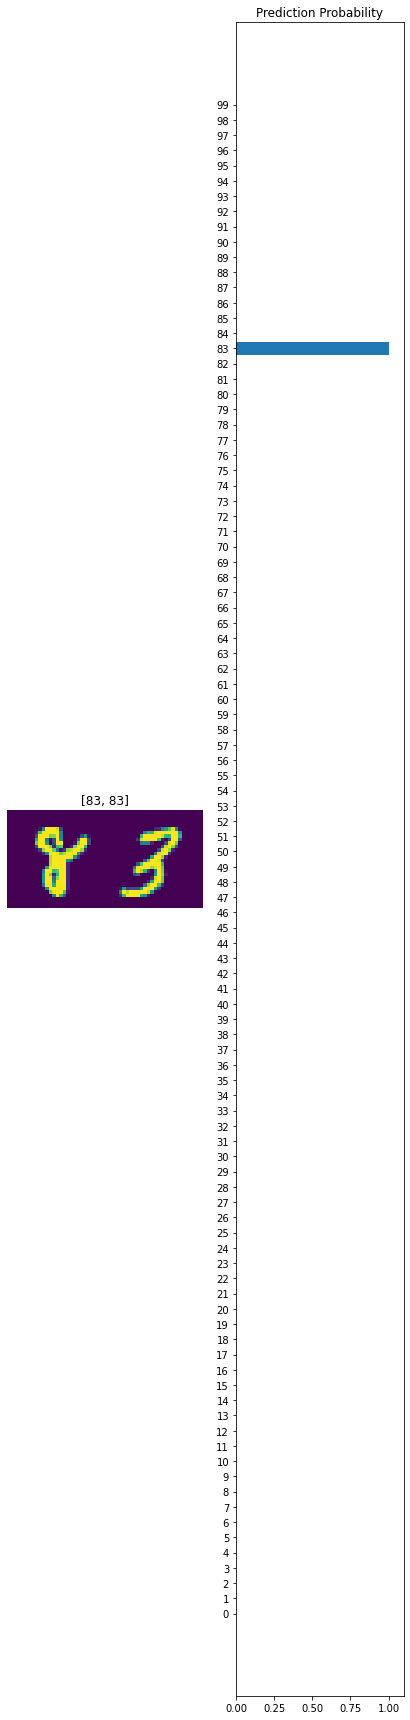

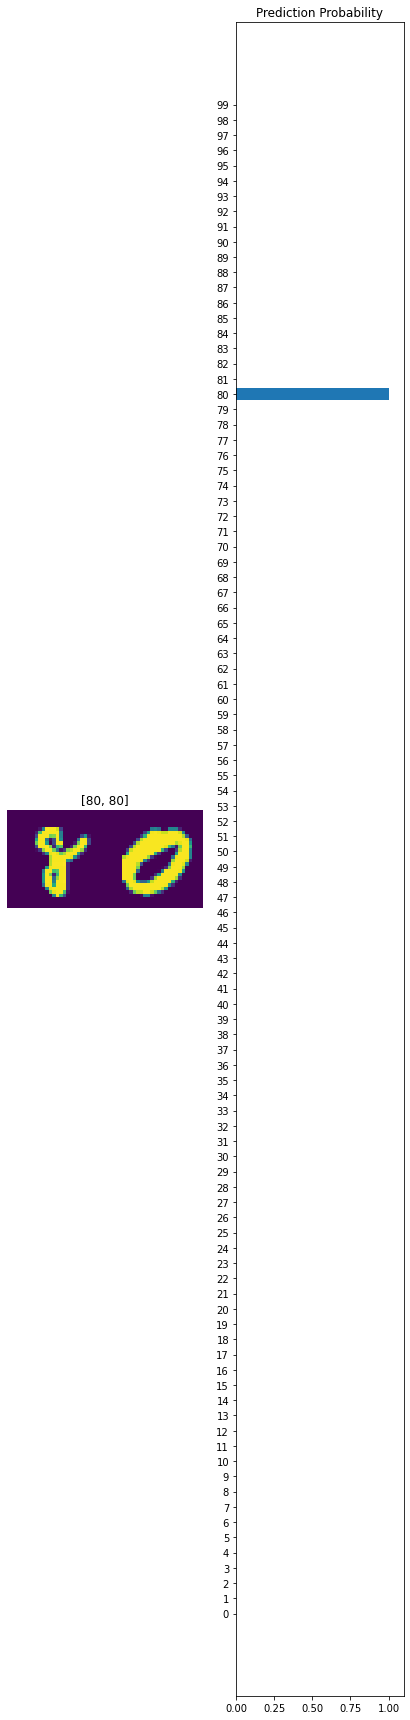

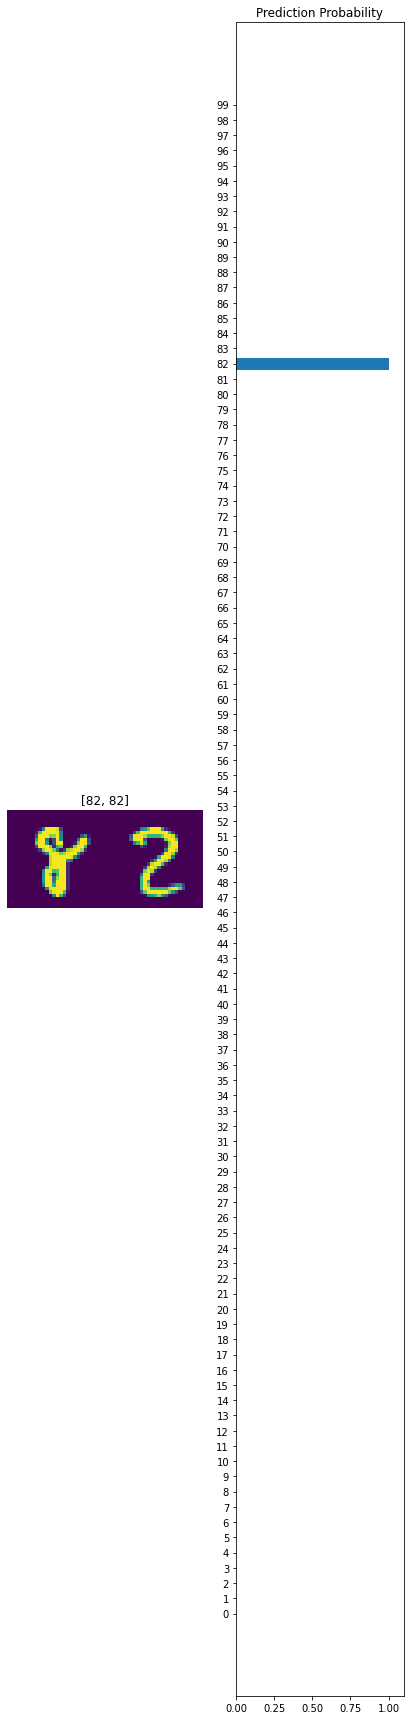

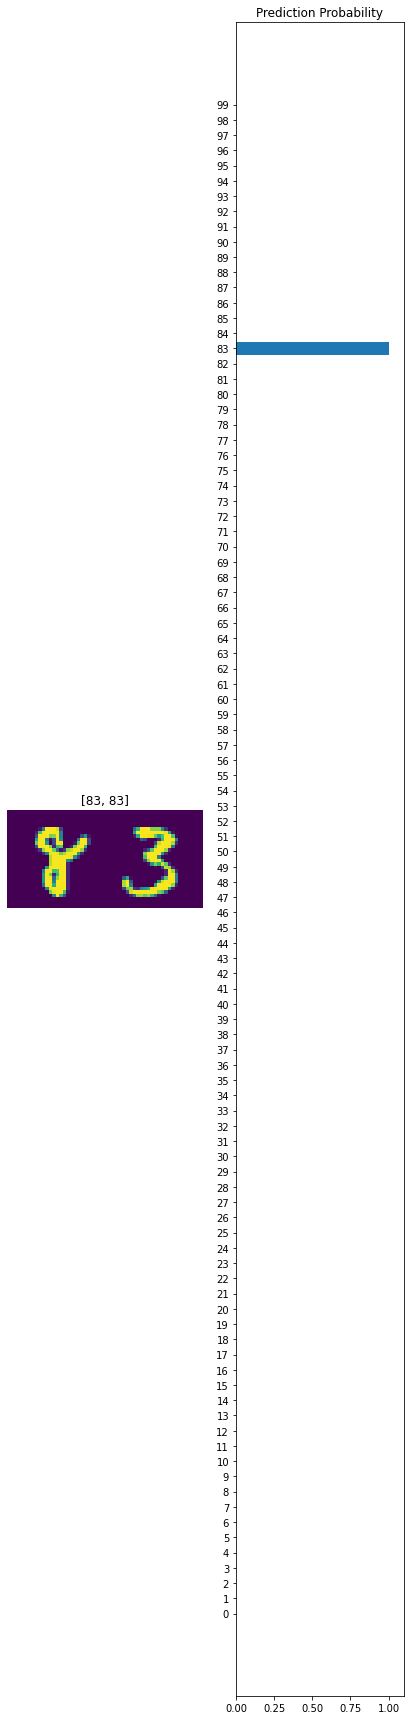

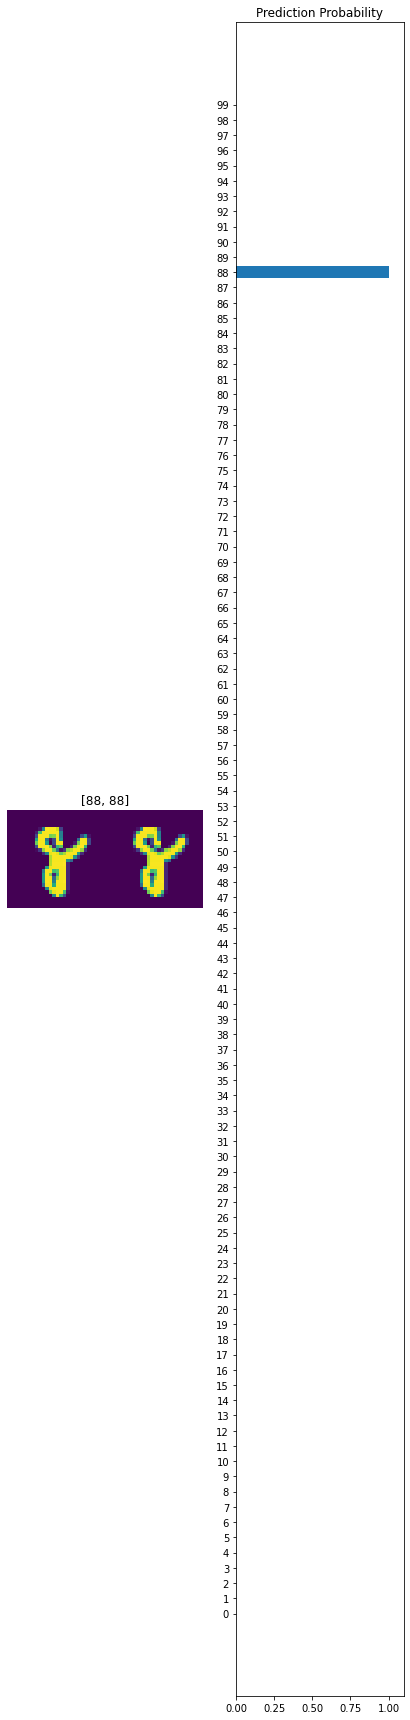

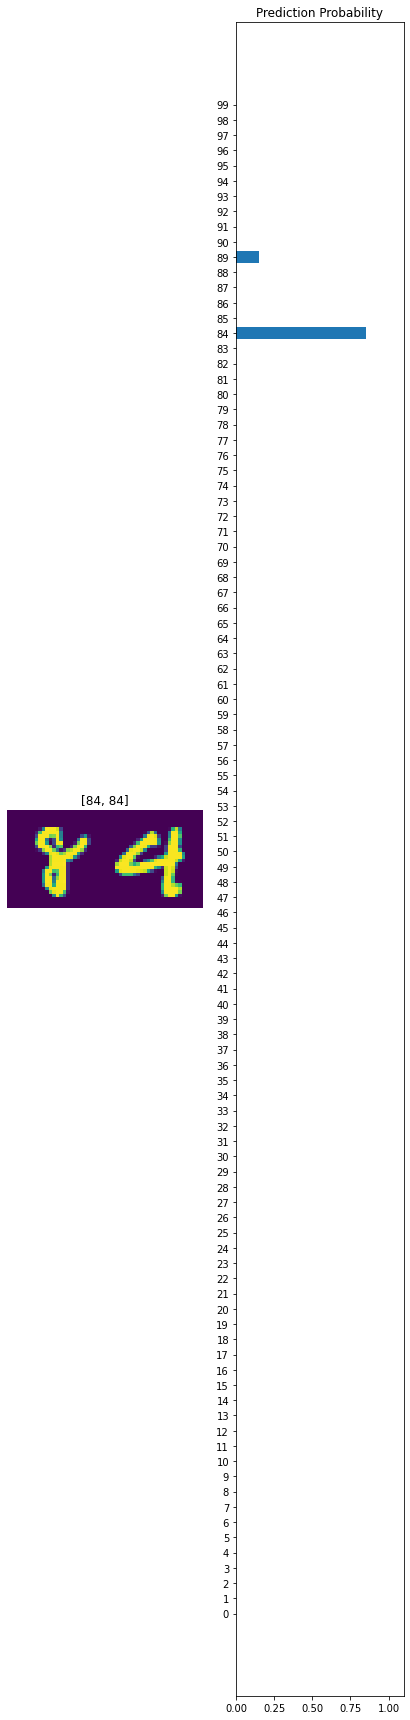

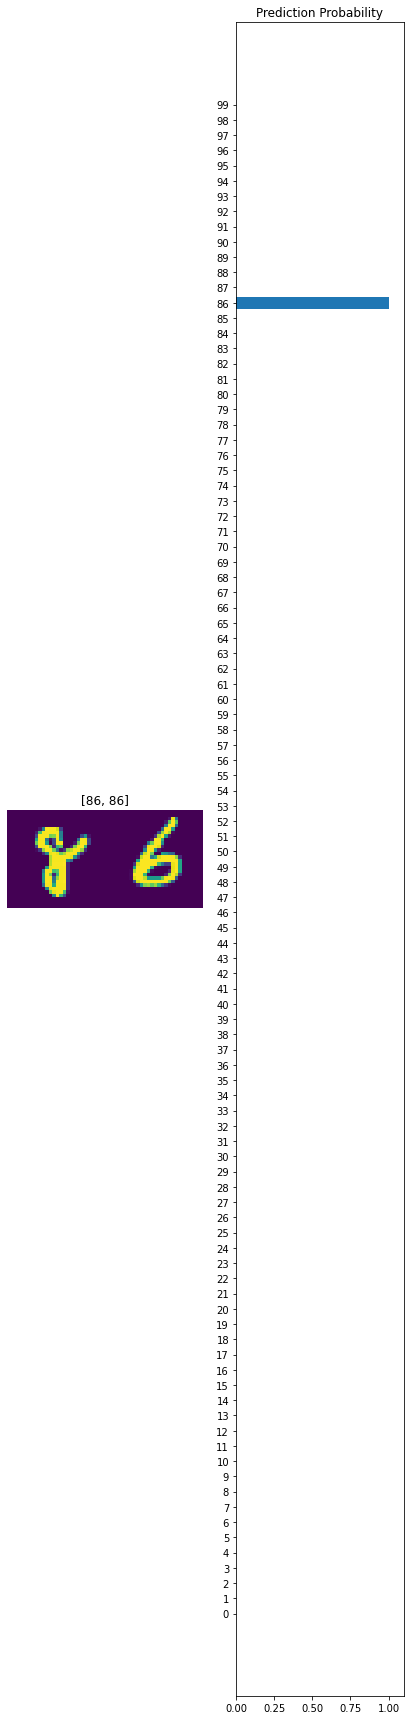

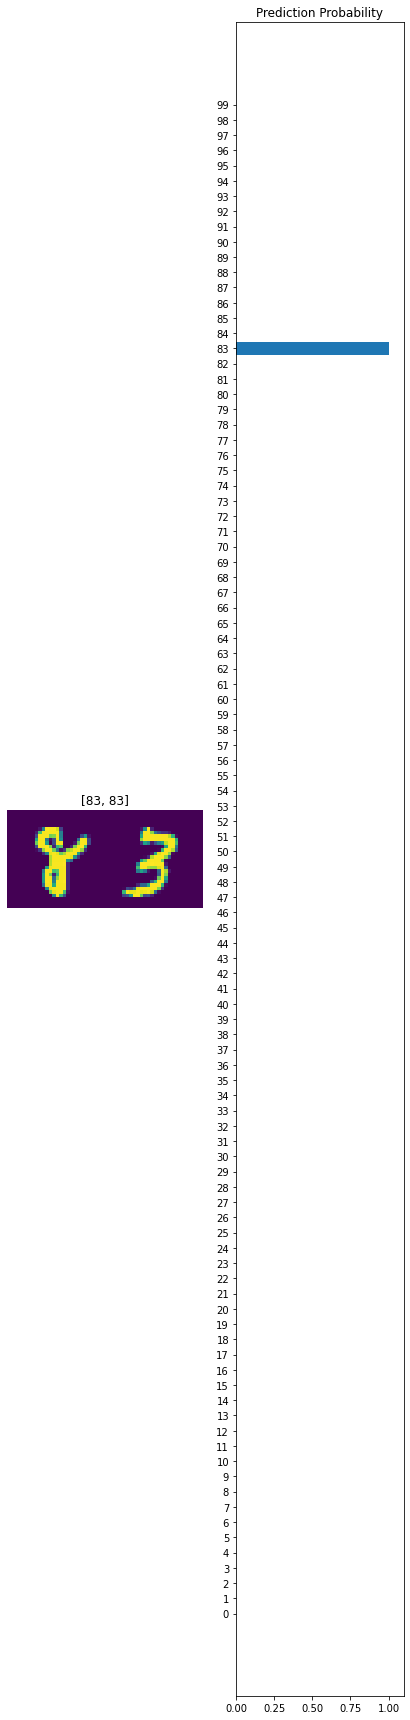

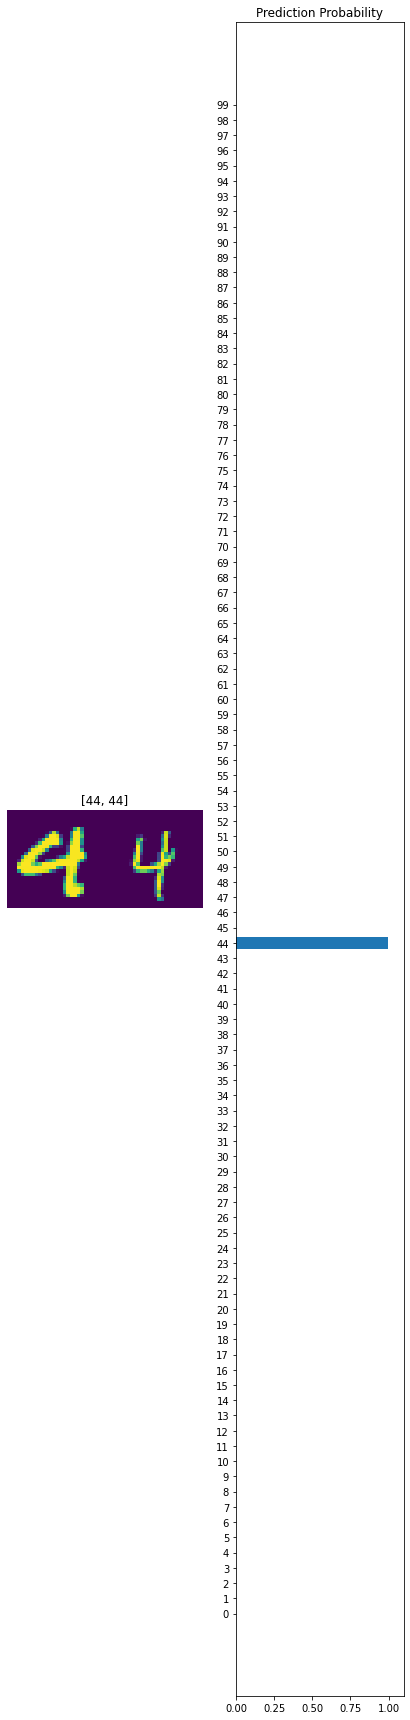

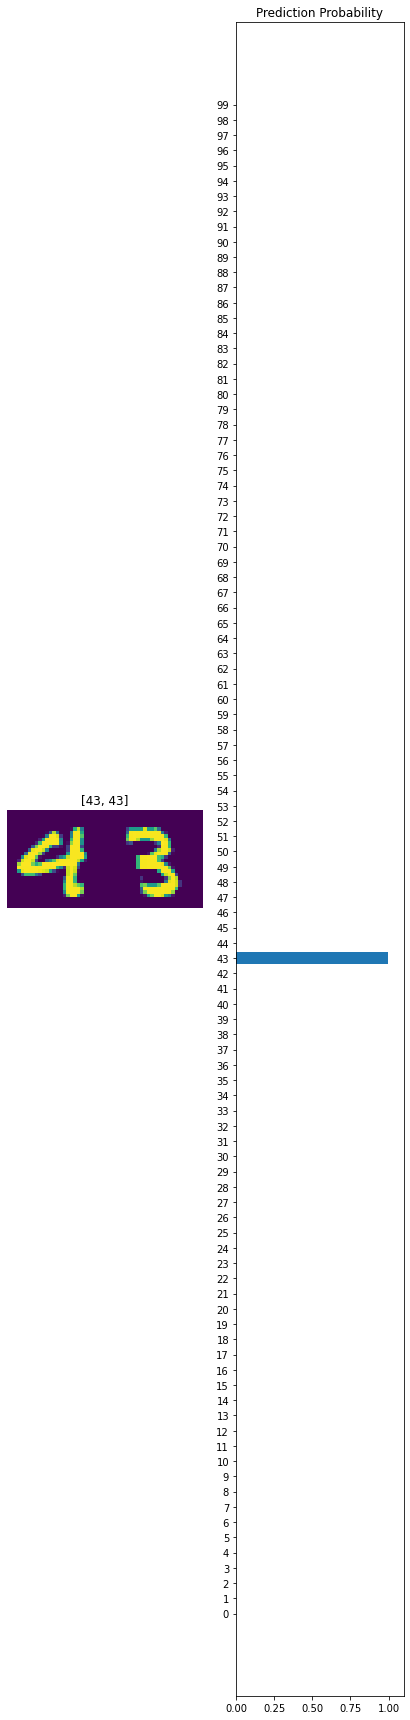

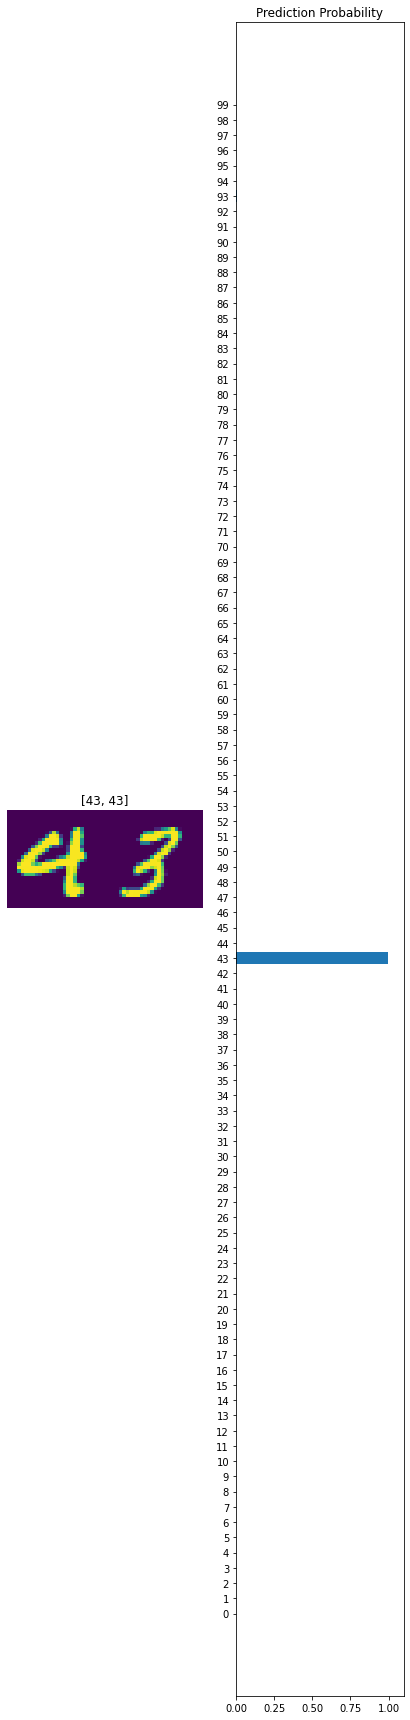

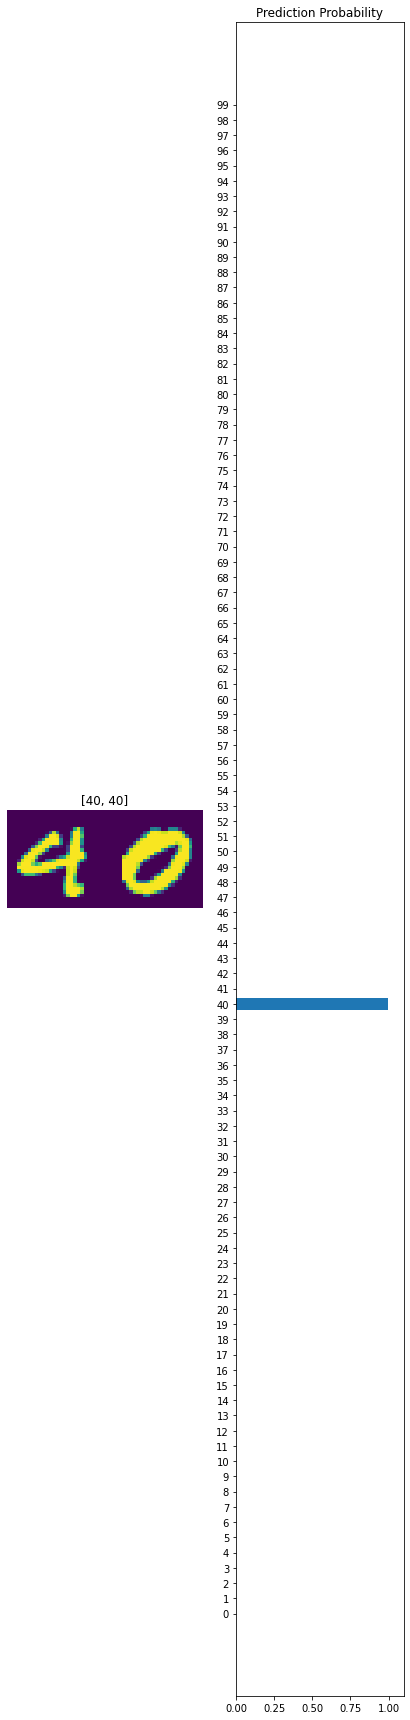

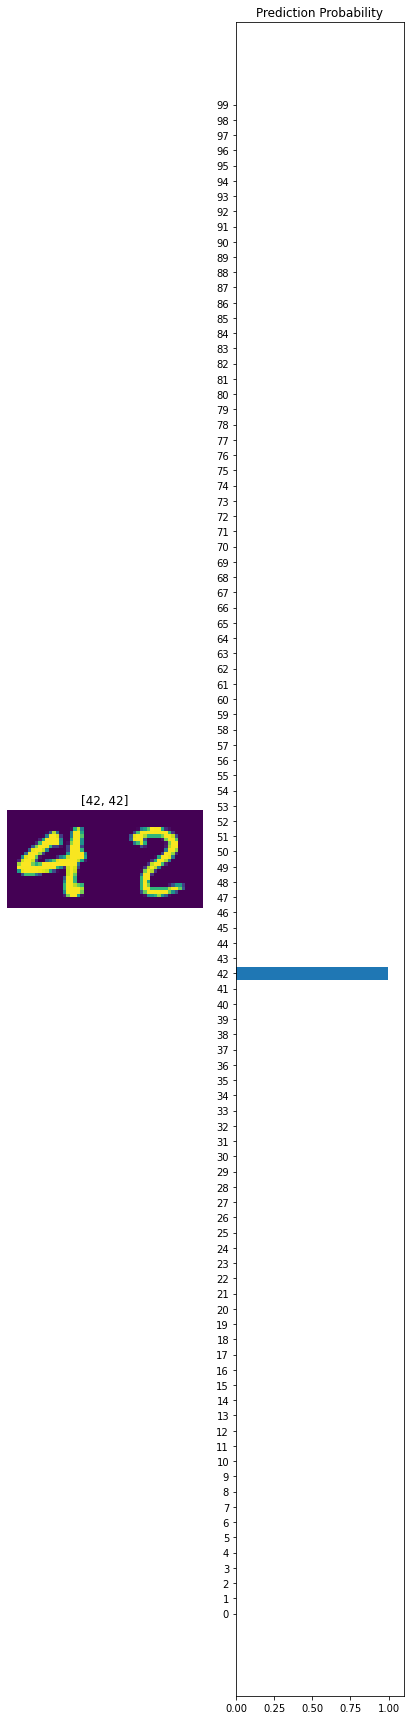

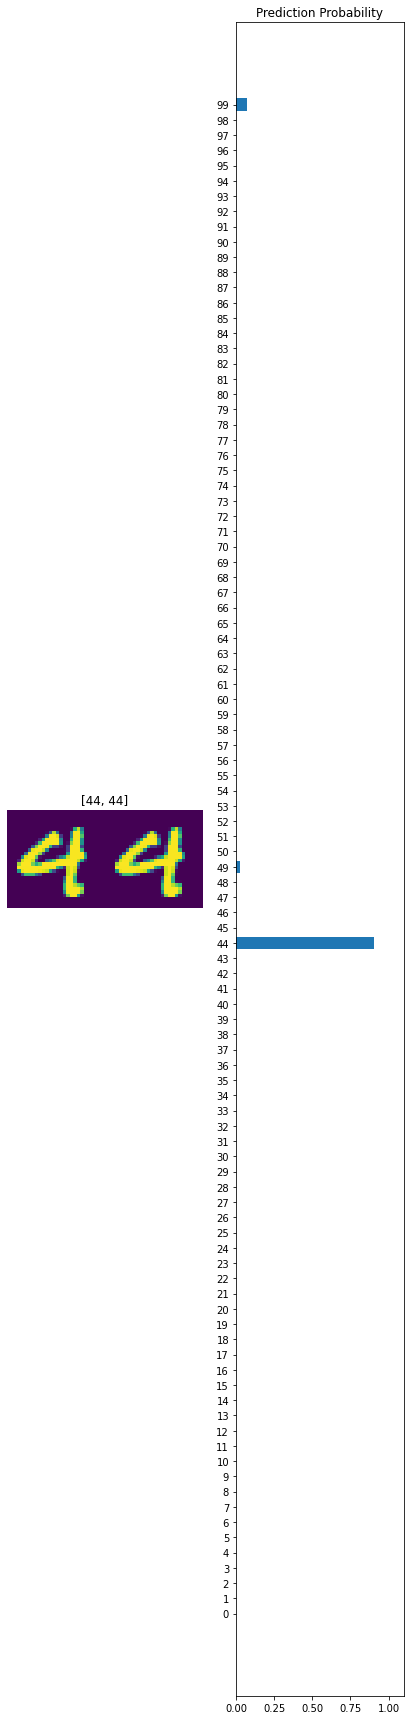

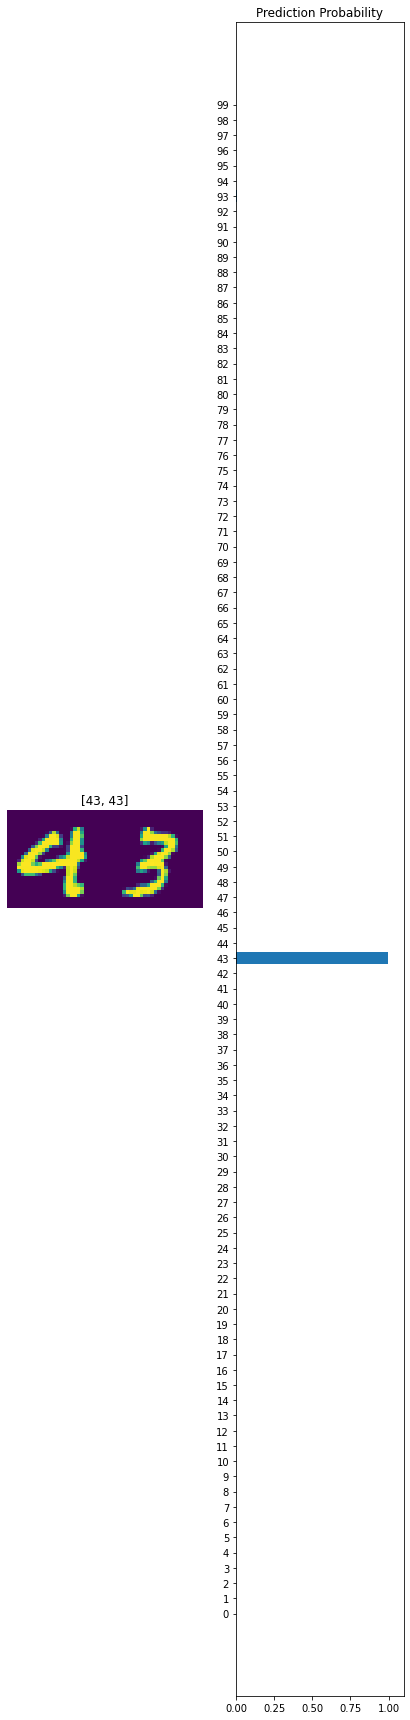

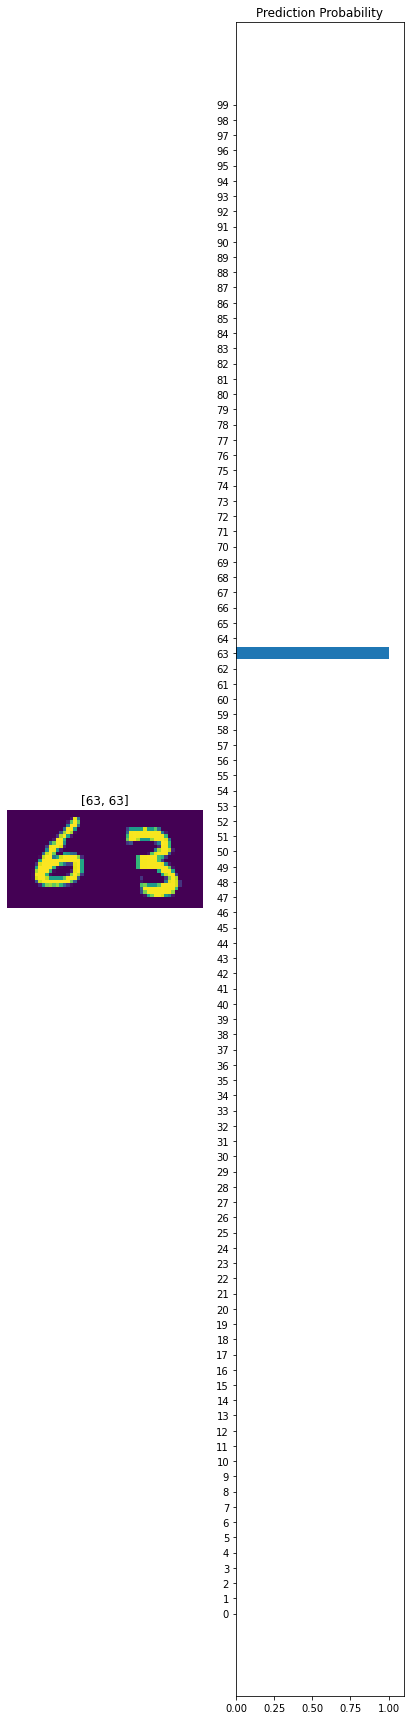

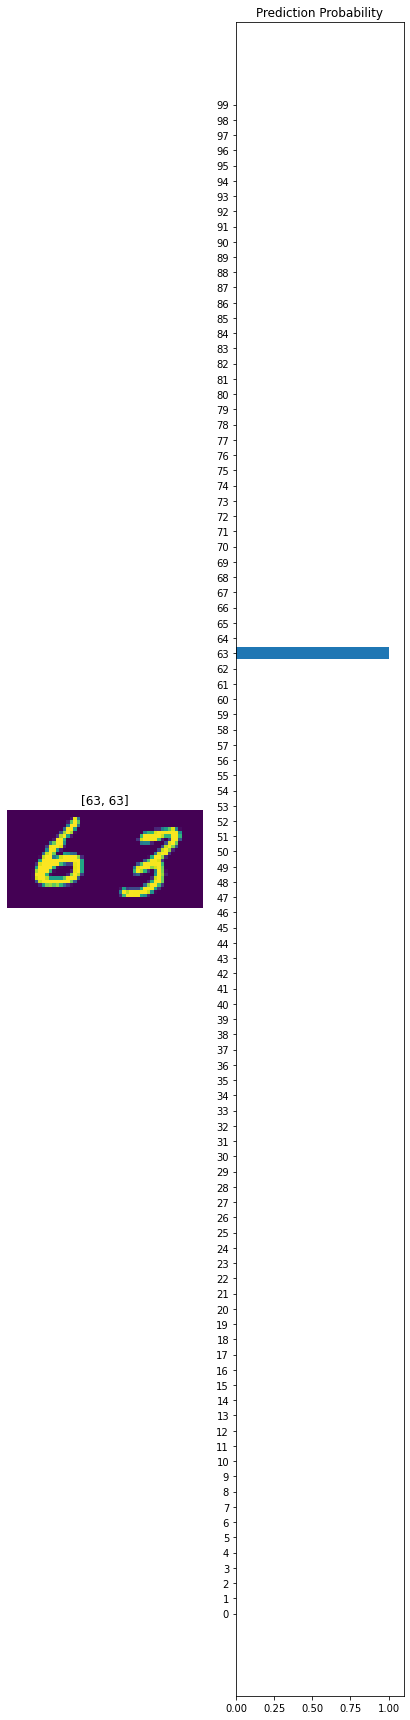

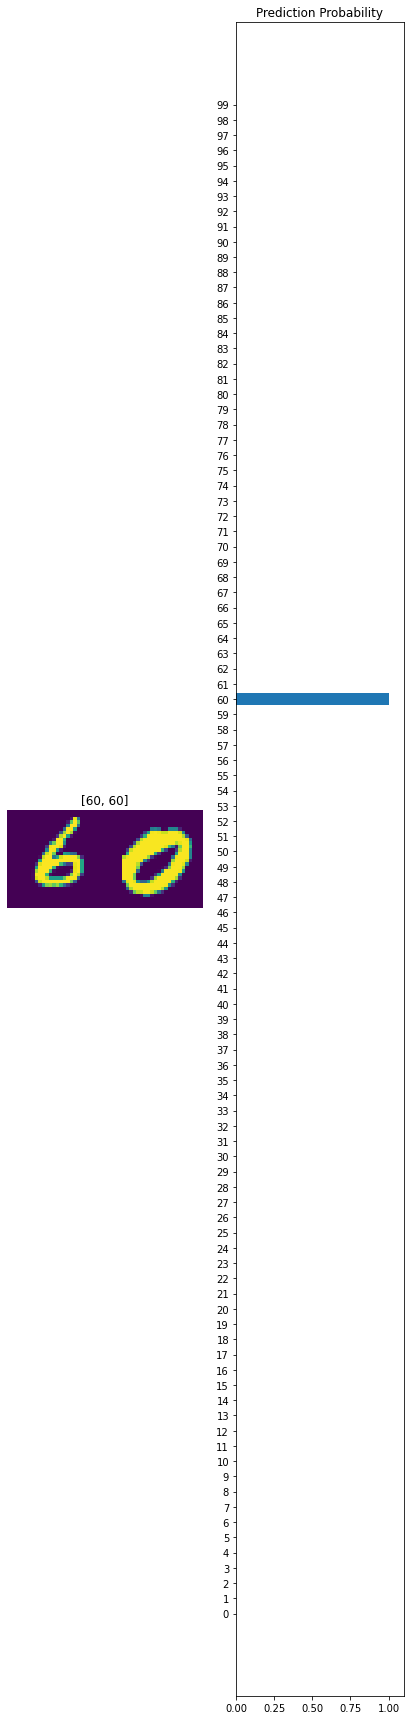

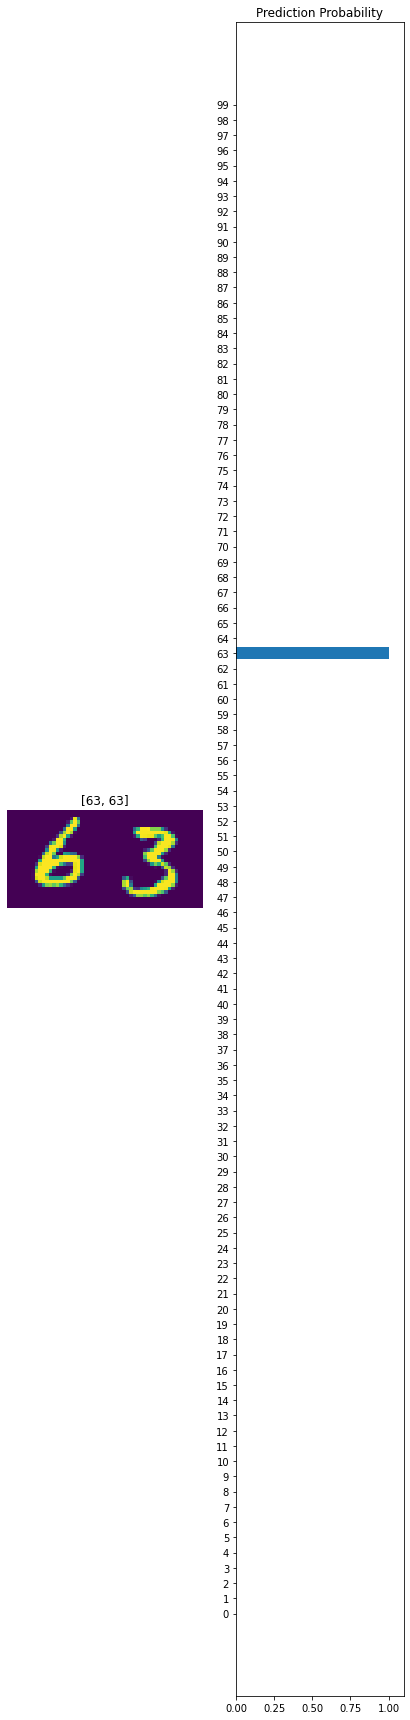

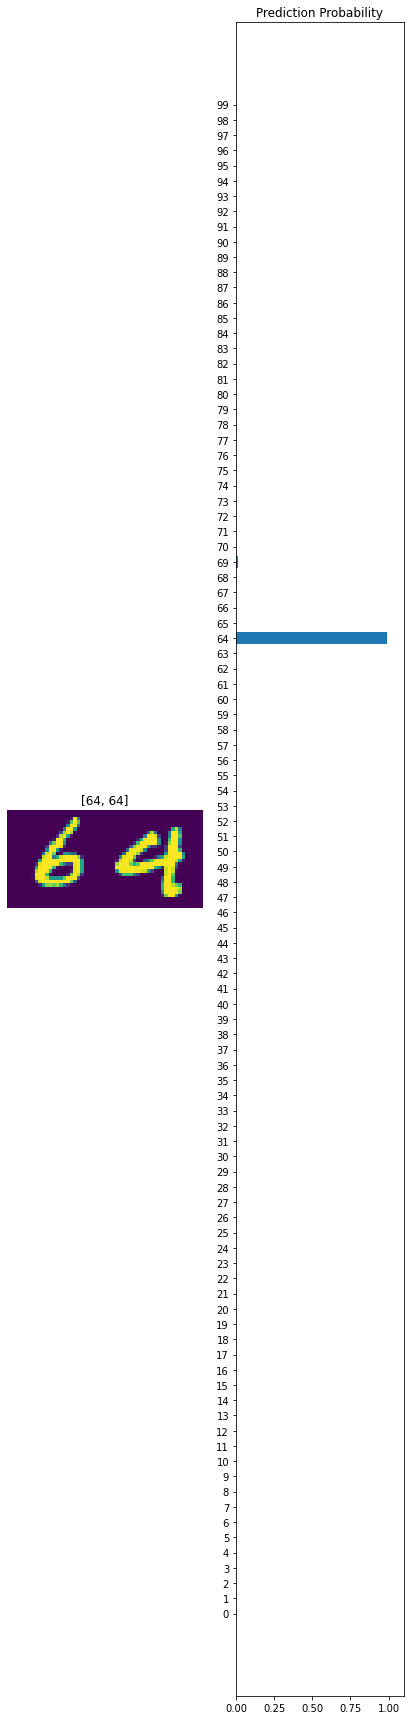

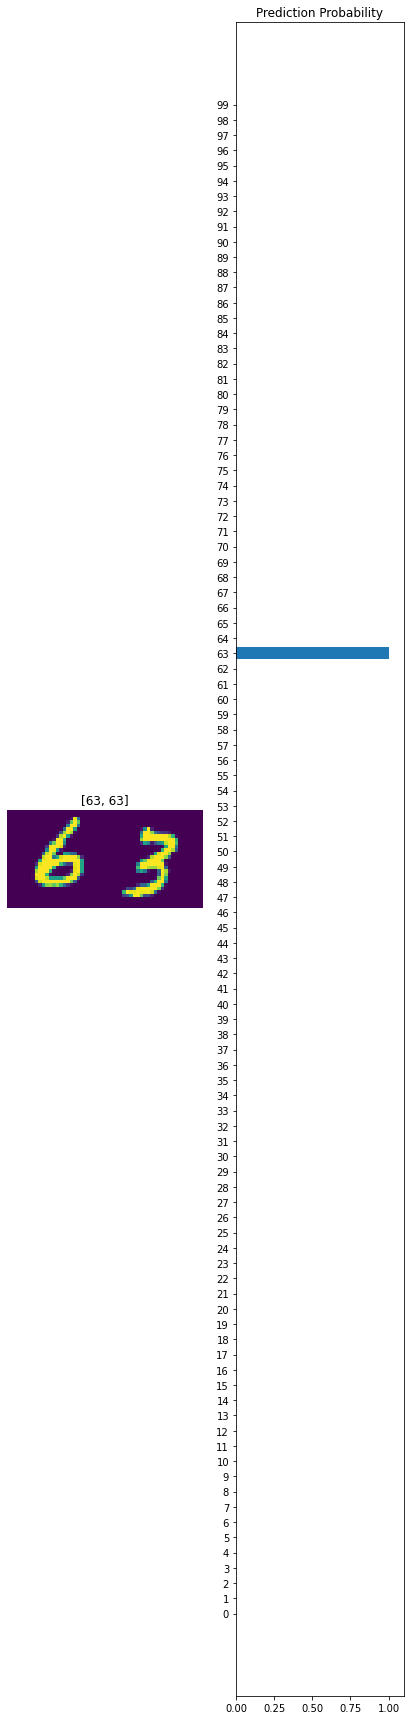

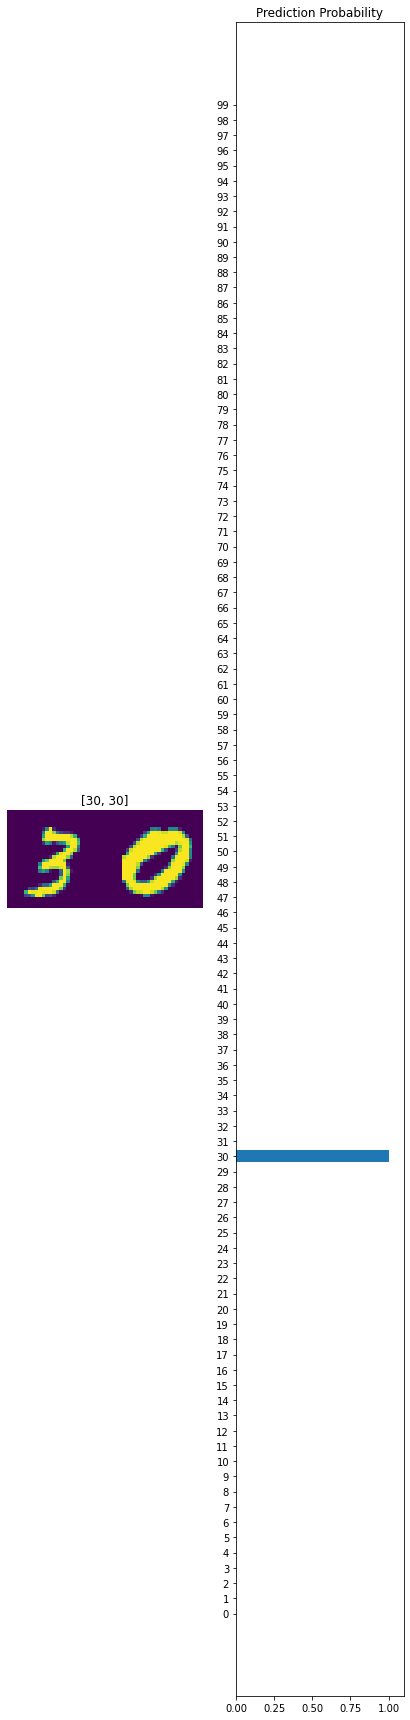

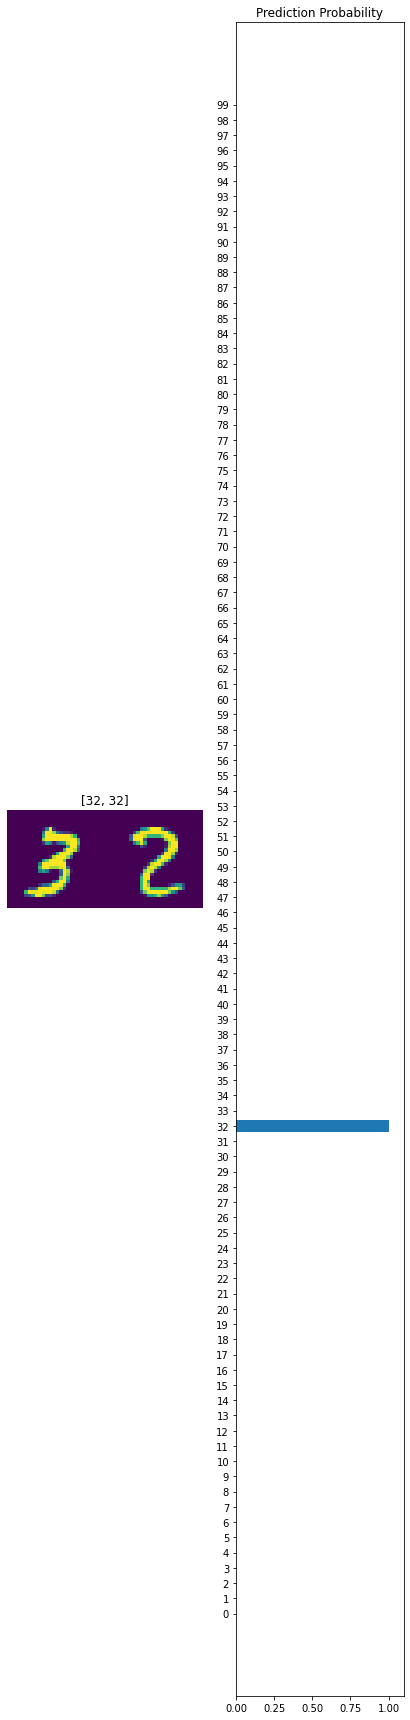

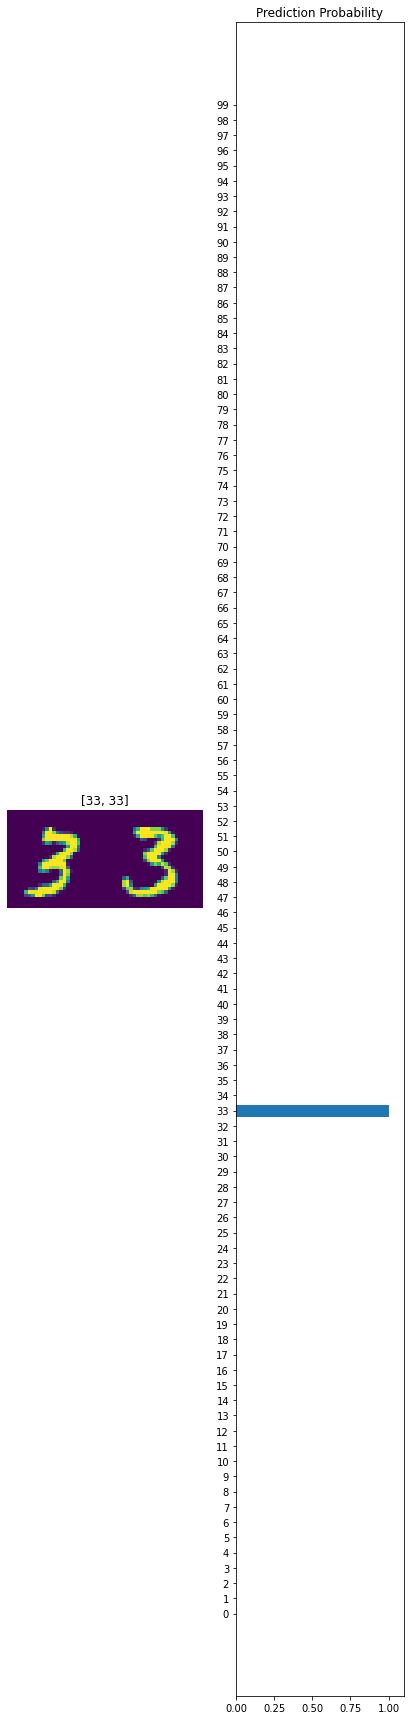

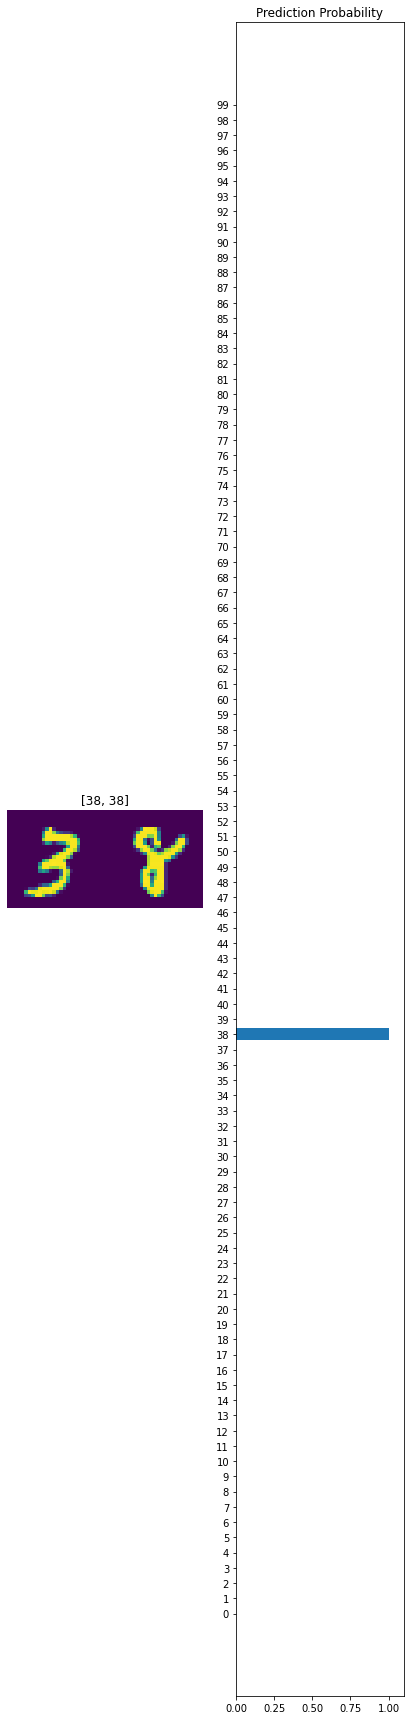

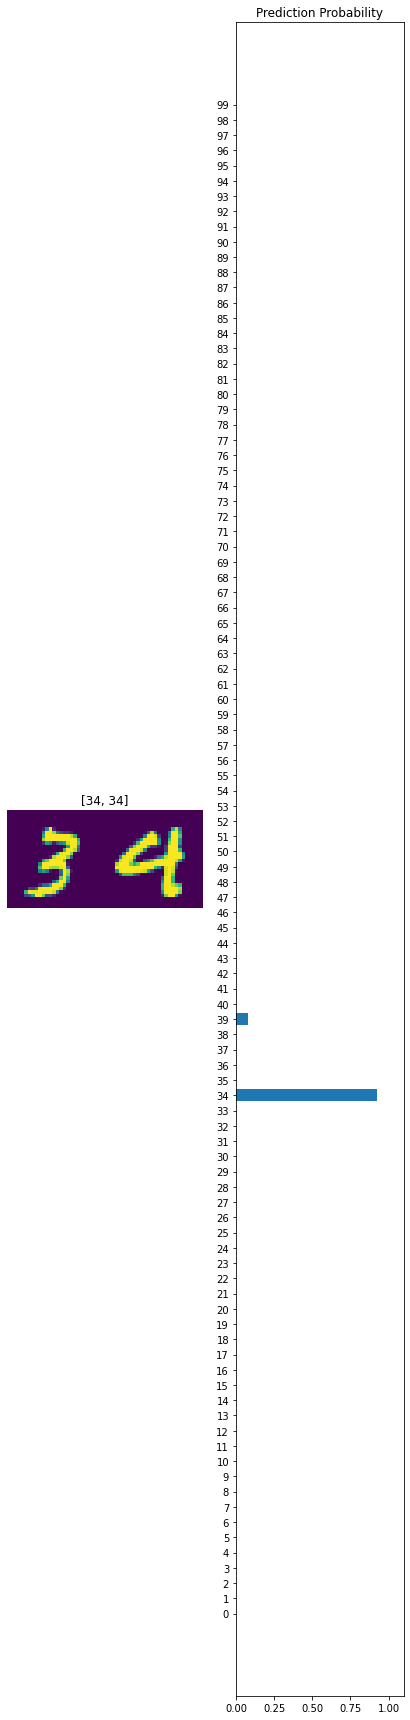

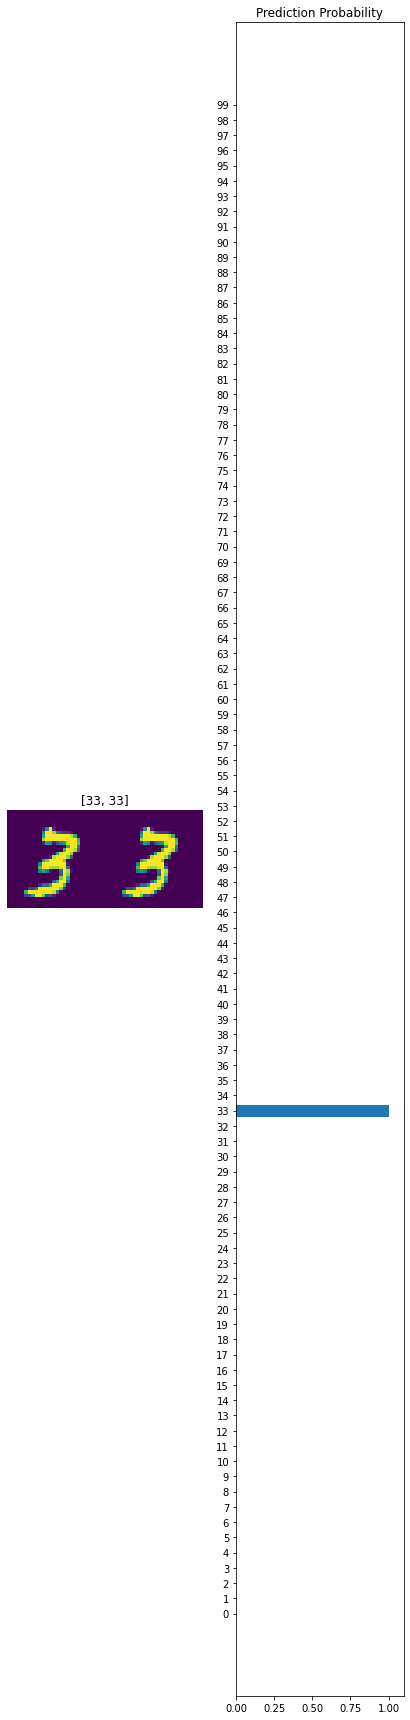

In [ ]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_data))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

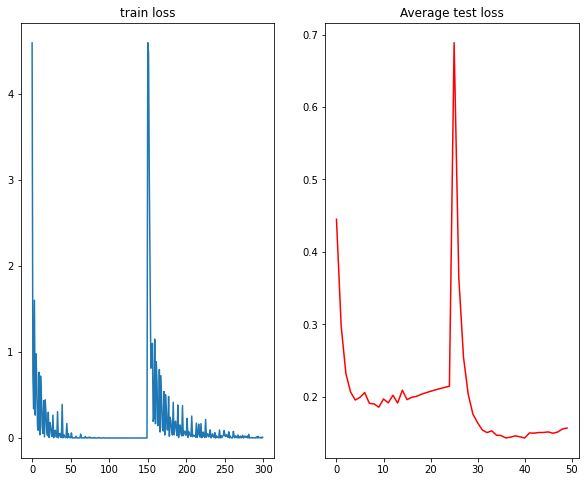

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
#plt.figure(figsize=(10, 5))
plt.plot(train_loss)
plt.title("train loss")
plt.subplot(1,2,2)
#plt.figure(figsize=(10, 5))
plt.plot(test_loss_list,color='red')
plt.title("Average test loss")
#plt.legend()
plt.show()